In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
import glob
import pickle
import nelpy.plotting as npl

from ripple_heterogeneity.replay import replay_fig
from scipy import stats
from ripple_heterogeneity.utils import custom_plots
from ripple_heterogeneity.replay import wmaze_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation
from scipy.ndimage import gaussian_filter1d
import warnings
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv", index_col=0)
df = df[df.basepath.str.contains("ORproject")]
df

basepath  basename
280      Z:\Data\ORproject\OR15\day1      day1
281     Z:\Data\ORproject\OR15\day10     day10
282      Z:\Data\ORproject\OR15\day2      day2
283      Z:\Data\ORproject\OR15\day3      day3
284      Z:\Data\ORproject\OR15\day4      day4
285  Z:\Data\ORproject\OR15\hc280118  hc280118
286  Z:\Data\ORproject\OR15\hc300118  hc300118
287      Z:\Data\ORproject\OR18\day1      day1
288      Z:\Data\ORproject\OR18\day2      day2
289      Z:\Data\ORproject\OR18\day3      day3
290      Z:\Data\ORproject\OR21\day2      day2
291      Z:\Data\ORproject\OR21\day4      day4
292      Z:\Data\ORproject\OR22\day1      day1
293      Z:\Data\ORproject\OR22\day3      day3
294      Z:\Data\ORproject\OR22\day4      day4
295      Z:\Data\ORproject\OR22\day5      day5
296      Z:\Data\ORproject\OR23\day1      day1
297      Z:\Data\ORproject\OR23\day5      day5

In [3]:
for basepath in df.basepath:
    manipulation_df = loading.load_manipulation(
        basepath, struct_name="optoStim", return_epoch_array=False
    )

In [74]:
# basepath = r"Z:\Data\ORproject\OR18\day2"
# wmaze_replay.run(basepath)


In [3]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\wmaze_closed_loop_replay_v5"
    )
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\wmaze_closed_loop_replay_v6_all_cells"
batch_analysis.run(
    df,
    save_path,
    wmaze_replay.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
results = wmaze_replay.load_results(save_path)

100%|██████████| 18/18 [00:00<00:00, 3008.35it/s]


In [4]:
results.ev_label.replace({np.nan: "natural"}, inplace=True)


In [27]:
results.keys()


Index(['start', 'stop', 'peaks', 'amplitude', 'duration', 'frequency',
       'peakNormedPower', 'detectorName', 'ripple_channel', 'event_spk_thres',
       'basepath', 'basename', 'animal', 'center', 'amplitudeUnits',
       'ev_label', 'n_active', 'inactive_bin_prop', 'trajectory_score',
       'r_squared', 'slope', 'intercept', 'score_pval_time_swap',
       'score_pval_col_cycle', 'traj_dist', 'traj_speed', 'traj_step',
       'replay_type', 'pop_partic', 'decoding_r2', 'decoding_r2_pval',
       'decoding_median_error', 'total_units', 'direction', 'index'],
      dtype='object')

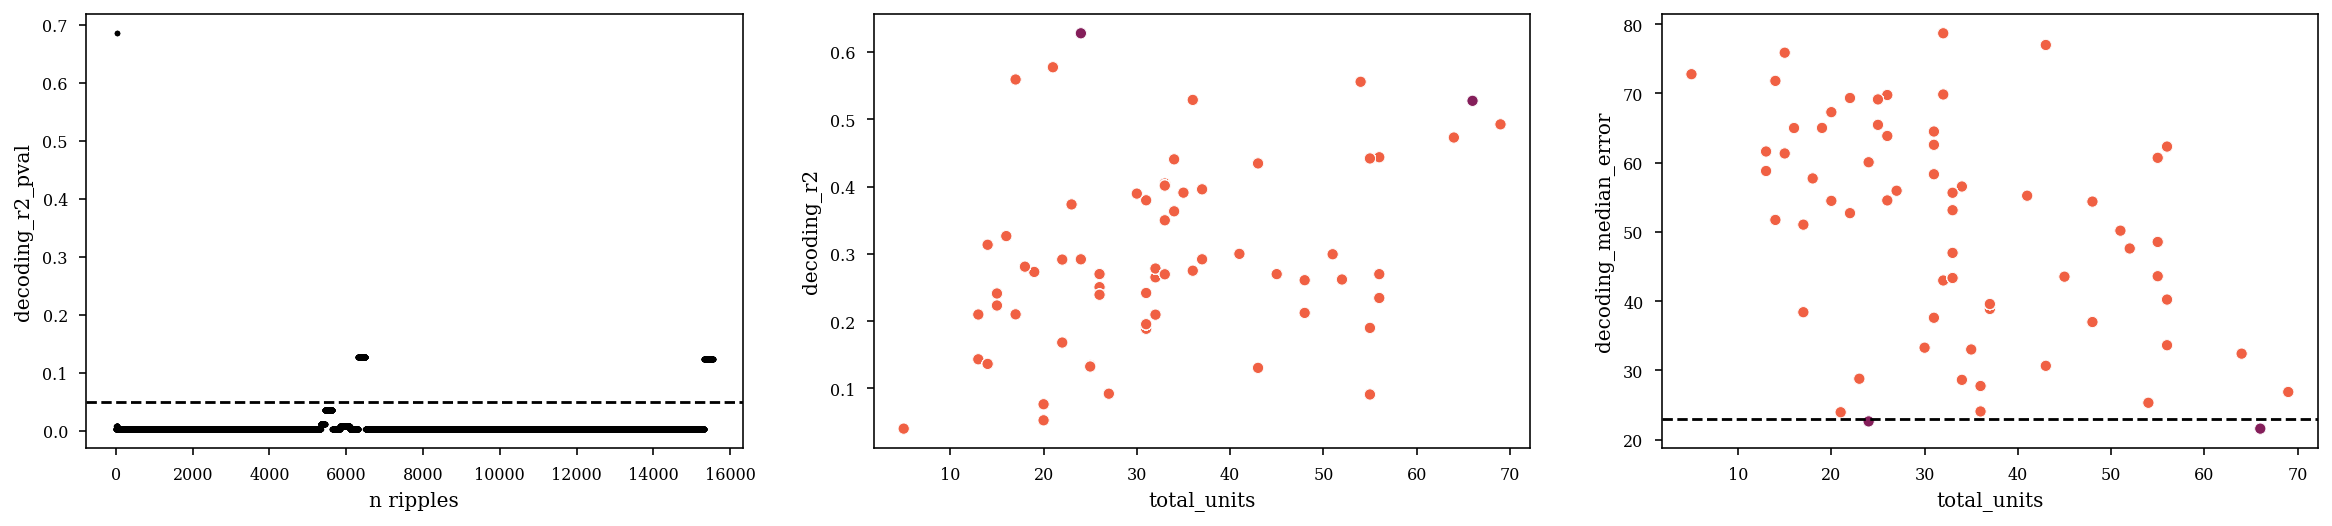

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].plot(results.decoding_r2_pval, '.k')
axs[0].set_ylabel('decoding_r2_pval')
axs[0].set_xlabel('n ripples')
axs[0].axhline(0.05, color='k', linestyle='--')

sns.scatterplot(x="total_units", y="decoding_r2",
                hue=results.decoding_median_error<23,
                data=results, ax=axs[1], legend=False, palette="rocket_r")

sns.scatterplot(x="total_units", y="decoding_median_error",
                hue=results.decoding_median_error<23,palette="rocket_r",
                data=results, ax=axs[2], legend=False)
# axs[2].legend(bbox_to_anchor=(1.1, 1.05))
axs[2].axhline(23, color='k', linestyle='--')

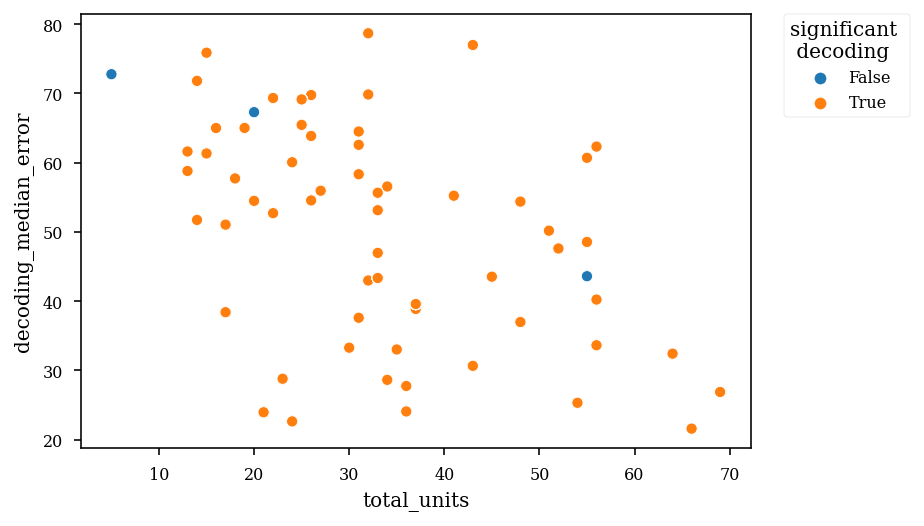

In [6]:
sns.scatterplot(x="total_units", y="decoding_median_error",hue=results.decoding_r2_pval<0.05, data=results)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title="significant \n decoding")

In [7]:
alpha = 0.05
print('n ripples', results.shape[0])
print('pass by col swap', sum(results['score_pval_col_cycle'] < alpha))

print(results[results['score_pval_col_cycle'] < alpha].basepath.value_counts())
print('')
print('pass by time swap', sum(results['score_pval_time_swap'] < alpha))
print(results[results['score_pval_time_swap'] < alpha].basepath.value_counts())
print('')
print('pass by time swap & col swap', sum(
    (results['score_pval_time_swap'] < alpha) & (results['score_pval_col_cycle'] < alpha)))
print(results[(results['score_pval_time_swap'] < alpha) & (
    results['score_pval_col_cycle'] < alpha)].basepath.value_counts())

n ripples 15549
pass by col swap 1945
Z:\Data\ORproject\OR22\day4     349
Z:\Data\ORproject\OR22\day3     264
Z:\Data\ORproject\OR22\day1     219
Z:\Data\ORproject\OR18\day3     196
Z:\Data\ORproject\OR23\day5     185
Z:\Data\ORproject\OR21\day4     138
Z:\Data\ORproject\OR22\day5     115
Z:\Data\ORproject\OR18\day1      92
Z:\Data\ORproject\OR23\day1      90
Z:\Data\ORproject\OR15\day10     75
Z:\Data\ORproject\OR15\day2      71
Z:\Data\ORproject\OR21\day2      62
Z:\Data\ORproject\OR15\day4      36
Z:\Data\ORproject\OR15\day3      33
Z:\Data\ORproject\OR18\day2      13
Z:\Data\ORproject\OR15\day1       7
Name: basepath, dtype: int64

pass by time swap 960
Z:\Data\ORproject\OR22\day4     171
Z:\Data\ORproject\OR22\day1     138
Z:\Data\ORproject\OR22\day3     124
Z:\Data\ORproject\OR18\day3     114
Z:\Data\ORproject\OR22\day5      69
Z:\Data\ORproject\OR21\day4      51
Z:\Data\ORproject\OR23\day5      45
Z:\Data\ORproject\OR15\day10     40
Z:\Data\ORproject\OR18\day1      40
Z:\Data\OR

In [8]:
results

start          stop         peaks    amplitude  duration  \
0       1056.230400   1056.327200   1056.280000   816.046829    0.0968   
1       1324.410400   1324.532800   1324.468800   362.686702    0.1224   
2       1521.418400   1521.517600   1521.457600   946.170715    0.0992   
3       1724.990400   1725.100000   1725.036000  1280.749383    0.1096   
4       1867.828000   1867.949600   1867.888000   605.525269    0.1216   
...             ...           ...           ...          ...       ...   
15544  11472.681667  11472.881667  11472.831667          NaN    0.2000   
15545  11478.228800  11478.332800  11478.300000   409.493457    0.1040   
15546  11499.137467  11499.337467  11499.287467          NaN    0.2000   
15547  11503.460800  11503.558400  11503.528800   689.491558    0.0976   
15548  11511.536800  11511.646400  11511.629600   545.909138    0.1096   

        frequency  peakNormedPower  detectorName  ripple_channel  \
0      171.350686              NaN  bz_DetectSWR            60.0   
1      200.715868              NaN  bz_DetectSWR            60.0   
2      153.196689              NaN  bz_DetectSWR            60.0   
3      182.120995              NaN  bz_DetectSWR            60.0   
4      167.024555              NaN  bz_DetectSWR            60.0   
...           ...              ...           ...             ...   
15544         NaN              NaN           NaN             NaN   
15545  128.172082              NaN  bz_DetectSWR            12.0   
15546         NaN              NaN           NaN             NaN   
15547  197.652271              NaN  bz_DetectSWR            12.0   
15548  200.051056              NaN  bz_DetectSWR            12.0   

       event_spk_thres  ...   traj_speed   traj_step replay_type  pop_partic  \
0                  1.0  ...  4220.425532   84.408511     reverse    0.538462   
1                  1.0  ...  3897.021277   77.940426     forward    0.384615   
2                  1.0  ...  3846.200608  115.386018     forward    0.461538   
3                  1.0  ...  1492.279635   29.845593     forward    0.615385   
4                  1.0  ...   309.544073    6.190881     forward    0.538462   
...                ...  ...          ...         ...         ...         ...   
15544              NaN  ...   379.090909    7.581818     forward    0.418182   
15545              1.0  ...   150.000000    3.000000     forward    0.200000   
15546              NaN  ...   195.454545    3.909091     reverse    0.272727   
15547              1.0  ...   645.000000   12.900000     reverse    0.181818   
15548              1.0  ...   355.714286    7.114286     forward    0.236364   

      decoding_r2 decoding_r2_pval  decoding_median_error  total_units  \
0        0.209890         0.003984              58.792285         13.0   
1        0.209890         0.003984              58.792285         13.0   
2        0.209890         0.003984              58.792285         13.0   
3        0.209890         0.003984              58.792285         13.0   
4        0.209890         0.003984              58.792285         13.0   
...           ...              ...                    ...          ...   
15544    0.091093         0.123506              43.597869         55.0   
15545    0.091093         0.123506              43.597869         55.0   
15546    0.091093         0.123506              43.597869         55.0   
15547    0.091093         0.123506              43.597869         55.0   
15548    0.091093         0.123506              43.597869         55.0   

          direction  index  
0       center_left    NaN  
1       center_left    NaN  
2       center_left    NaN  
3       center_left    NaN  
4       center_left    NaN  
...             ...    ...  
15544  right_center    NaN  
15545  right_center    NaN  
15546  right_center    NaN  
15547  right_center    NaN  
15548  right_center    NaN  

[15549 rows x 35 columns]

In [9]:
results.groupby(['basepath','ev_label','direction']).size().reset_index().rename(columns={0:'n_ripples'}).sort_values(by=['n_ripples'], ascending=False)

basepath     ev_label     direction  n_ripples
92   Z:\Data\ORproject\OR22\day1  closed_loop   center_left        466
95   Z:\Data\ORproject\OR22\day1  closed_loop  right_center        466
94   Z:\Data\ORproject\OR22\day1  closed_loop   left_center        465
93   Z:\Data\ORproject\OR22\day1  closed_loop  center_right        465
115  Z:\Data\ORproject\OR22\day4  closed_loop  right_center        317
..                           ...          ...           ...        ...
123  Z:\Data\ORproject\OR22\day4      natural  right_center          3
146  Z:\Data\ORproject\OR23\day1      natural   left_center          3
145  Z:\Data\ORproject\OR23\day1      natural  center_right          3
147  Z:\Data\ORproject\OR23\day1      natural  right_center          3
1    Z:\Data\ORproject\OR15\day1  closed_loop  center_right          2

[160 rows x 4 columns]

In [10]:
results.query("basepath=='Z:\Data\ORproject\OR18\day2'")

start         stop        peaks   amplitude  duration   frequency  \
3171      1.99925      2.19925      2.14925         NaN    0.2000         NaN   
3172      2.57410      2.77410      2.72410         NaN    0.2000         NaN   
3173      8.43305      8.63305      8.58305         NaN    0.2000         NaN   
3174     15.03515     15.23515     15.18515         NaN    0.2000         NaN   
3175     16.44650     16.64650     16.59650         NaN    0.2000         NaN   
...           ...          ...          ...         ...       ...         ...   
3334  14603.89390  14603.99390  14603.94390         NaN    0.1000         NaN   
3335  14832.89130  14832.99130  14832.94130         NaN    0.1000         NaN   
3336  15214.45935  15214.55935  15214.50935         NaN    0.1000         NaN   
3337  15416.87775  15416.97775  15416.92775         NaN    0.1000         NaN   
3338  15545.32640  15545.41200  15545.37440  178.402464    0.0856  166.126353   

      peakNormedPower  detectorName  ripple_channel  event_spk_thres  ...  \
3171              NaN           NaN             NaN              NaN  ...   
3172              NaN           NaN             NaN              NaN  ...   
3173              NaN           NaN             NaN              NaN  ...   
3174              NaN           NaN             NaN              NaN  ...   
3175              NaN           NaN             NaN              NaN  ...   
...               ...           ...             ...              ...  ...   
3334              NaN           NaN             NaN              NaN  ...   
3335              NaN           NaN             NaN              NaN  ...   
3336              NaN           NaN             NaN              NaN  ...   
3337              NaN           NaN             NaN              NaN  ...   
3338              NaN  bz_DetectSWR            40.0              0.0  ...   

       traj_speed  traj_step replay_type  pop_partic decoding_r2  \
3171   420.553524  12.616606     forward    0.333333    0.223254   
3172  1273.532485  40.753040     forward    0.400000    0.223254   
3173   761.928551  22.857857     forward    0.333333    0.223254   
3174   852.386125  27.276356     forward    0.333333    0.223254   
3175    89.286785   2.678604     reverse    0.533333    0.223254   
...           ...        ...         ...         ...         ...   
3334   150.000000   3.000000     forward    0.312500    0.326405   
3335    15.000000   0.300000     forward    0.375000    0.326405   
3336  1065.000000  21.300000     forward    0.437500    0.326405   
3337   255.000000   6.800000     reverse    0.312500    0.326405   
3338  1755.000000  35.100000     reverse    0.500000    0.326405   

     decoding_r2_pval  decoding_median_error  total_units     direction  \
3171         0.003984              75.872439         15.0   center_left   
3172         0.003984              75.872439         15.0   center_left   
3173         0.003984              75.872439         15.0   center_left   
3174         0.003984              75.872439         15.0   center_left   
3175         0.003984              75.872439         15.0   center_left   
...               ...                    ...          ...           ...   
3334         0.003984              64.996260         16.0  right_center   
3335         0.003984              64.996260         16.0  right_center   
3336         0.003984              64.996260         16.0  right_center   
3337         0.003984              64.996260         16.0  right_center   
3338         0.003984              64.996260         16.0  right_center   

       index  
3171     NaN  
3172     NaN  
3173     NaN  
3174     NaN  
3175     NaN  
...      ...  
3334     NaN  
3335     NaN  
3336     NaN  
3337     NaN  
3338  8499.0  

[168 rows x 35 columns]

In [11]:
results.groupby(["ev_label"]).apply(lambda x: (x.score_pval_col_cycle < 0.05).sum() / x.shape[0]).reset_index()

ev_label         0
0  closed_loop  0.128986
1      delayed  0.115512
2      natural  0.134312

In [12]:
results.groupby(["replay_type","ev_label"]).apply(lambda x: (x.score_pval_col_cycle < 0.05).sum() / x.shape[0]).reset_index()


replay_type     ev_label         0
0     forward  closed_loop  0.121151
1     forward      delayed  0.113850
2     forward      natural  0.140625
3     reverse  closed_loop  0.138465
4     reverse      delayed  0.117031
5     reverse      natural  0.125858
6     unknown  closed_loop  1.000000
7     unknown      delayed  0.500000
8     unknown      natural  1.000000

In [13]:
results.replay_type.value_counts()

forward    8427
reverse    7118
unknown       4
Name: replay_type, dtype: int64

<AxesSubplot:xlabel='ev_label', ylabel='pop_partic'>

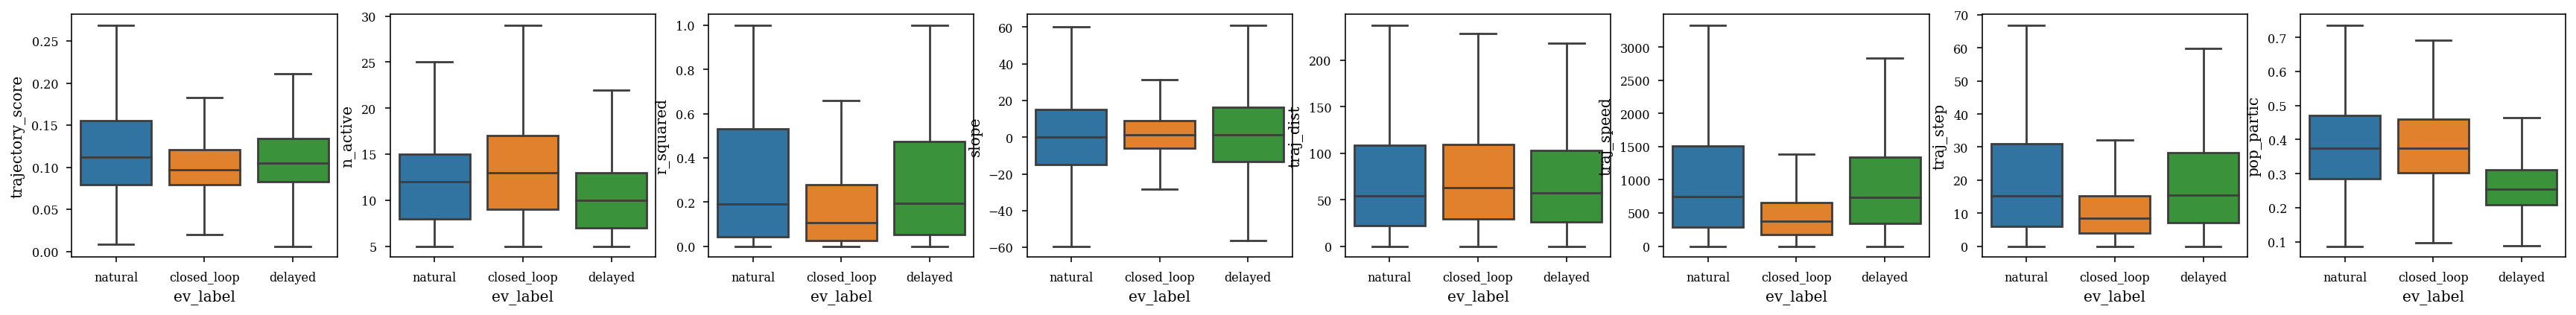

In [14]:
fig,ax = plt.subplots(1,8,figsize=(30,3))
order = ["natural","closed_loop","delayed"]

sns.boxplot(data=results, x="ev_label", y="trajectory_score",order=order,ax=ax[0],showfliers=False)
sns.boxplot(data=results, x="ev_label", y="n_active",order=order,ax=ax[1],showfliers=False)
sns.boxplot(data=results, x="ev_label", y="r_squared",order=order,ax=ax[2],showfliers=False)
sns.boxplot(data=results, x="ev_label", y="slope",order=order,ax=ax[3],showfliers=False)
sns.boxplot(data=results, x="ev_label", y="traj_dist",order=order,ax=ax[4],showfliers=False)
sns.boxplot(data=results, x="ev_label", y="traj_speed",order=order,ax=ax[5],showfliers=False)
sns.boxplot(data=results, x="ev_label", y="traj_step",order=order,ax=ax[6],showfliers=False)
sns.boxplot(data=results, x="ev_label", y="pop_partic",order=order,ax=ax[7],showfliers=False)



<AxesSubplot:xlabel='ev_label', ylabel='pop_partic'>

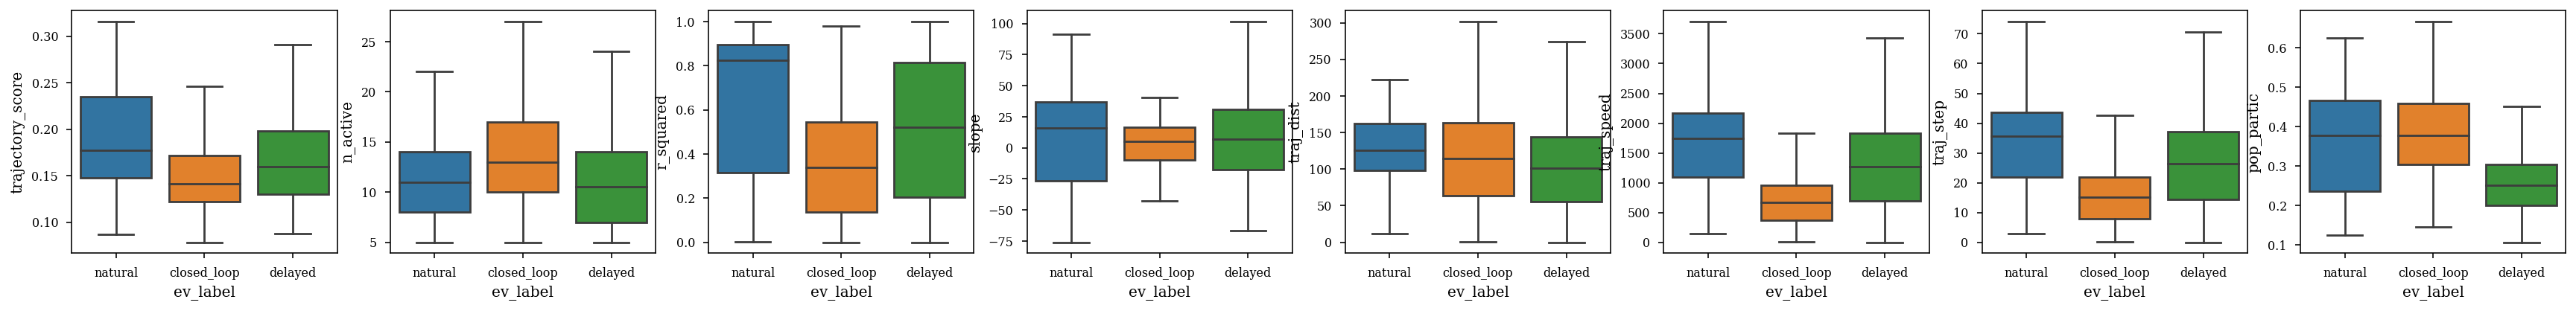

In [15]:
fig,ax = plt.subplots(1,8,figsize=(30,3))
order = ["natural","closed_loop","delayed"]

sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="trajectory_score",order=order,ax=ax[0],showfliers=False)
sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="n_active",order=order,ax=ax[1],showfliers=False)
sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="r_squared",order=order,ax=ax[2],showfliers=False)
sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="slope",order=order,ax=ax[3],showfliers=False)
sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="traj_dist",order=order,ax=ax[4],showfliers=False)
sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="traj_speed",order=order,ax=ax[5],showfliers=False)
sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="traj_step",order=order,ax=ax[6],showfliers=False)
sns.boxplot(data=results.query("score_pval_time_swap<=0.05"), x="ev_label", y="pop_partic",order=order,ax=ax[7],showfliers=False)


<AxesSubplot:xlabel='ev_label', ylabel='pop_partic'>

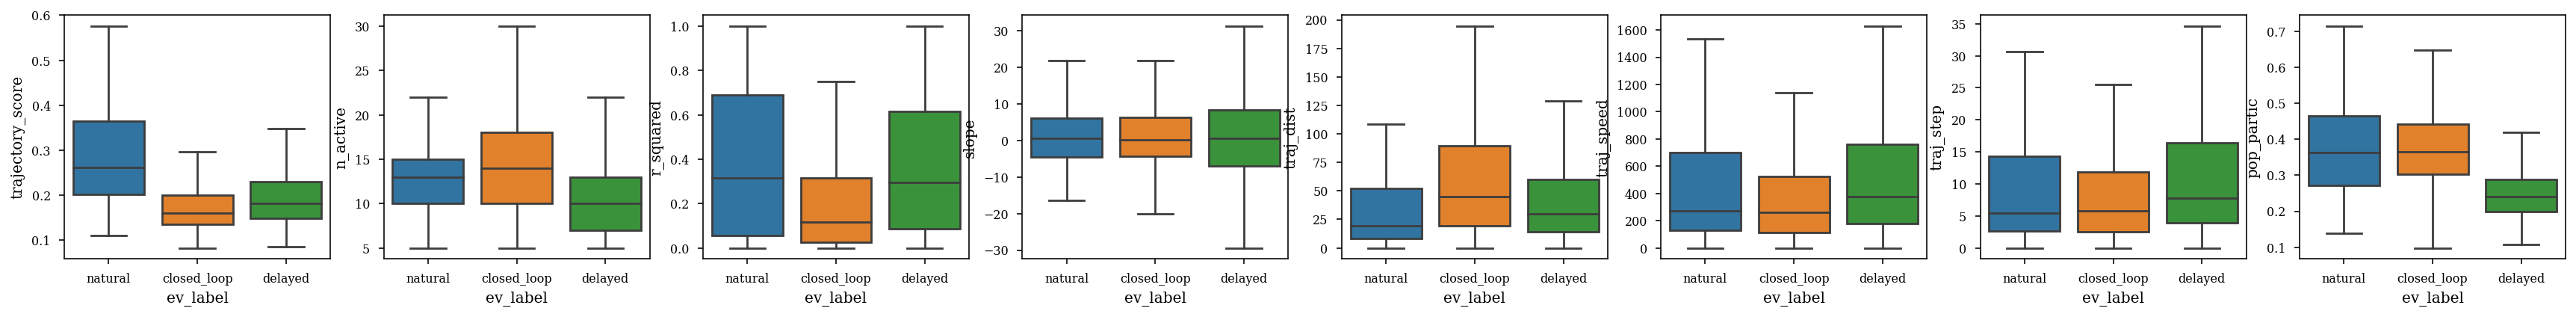

In [16]:
fig,ax = plt.subplots(1,8,figsize=(30,3))
order = ["natural","closed_loop","delayed"]
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="trajectory_score",order=order, ax=ax[0],showfliers=False)
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="n_active",order=order,ax=ax[1],showfliers=False)
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="r_squared",order=order,ax=ax[2],showfliers=False)
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="slope",order=order,ax=ax[3],showfliers=False)
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="traj_dist",order=order,ax=ax[4],showfliers=False)
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="traj_speed",order=order,ax=ax[5],showfliers=False)
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="traj_step",order=order,ax=ax[6],showfliers=False)
sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="pop_partic",order=order,ax=ax[7],showfliers=False)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

natural vs. closed_loop: Mann-Whitney-Wilcoxon test two-sided, P_val:8.247e-34 U_stat=1.259e+05
closed_loop vs. delayed: Mann-Whitney-Wilcoxon test two-sided, P_val:3.489e-12 U_stat=2.822e+05
natural vs. delayed: Mann-Whitney-Wilcoxon test two-sided, P_val:3.005e-20 U_stat=5.124e+04


(<AxesSubplot:xlabel='ev_label', ylabel='trajectory_score'>,
  <statannotations.Annotation.Annotation at 0x1cdcc7603a0>])

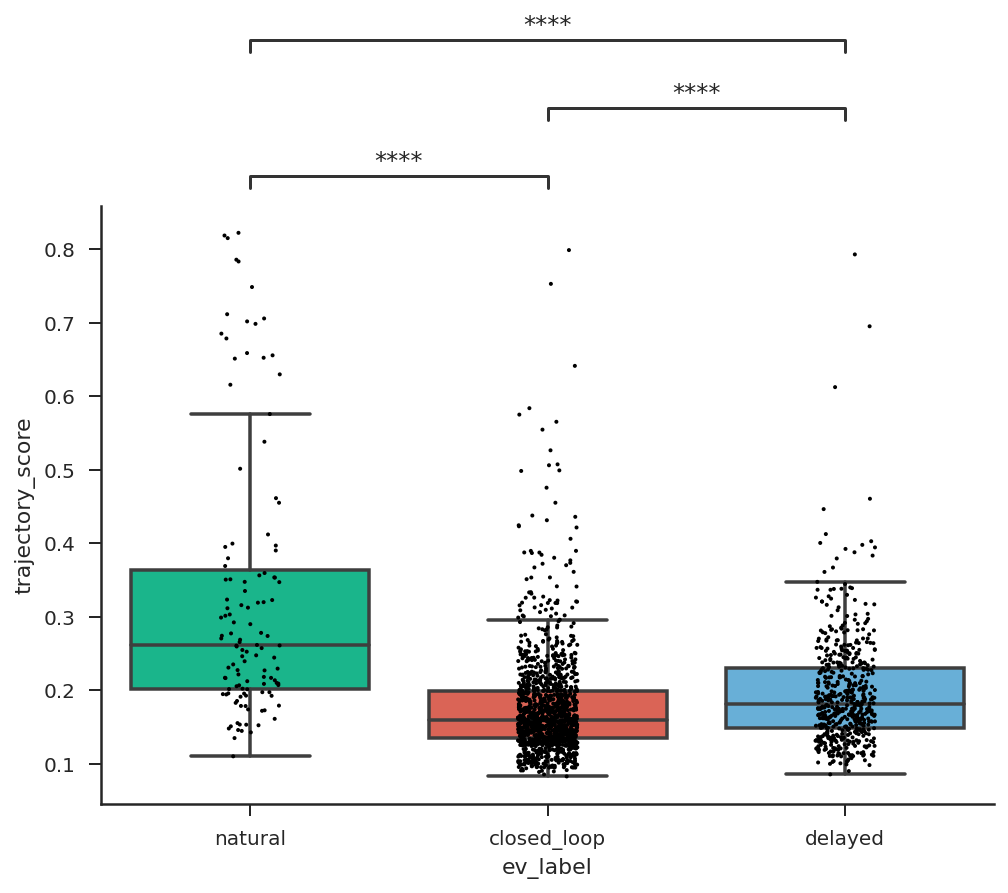

In [17]:
from statannotations.Annotator import Annotator
npl.setup()
order = ["natural","closed_loop","delayed"]

sns.boxplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="trajectory_score",order=order,showfliers=False)
sns.stripplot(data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="trajectory_score",jitter=True,order=order,size=2,color="black")
sns.despine()
box_pairs = [
    ('natural', "closed_loop"),
    ('natural', "delayed"), 
    ('closed_loop', "delayed"),
]
annotator = Annotator(plt.gca(), box_pairs, data=results.query("score_pval_col_cycle<=0.05"), x="ev_label", y="trajectory_score")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside',comparisons_correction=None,verbose=1)
annotator.apply_and_annotate()

In [ ]:
def plot_the_replays(curr_results, dir_epoch, replay_type, ripple_type):
    try:
        basepath = curr_results[dir_epoch]["session"]
    except:
        return
    animal_name = loading.get_animal_id(basepath)
    basename = os.path.basename(basepath)

    curr_results[dir_epoch]["df"].ev_label.replace({np.nan: "natural"}, inplace=True)

    # idx = np.where(
    #     (curr_results[dir_epoch]["df"].score_pval_col_cycle < 0.05)
    #     & (curr_results[dir_epoch]["df"].replay_type == replay_type)
    # )[0]
    idx = np.where(
        (curr_results[dir_epoch]["df"].replay_type == replay_type)
        & (curr_results[dir_epoch]["df"].ev_label == ripple_type)
    )[0]

    # if curr_results[dir_epoch]["decoding_r2_pval"] > 0.05:
    #     idx = []

    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(
            curr_results[dir_epoch]["bst_placecells"][idx],
            curr_results[dir_epoch]["sta_placecells"],
            curr_results[dir_epoch]["tc"],
            curr_results[dir_epoch]["tc"],
            vmax=0.1,
        )
        fig.savefig(
            os.path.join(
                r"Z:\home\ryanh\projects\ripple_heterogeneity\wmaze_closed_loop_replay_v6_all_cells\examples",
                basename
                + "_"
                + animal_name
                + "_"
                + dir_epoch
                + "_"
                + replay_type
                + "_"
                + ripple_type
                + ".jpeg",
            ),
            dpi=300,
            bbox_inches="tight",
        )
        # plt.show(block=False)
        plt.close('all')


sessions = glob.glob(save_path + os.sep + "*.pkl")
for session in sessions:
    with open(session, "rb") as f:
        curr_results = pickle.load(f)

    if curr_results is None:
        continue
    for traj in curr_results.keys():
        for ripple_type in ["closed_loop", "delayed", "natural"]:
            plot_the_replays(curr_results, traj, "forward", ripple_type)
            plot_the_replays(curr_results, traj, "reverse", ripple_type)
    # plot_the_replays(curr_results,"outbound_epochs","reverse")
    # plot_the_replays(curr_results,"inbound_epochs","reverse")


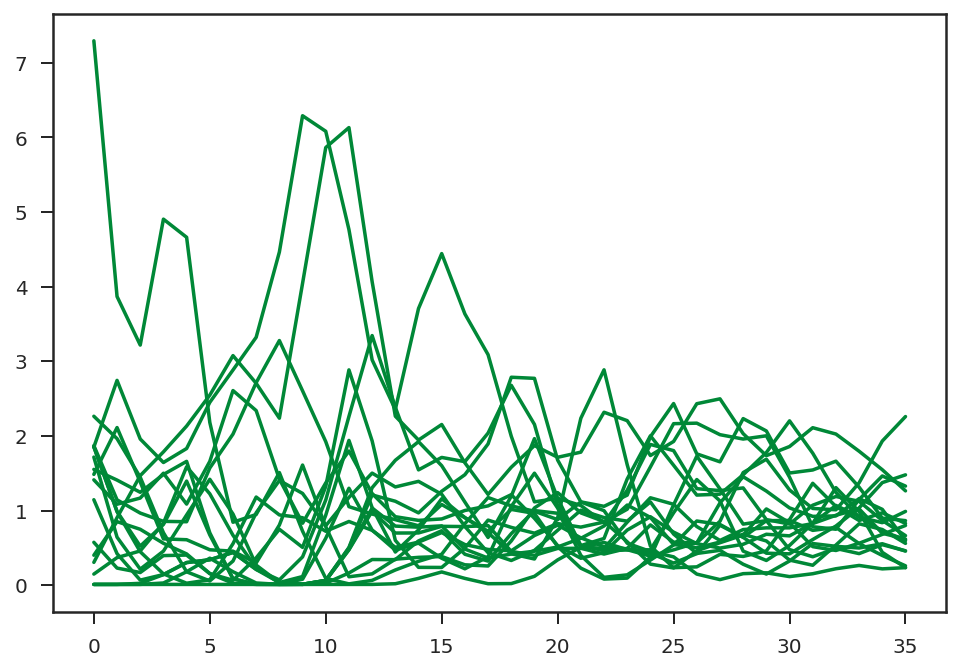

In [73]:
plt.plot(tc.ratemap.T)
plt.show()

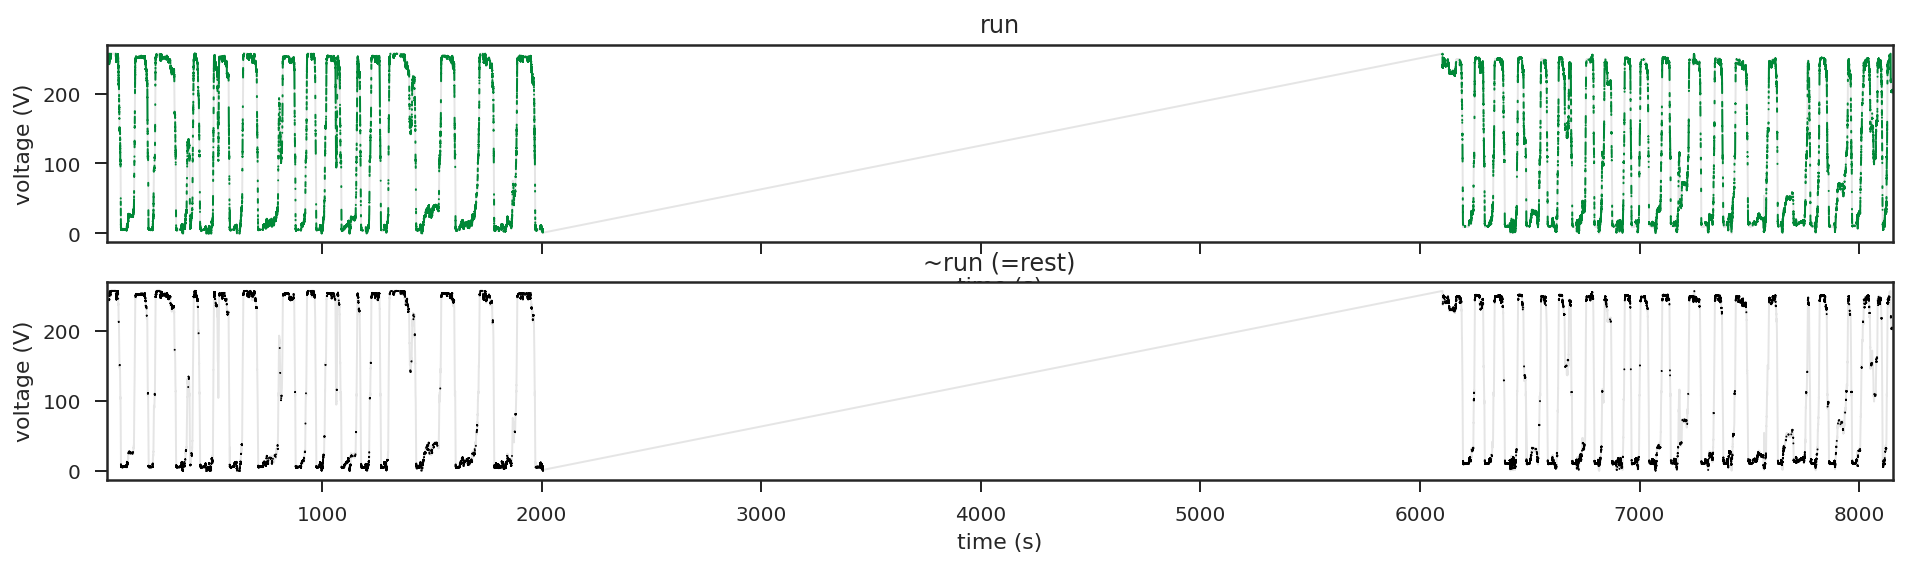

In [59]:
speed_thres = 3
speed1 = nel.utils.ddt_asa(pos, smooth=True, sigma=0.1, norm=True)

run_epochs = nel.utils.get_run_epochs(
    speed1, v1=speed_thres, v2=speed_thres
).merge()
with npl.FigureManager(show=True, nrows=2, figsize=(16,4)) as (fig, axes):
    npl.utils.skip_if_no_output(fig)
    ax0, ax1 = axes
    for ax in axes:
        ax.plot(pos.time, pos.asarray().yvals, lw=1, alpha=0.2, color='gray')
        ax.set_ylabel('position (%)')
    
    npl.plot(pos[run_epochs], ax=ax0, lw=1, label='run')
    npl.plot(pos[~run_epochs], ax=ax1, lw=1, label='run', color='k')
    
    npl.utils.no_xticklabels(ax0)
    
    ax0.set_title('run')
    ax1.set_title('~run (=rest)')

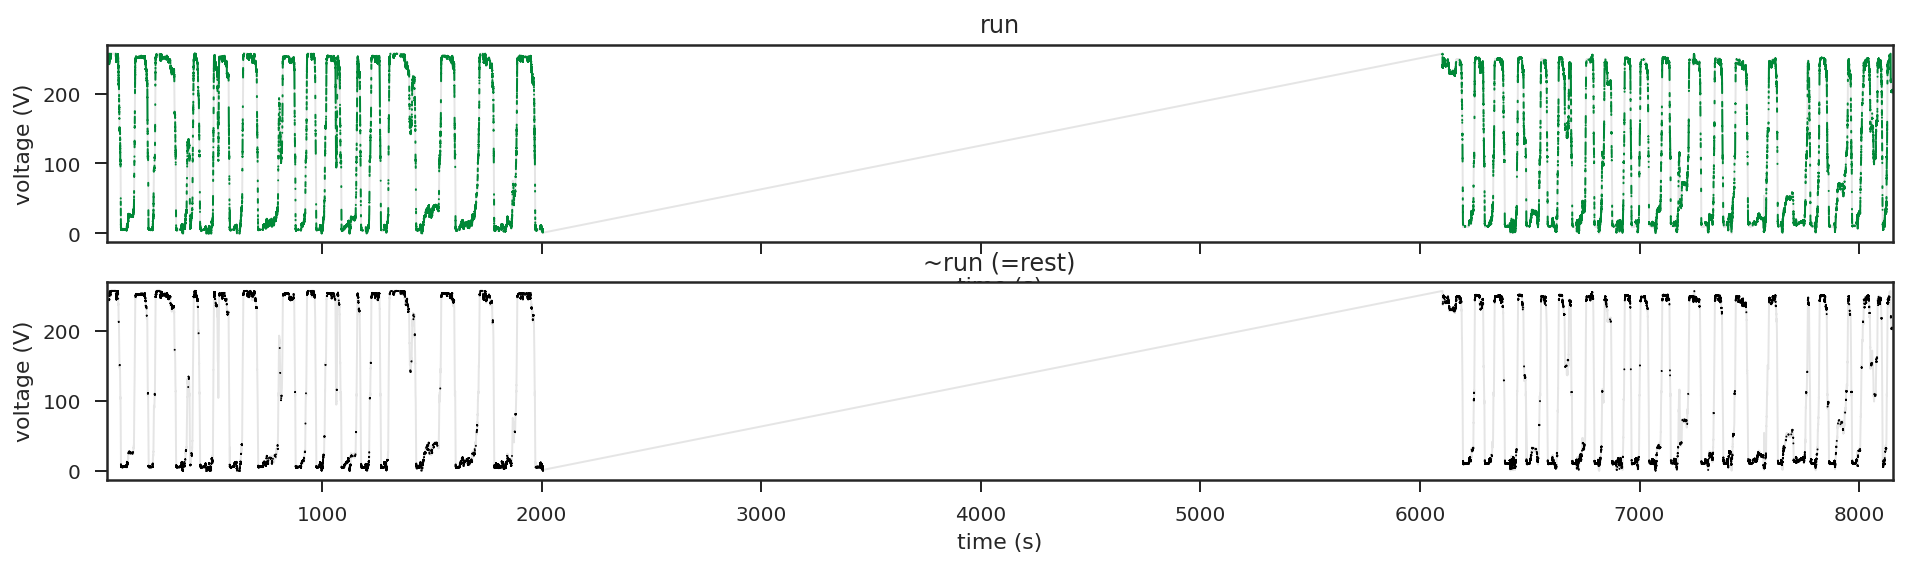

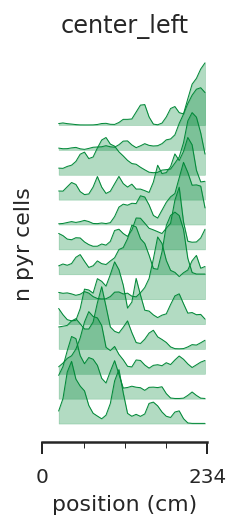

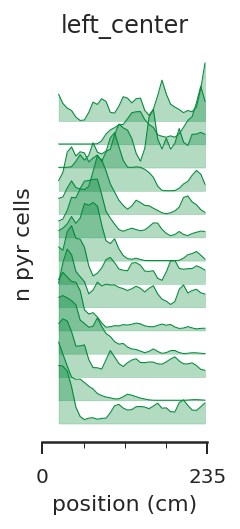

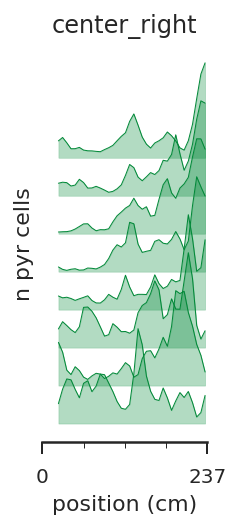

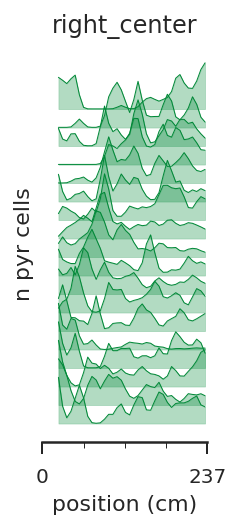

In [64]:
basepath = r"Z:\Data\ORproject\OR22\day3"
max_distance_from_well=20  # in cm, max distance from well to consider a well traversal
min_distance_traveled=50  

epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

position_df = loading.load_animal_behavior(basepath)
# remove nan values
bad_idx = np.isnan(position_df.linearized)
position_df = position_df[~bad_idx]

# add position to nelpy array
pos = nel.AnalogSignalArray(
    data=np.array(position_df.linearized),
    timestamps=position_df.time,
    fs=position_df.sr.iloc[0],
)
# restrict to wmaze
pos = pos[beh_epochs[epoch_df.environment == "wmaze"]]

speed1 = nel.utils.ddt_asa(pos, smooth=True, sigma=0.1, norm=True)

run_epochs = nel.utils.get_run_epochs(
    speed1, v1=speed_thres, v2=speed_thres
).merge()
with npl.FigureManager(show=True, nrows=2, figsize=(16,4)) as (fig, axes):
    npl.utils.skip_if_no_output(fig)
    ax0, ax1 = axes
    for ax in axes:
        ax.plot(pos.time, pos.asarray().yvals, lw=1, alpha=0.2, color='gray')
        ax.set_ylabel('position (%)')
    
    npl.plot(pos[run_epochs], ax=ax0, lw=1, label='run')
    npl.plot(pos[~run_epochs], ax=ax1, lw=1, label='run', color='k')
    
    npl.utils.no_xticklabels(ax0)
    
    ax0.set_title('run')
    ax1.set_title('~run (=rest)')

# locate each trajectory start and end
trajectories = wmaze_replay.get_w_maze_trajectories(
    position_df,
    max_distance_from_well=max_distance_from_well,
    min_distance_traveled=min_distance_traveled,
)

# pos, outbound_epochs, inbound_epochs = replay_run.handle_behavior(
#     basepath, epoch_df, beh_epochs
# )
st_all, cell_metrics = loading.load_spikes(basepath,brainRegion="CA1",putativeCellType="Pyr")

traj_shuff=1500  # number of shuffles to determine sig replay
behav_shuff=250  # number of shuffles to determine sig decoding
ds_50ms=0.05  # bin width to bin st for tuning curve
s_binsize=6  # spatial bins in tuning curve
speed_thres=3  # running threshold to determine tuning curves
min_rip_dur=0.08  # min ripple duration for replay
place_cell_min_rate=1  # min peak rate of tuning curve
place_cell_min_spks=100  # at least 100 spikes while running above speed_thres
place_cell_peak_mean_ratio=2.5  # peak firing rate / mean firing rate
replay_binsize=0.02  # bin size to decode replay
tuning_curve_sigma=5
ds_beh_decode=0.2

for traj in trajectories.keys():

    tc, st_run, bst_run = wmaze_replay.get_tuning_curves(
        pos, st_all, trajectories[traj], speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
    )

    (
        sta_placecells,
        tc,
        bst_run,
        cell_metrics_,
        total_units,
    ) = wmaze_replay.restrict_to_place_cells(
        tc,
        st_run,
        bst_run,
        st_all,
        cell_metrics,
        place_cell_min_spks,
        place_cell_min_rate,
        place_cell_peak_mean_ratio,
    )
    cell_metrics_ = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics_)

    colors = ['#999999']*cell_metrics_.shape[0]
    colors = np.array(colors)
    colors[cell_metrics_.deepSuperficial == "Deep"] = ["#7b3294"]
    colors[cell_metrics_.deepSuperficial == "Superficial"] = ["#008837"]


    # sns.heatmap(tc.ratemap)
    w, h = functions.set_size('thesis', fraction=.25, subplots=(4, 1))
    a,b,sort_idx = np.intersect1d(np.array(tc.unit_ids),np.array(tc.get_peak_firing_order_ids()),return_indices=True)

    tc_ = tc.reorder_units()
    # tc_ = tc_.smooth(sigma=3)

    # npl.set_palette(npl.colors.rainbow)
    npl.set_palette(colors[sort_idx])

    with npl.FigureManager(show=True, figsize=(w, h)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)
        ax1 = npl.plot_tuning_curves1D(
            tc_, normalize=True, pad=.4, fill=True)
        leg_lines = ax1.get_lines()
        plt.setp(leg_lines, linewidth=.5)
        ax.set_xlabel('position (cm)')
        ax.set_ylabel('n pyr cells')
        # ax.set_yticks([0,tc.ratemap.shape[0]])
        ax.set_yticks([])
        ax.set_xticks([0, tc_.bins.max()])

        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_title(traj)

In [133]:
median_error = []
rvalue = []
st_all, cell_metrics = loading.load_spikes(basepath,brainRegion="CA1")

for speed_thres in np.arange(0,10):

    tc, st_run, bst_run = wmaze_replay.get_tuning_curves(
        pos, st_all, trajectories[traj], speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
    )
    (
        sta_placecells,
        tc,
        bst_run,
        cell_metrics_,
        total_units,
    ) = wmaze_replay.restrict_to_place_cells(
        tc,
        st_run,
        bst_run,
        st_all,
        cell_metrics,
        place_cell_min_spks,
        place_cell_min_rate,
        place_cell_peak_mean_ratio,
    )
    bst_run_beh = sta_placecells[trajectories[traj]].bin(ds=ds_beh_decode)

    rvalue_, median_error_ = wmaze_replay.decode_and_score(bst_run_beh, tc, pos)
    median_error.append(median_error_)
    rvalue.append(rvalue_)

In [83]:
speed1 = nel.utils.ddt_asa(pos[trajectories[traj]], smooth=True, sigma=0.1, norm=True)
speed1.data

array([[12.61709757, 12.92809368, 13.55257661, ..., 32.41872983,
        32.23094047, 31.75700632]])

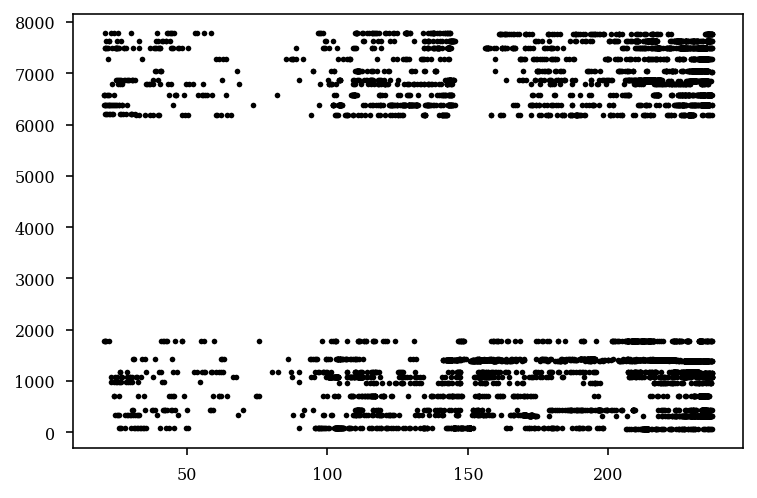

In [97]:
plt.plot(pos[trajectories[traj]].data[0],pos[trajectories[traj]].abscissa_vals,'.k')

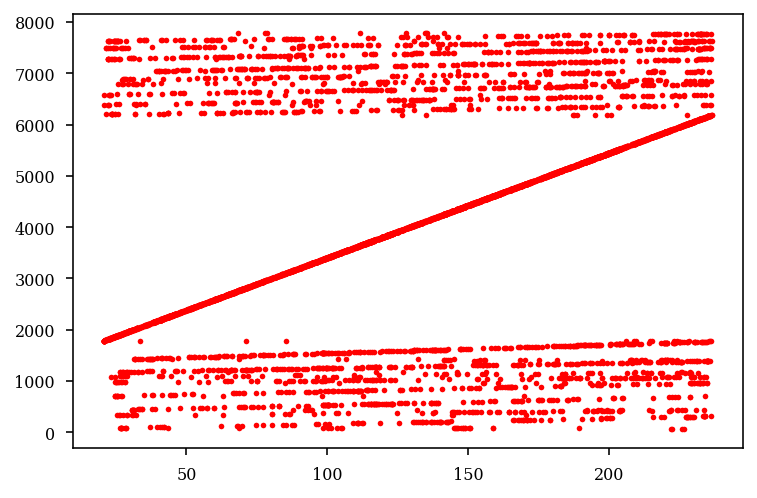

In [113]:
plt.plot(pos_at_spikes, sta_placecells[:,unit_id].time[0], '.r')


In [125]:
sta_placecells.unit_ids

[2,
 4,
 5,
 6,
 8,
 9,
 12,
 13,
 15,
 16,
 17,
 19,
 20,
 21,
 25,
 27,
 28,
 30,
 33,
 34,
 35,
 40,
 41,
 42,
 43,
 44,
 45,
 48,
 49,
 51,
 52,
 61,
 62,
 64,
 65,
 66,
 70,
 71,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 84,
 85,
 87]

(6000.0, 8000.0)

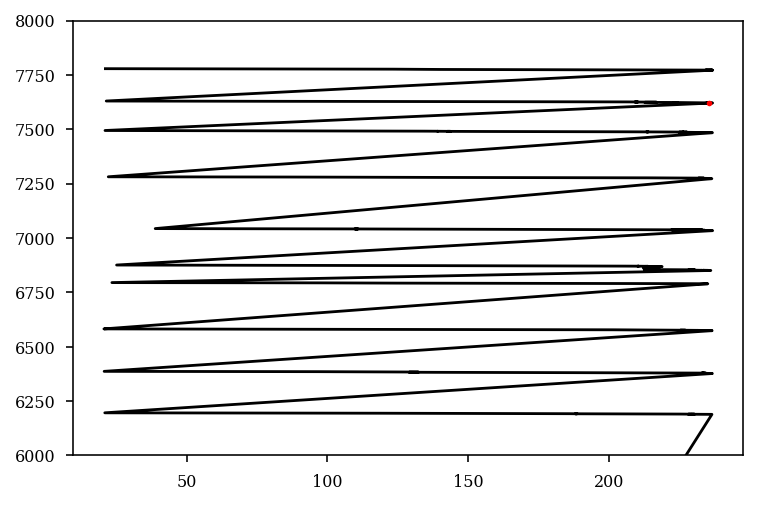

In [135]:
unit_id = 5
plt.plot(pos[trajectories[traj]].data[0],pos[trajectories[traj]].abscissa_vals,'k')
_, pos_at_spikes = pos[trajectories[traj]].asarray(at=sta_placecells[trajectories[traj]][:,unit_id].time)
plt.plot(pos_at_spikes, sta_placecells[trajectories[traj]][:,unit_id].time[0], '.r')
plt.ylim(6000,8000)

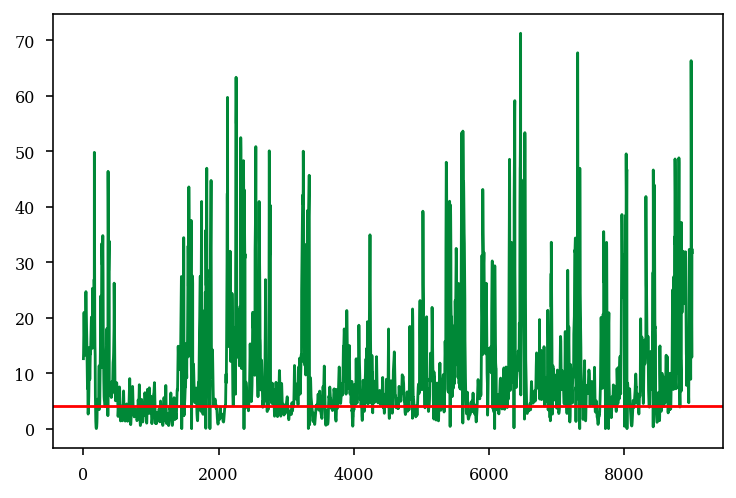

In [90]:
plt.plot(speed1.data[0])
plt.axhline(4,color='r')


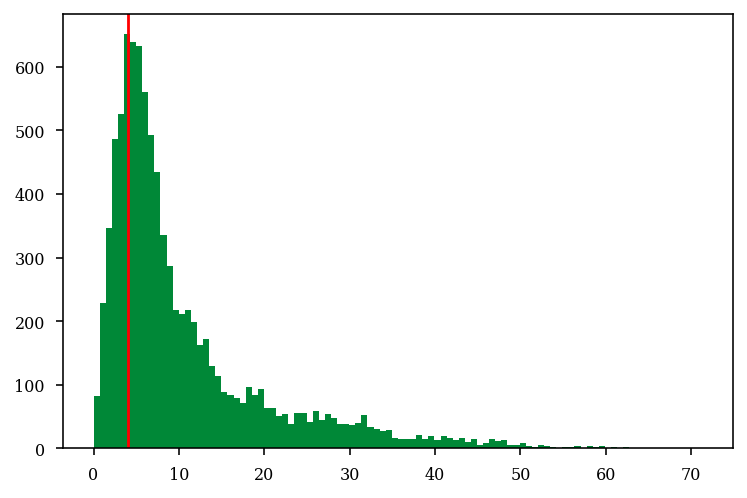

In [88]:
plt.hist(speed1.data[0],100)
plt.axvline(4,color='r')
plt.show()

In [62]:
st_run.n_events

array([  2, 223,   1, 415, 189, 184,  93, 158, 232,   3,  17, 366, 290,
        79, 468, 128, 366,   2, 506, 288, 319,  14,  92,   2, 161,  96,
       115, 520,  45, 123,  48,  75, 215, 399, 192,  61,  10,  72,  18,
       183, 161, 304, 352, 410, 208,   6,  87, 484, 169,  34, 143, 176,
        15,   1,  21,   2,  10,  51,   3,   1, 237, 115,   9, 237, 255,
       203,  11,  27,  30, 355, 201,   0,   9, 108, 108,  68, 538, 287,
       340, 473, 139,  17,  10, 204, 131,  18, 163])

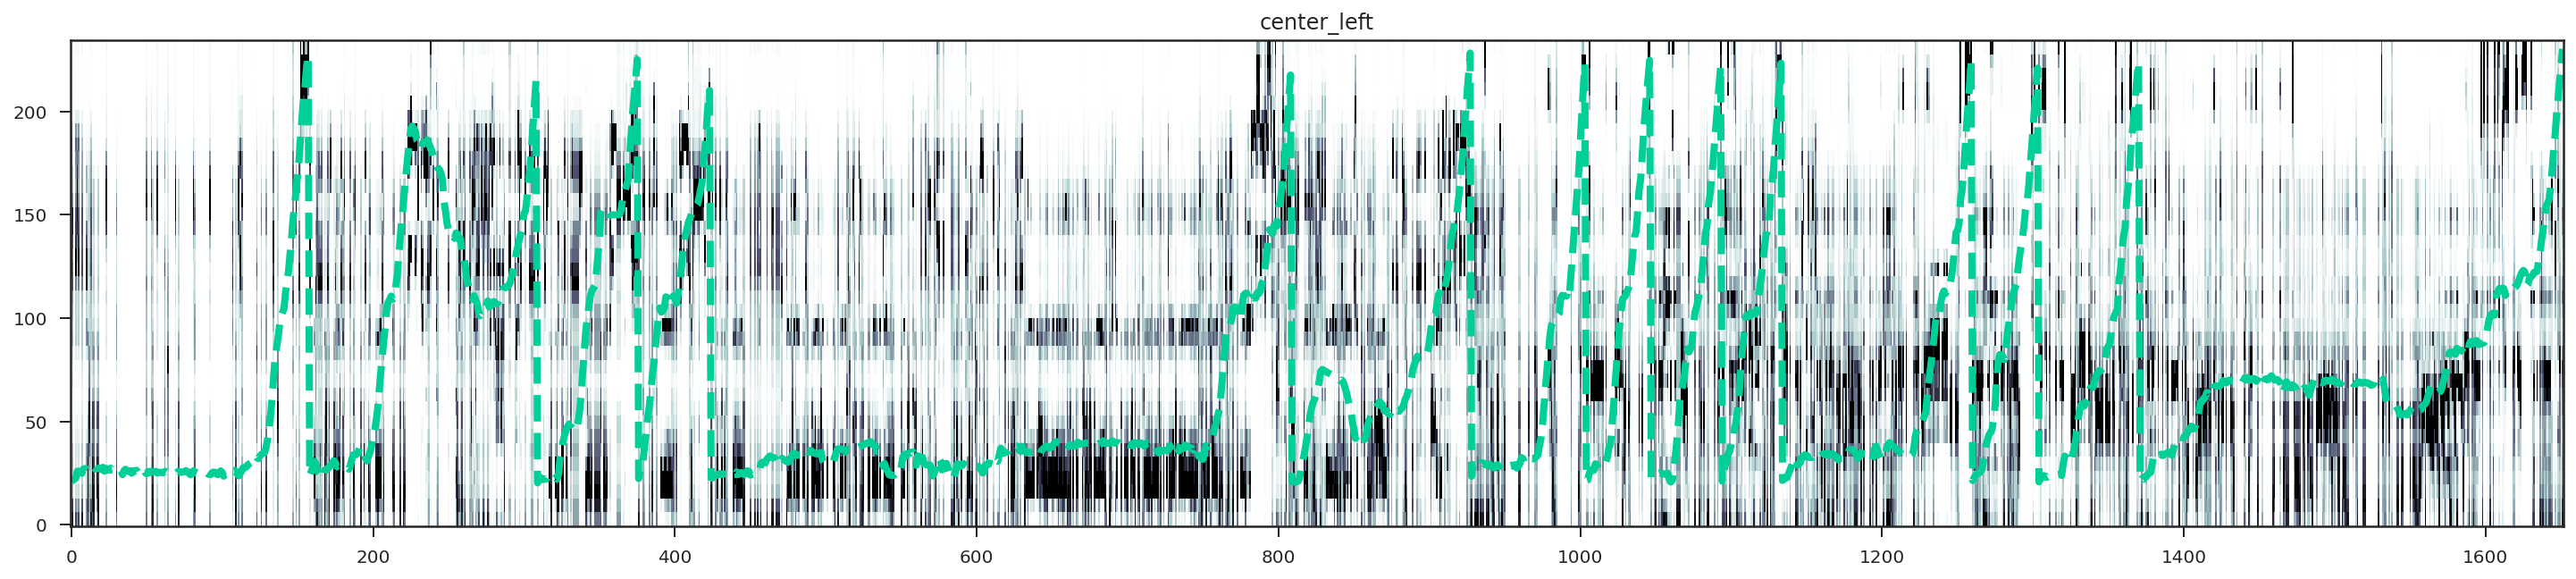

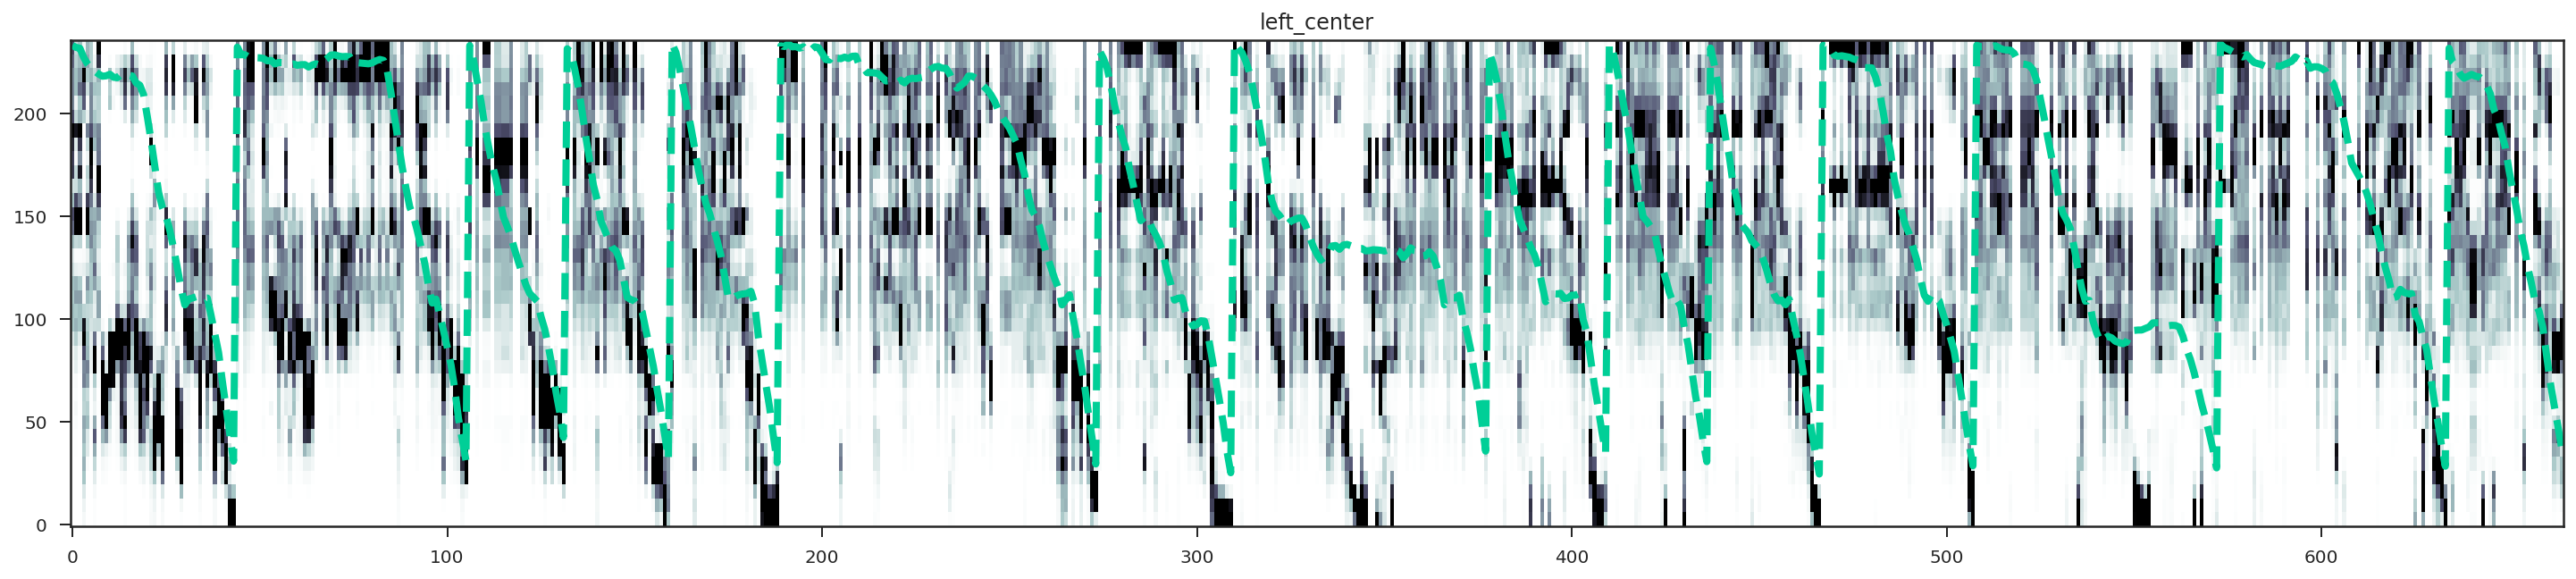

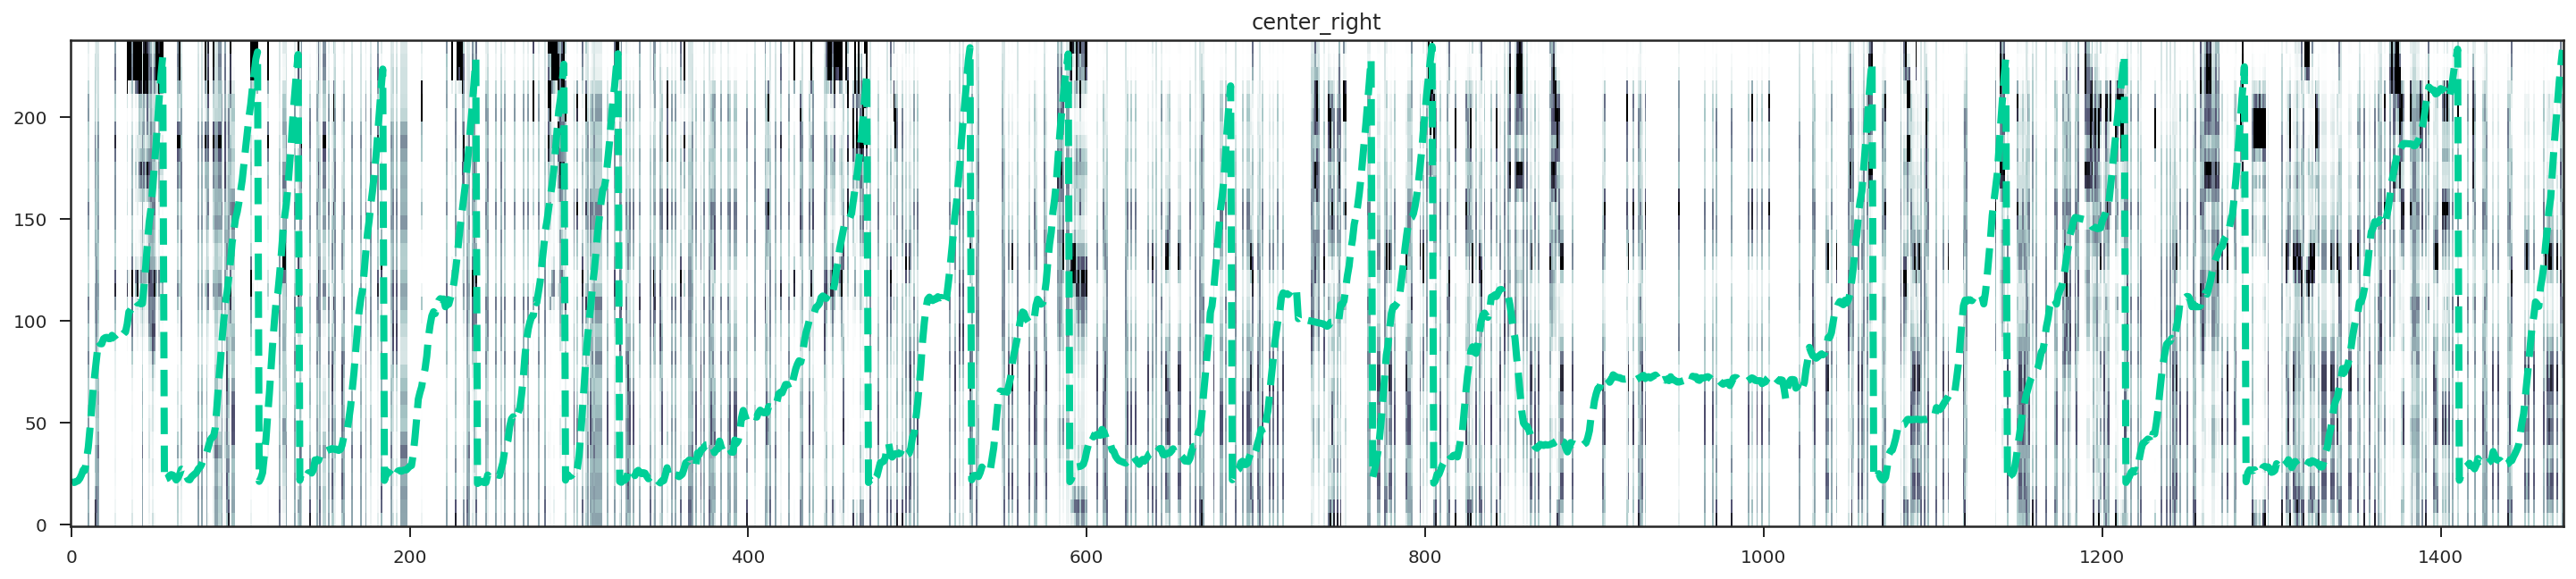

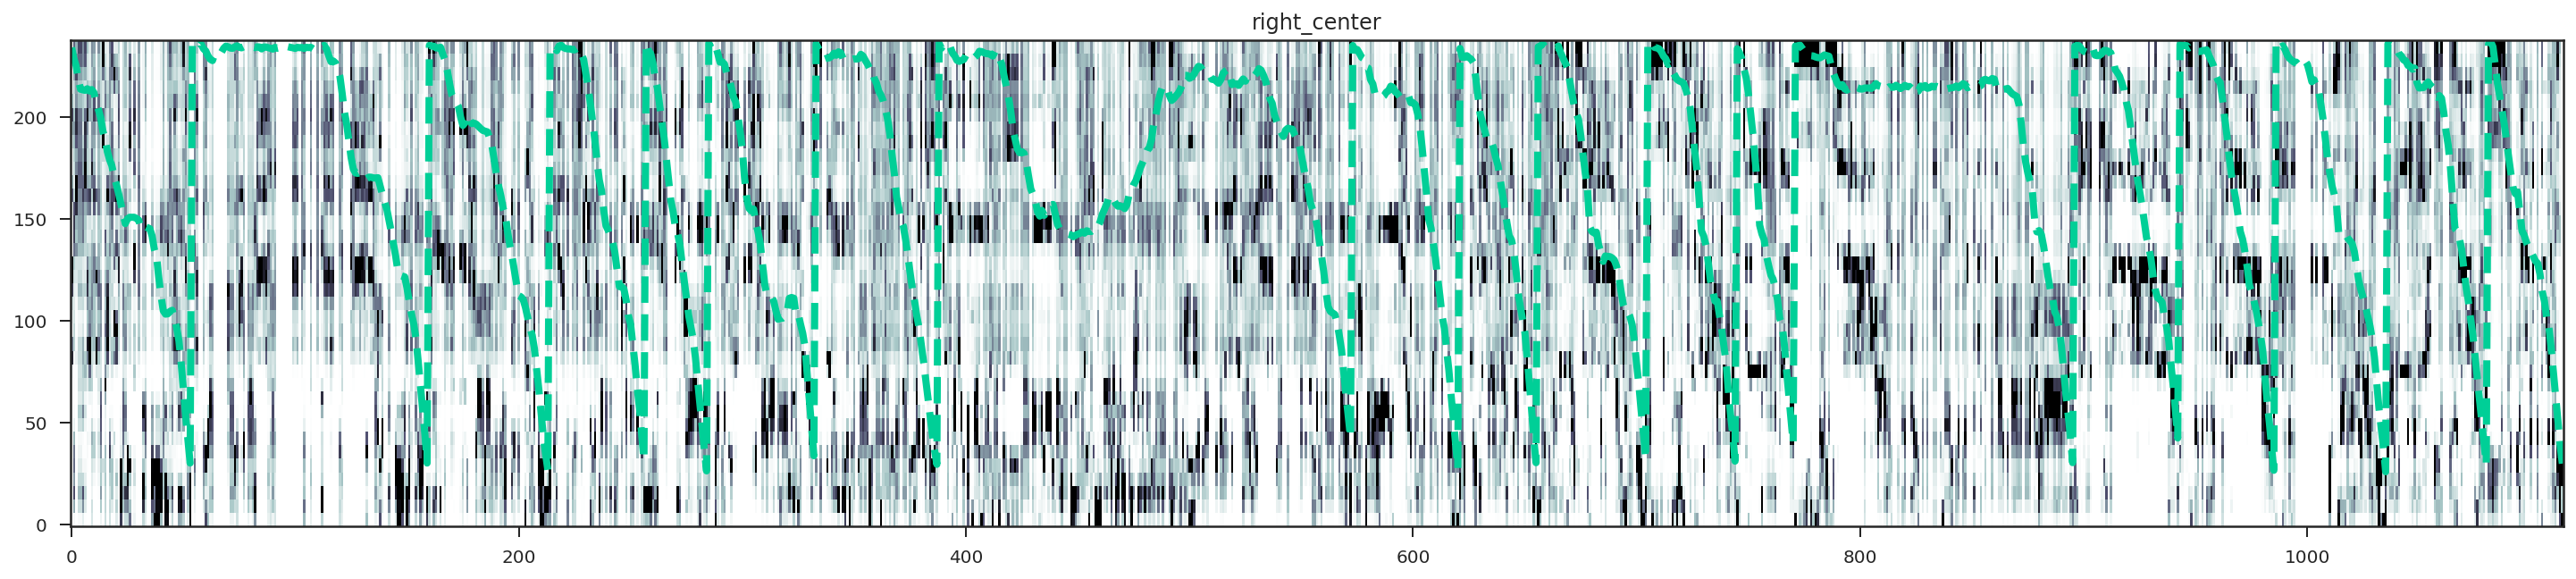

In [65]:
from nelpy.plotting.core import imagesc

# traj_shuff=1500  # number of shuffles to determine sig replay
# behav_shuff=250  # number of shuffles to determine sig decoding
# ds_50ms=0.05  # bin width to bin st for tuning curve
# s_binsize=3  # spatial bins in tuning curve
# speed_thres=4  # running threshold to determine tuning curves
# min_rip_dur=0.08  # min ripple duration for replay
# place_cell_min_rate=1  # min peak rate of tuning curve
# place_cell_min_spks=100  # at least 100 spikes while running above speed_thres
# place_cell_peak_mean_ratio=0  # peak firing rate / mean firing rate
# replay_binsize=0.02  # bin size to decode replay
# tuning_curve_sigma=3 
# ds_beh_decode=0.2

for traj in trajectories.keys():

    tc, st_run, bst_run = wmaze_replay.get_tuning_curves(
        pos, st_all, trajectories[traj], speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
    )
    (
        sta_placecells,
        tc,
        bst_run,
        cell_metrics_,
        total_units,
    ) = wmaze_replay.restrict_to_place_cells(
        tc,
        st_run,
        bst_run,
        st_all,
        cell_metrics,
        place_cell_min_spks,
        place_cell_min_rate,
        place_cell_peak_mean_ratio,
    )
    bst_run_beh = sta_placecells[trajectories[traj]].bin(ds=ds_beh_decode)

    posteriors, lengths, mode_pth, mean_pth = nel.decoding.decode1D(
        bst_run_beh, tc, xmin=np.nanmin(pos.data), xmax=np.nanmax(pos.data)
    )

    fig = plt.figure(figsize=(25, 5))
    ax = plt.gca()
    n_ext, n_bins = posteriors.shape
    imagesc(
        x=np.arange(n_bins),
        y=np.arange(int(tc.bins[-1] + 1)),
        data=posteriors,
        cmap="bone_r",
        ax=ax,
        vmax=0.1,
    )

    plt.plot(pos(bst_run_beh.bin_centers), "#00cf97", linewidth=4, linestyle="--")
    plt.title(traj)

    plt.show()

<AxesSubplot:>

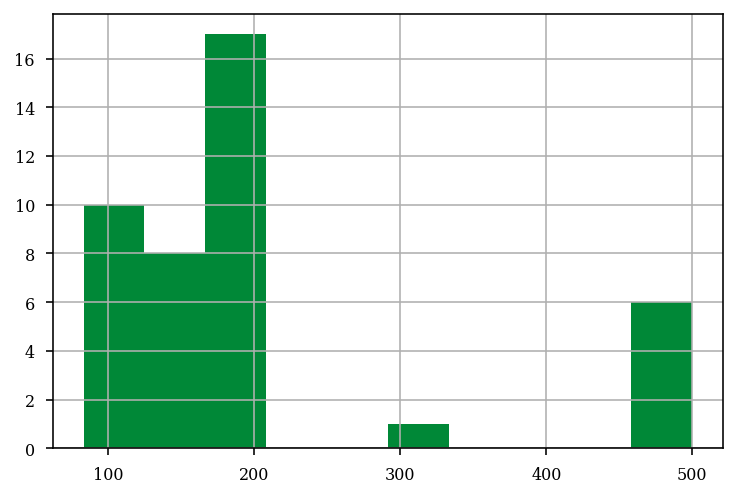

In [17]:
cell_metrics_.deepSuperficialDistance.hist()

## Testing below

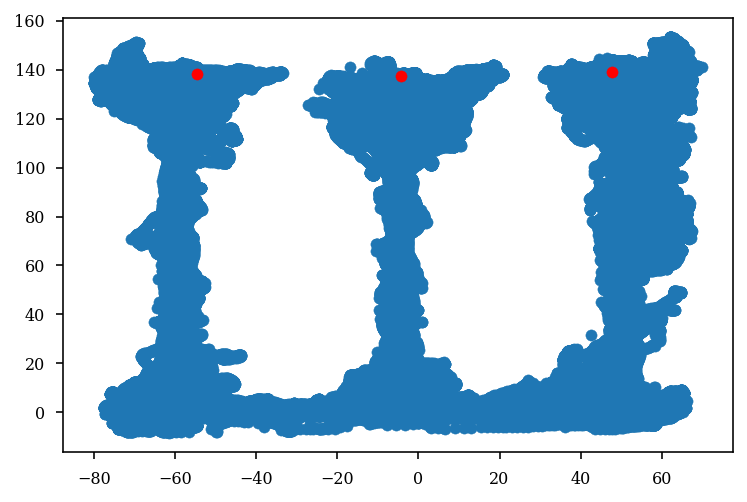

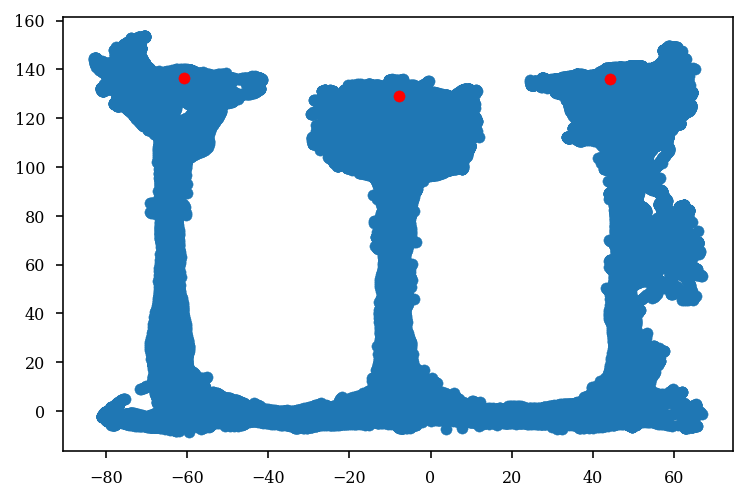

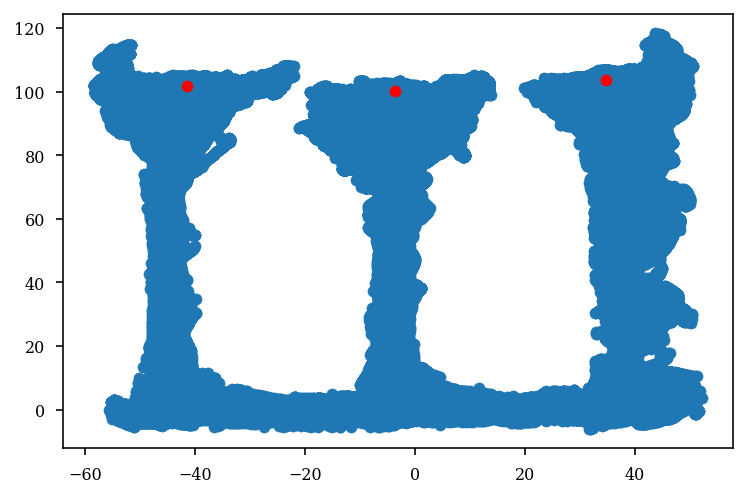

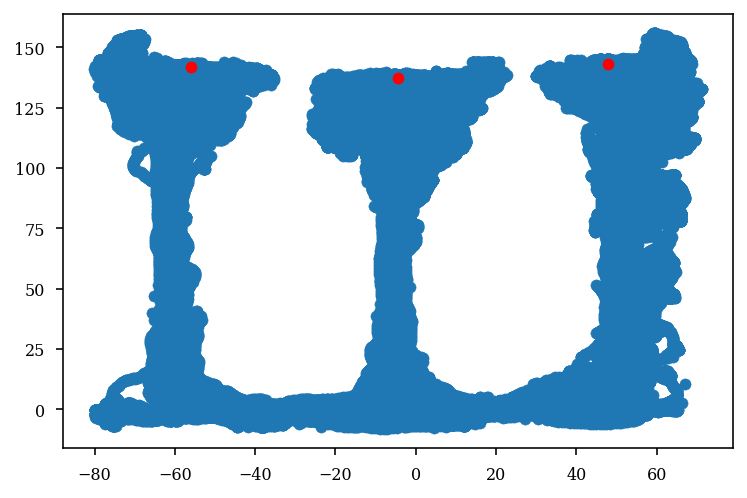

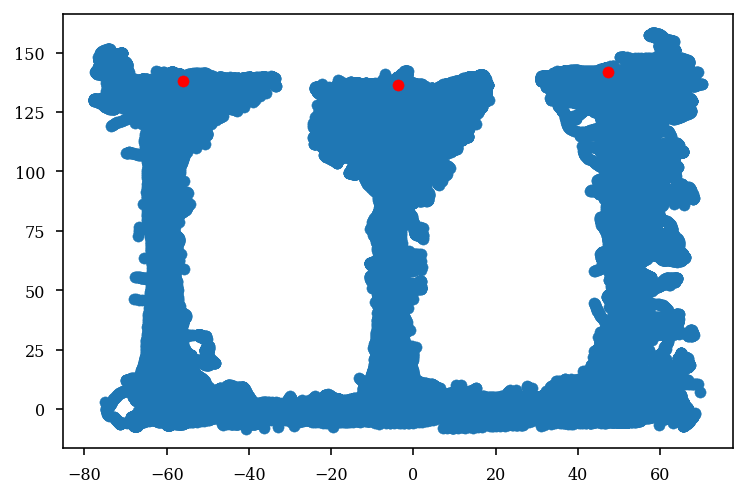

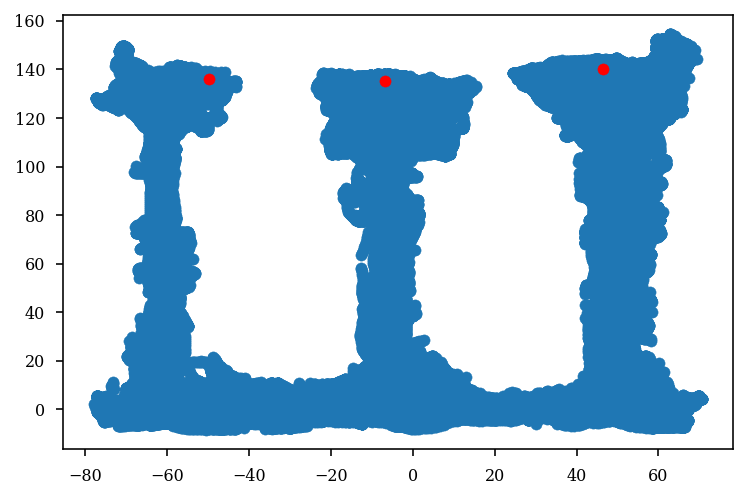

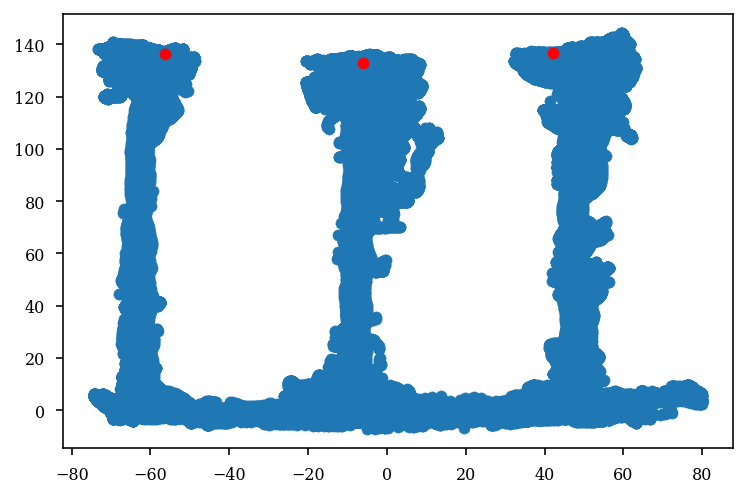

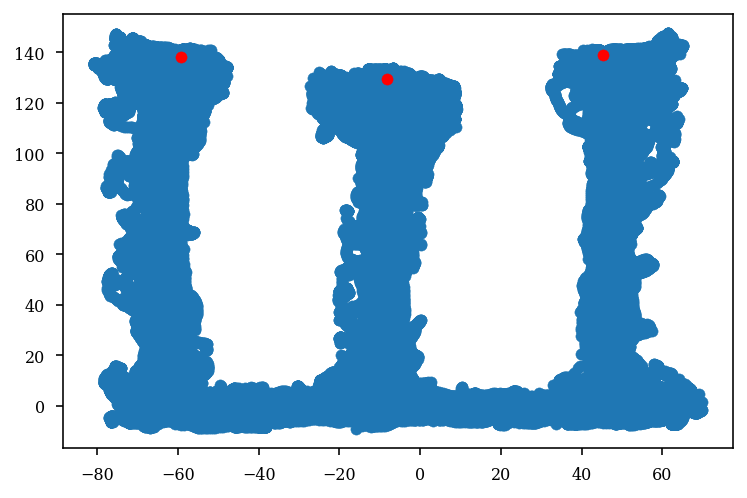

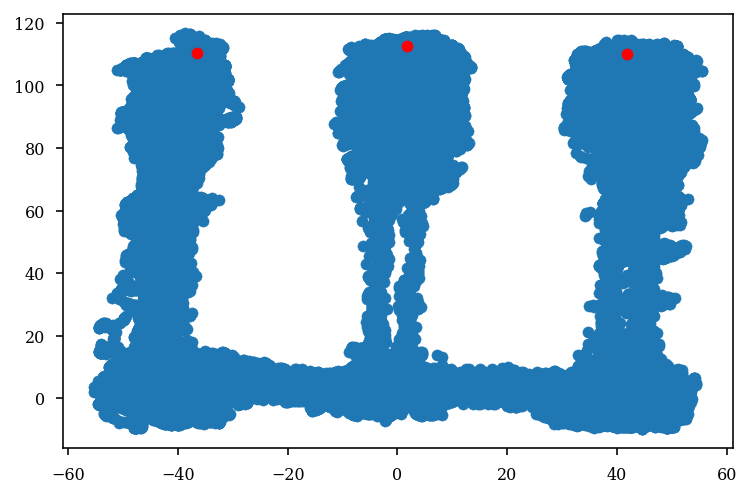

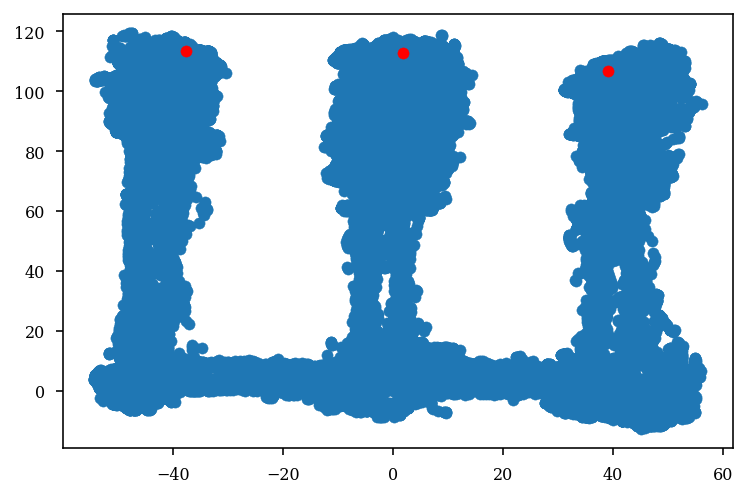

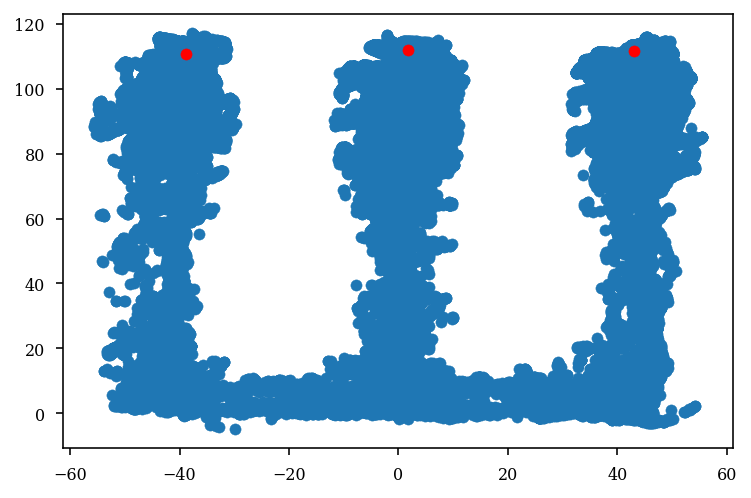

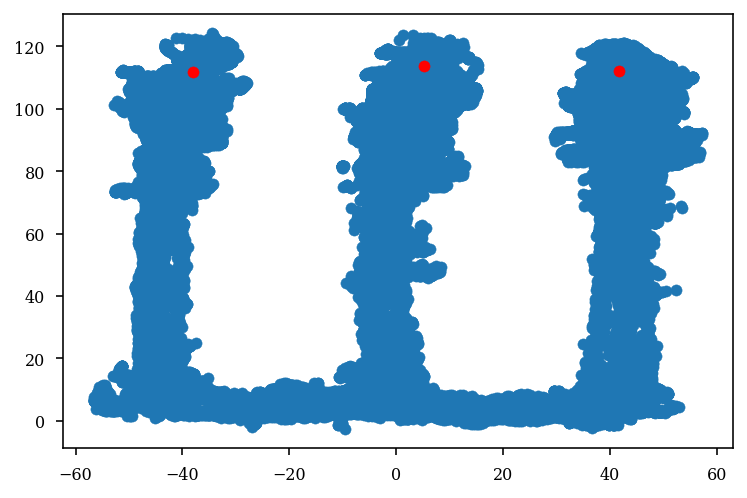

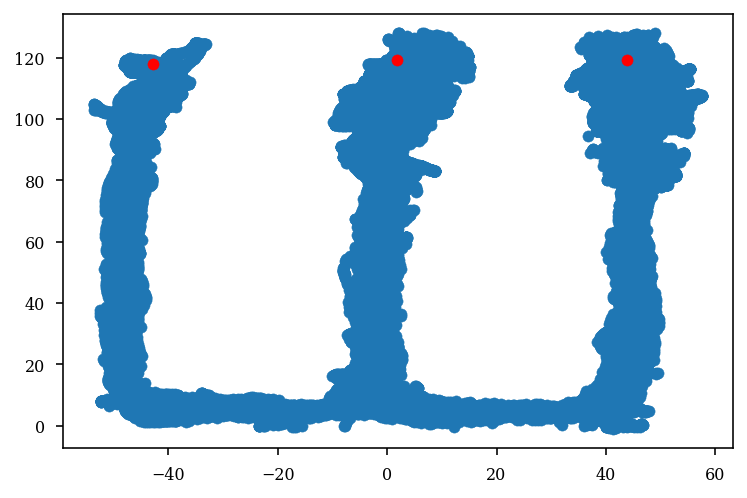

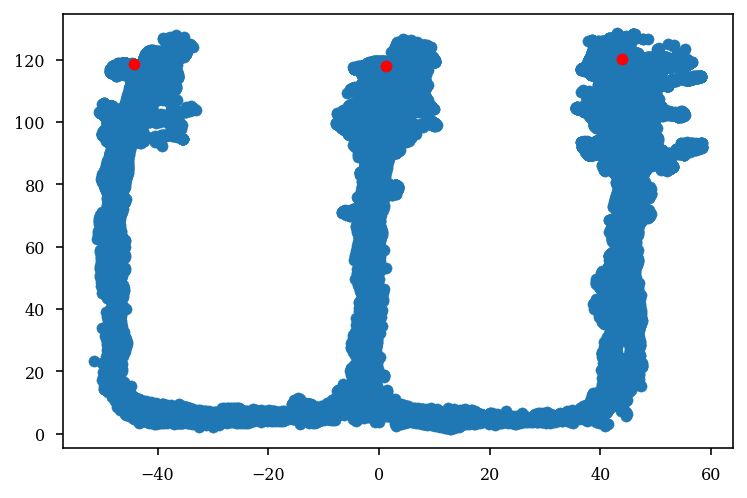

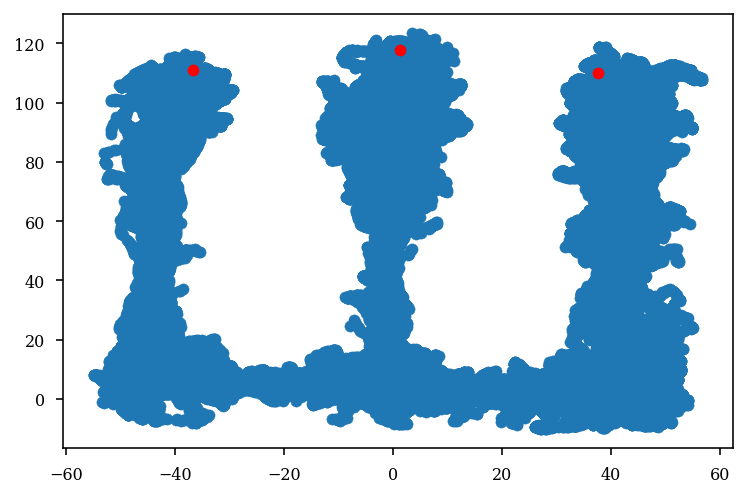

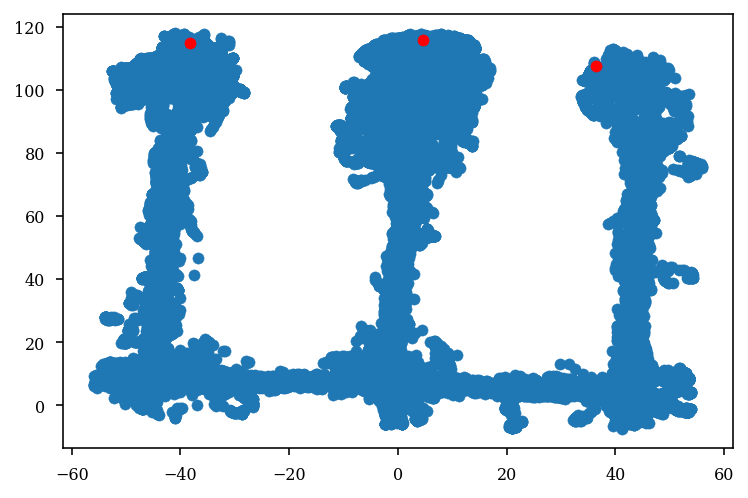

In [68]:
for basepath in df.basepath:
    position_df = loading.load_animal_behavior(basepath)
    if position_df is None:
        continue
    well_locations = np.array(
        [
            [
                position_df.query("states == 0").projected_x.mean(),
                position_df.query("states == 0").projected_y.max(),
            ],
            [
                position_df.query("states == 2").projected_x.mean(),
                position_df.query("states == 2").projected_y.max(),
            ],
            [
                position_df.query("states == 1").projected_x.mean(),
                position_df.query("states == 1").projected_y.max(),
            ],
        ]
    )

    plt.scatter(position_df.x,position_df.y)
    plt.scatter(well_locations[:,0],well_locations[:,1],c='r')
    plt.show()

In [3]:
from ripple_heterogeneity.replay import wmaze_replay
basepath = r"Z:\Data\ORproject\OR15\day1"
results = wmaze_replay.run(basepath,traj_shuff=10)

In [17]:
results.keys()

dict_keys(['center_left', 'left_center', 'center_right', 'right_center'])

In [60]:
results['center_left']['df']

start        stop  duration  n_active  inactive_bin_prop  \
1     1056.1804   1056.3772    0.1968         7           0.444444   
8     1521.3684   1521.5676    0.1992         6           0.444444   
13    1724.9404   1725.1500    0.2096         8           0.300000   
14    1867.7780   1867.9996    0.2216         7           0.181818   
17    1985.4908   1985.6860    0.1952         6           0.444444   
..          ...         ...       ...       ...                ...   
937  19149.3732  19149.5732    0.2000         5           0.444444   
938  19162.3324  19162.5524    0.2200         5           0.454545   
951  19349.4980  19349.7252    0.2272         5           0.272727   
953  19376.7052  19376.8908    0.1856         6           0.444444   
956  19410.8660  19411.0996    0.2336         5           0.363636   

     trajectory_score  r_squared      slope      intercept  \
1            0.079789   0.469108 -43.982979     408.136170   
8            0.063504   0.369699  36.215175    -348.940988   
13           0.113349   0.369468  23.446809    -402.522796   
14           0.175057   0.114421  -9.756028     374.825532   
17           0.055334   0.538432 -32.645524    1604.390205   
..                ...        ...        ...            ...   
937          0.132641   0.018954   3.234043   -8824.408511   
938          0.065534   0.095878  -7.946505   22305.561094   
951          0.096342   0.047102   8.878168  -24622.125491   
953          0.118144   0.004426   4.527660  -12497.634043   
956          0.145225   0.782816  36.498480 -102564.425532   

     score_pval_time_swap  score_pval_col_cycle   traj_dist   traj_speed  \
1                0.818182              0.818182  175.931915  2199.148936   
8                0.363636              0.818182  217.291048  1810.758731   
13               0.363636              0.363636  140.680851  1172.340426   
14               0.272727              0.090909   78.048227   487.801418   
17               0.909091              0.636364  195.873143  1632.276194   
..                    ...                   ...         ...          ...   
937              0.363636              0.090909   19.404255   161.702128   
938              1.000000              0.363636   47.679027   397.325228   
951              0.363636              0.545455   71.025342   443.908389   
953              0.090909              0.454545   18.110638   226.382979   
956              0.181818              0.090909  218.990881  1824.924012   

     traj_step replay_type  
1    43.982979     reverse  
8    54.322762     forward  
13   23.446809     forward  
14    9.756028     reverse  
17   48.968286     reverse  
..         ...         ...  
937   4.851064     forward  
938   9.535805     reverse  
951  10.146477     forward  
953   4.527660     forward  
956  36.498480     forward  

[294 rows x 15 columns]

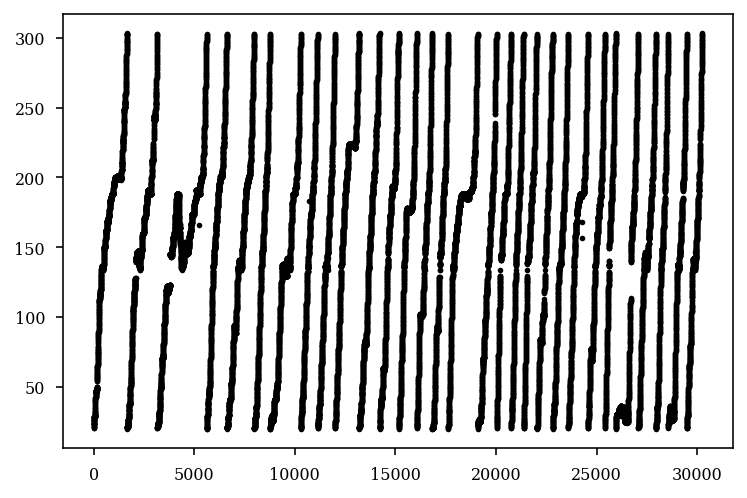

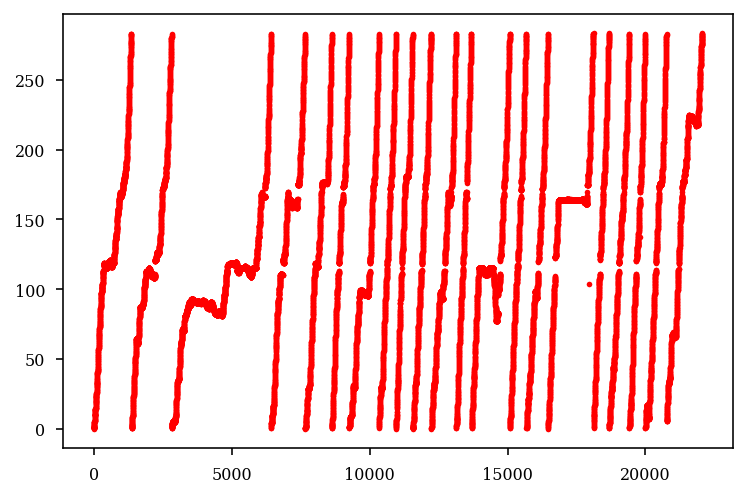

In [34]:
plt.plot(results['center_left']['pos'].data[0],'.k')
plt.show()

plt.plot(results['left_center']['pos'].data[0],'.r')
plt.show()

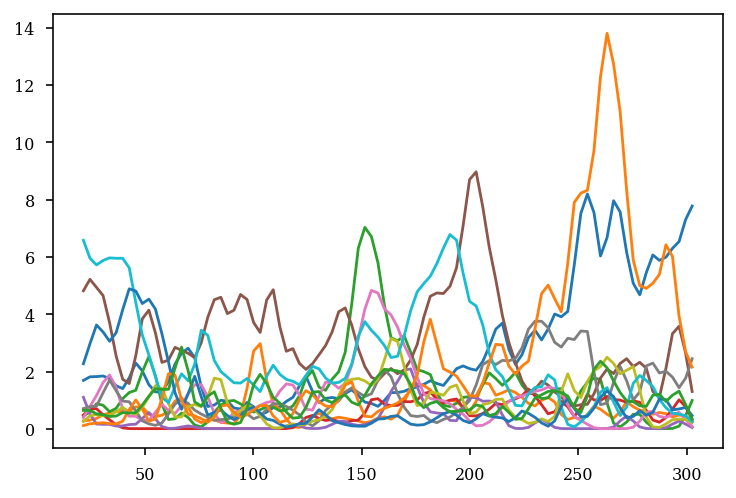

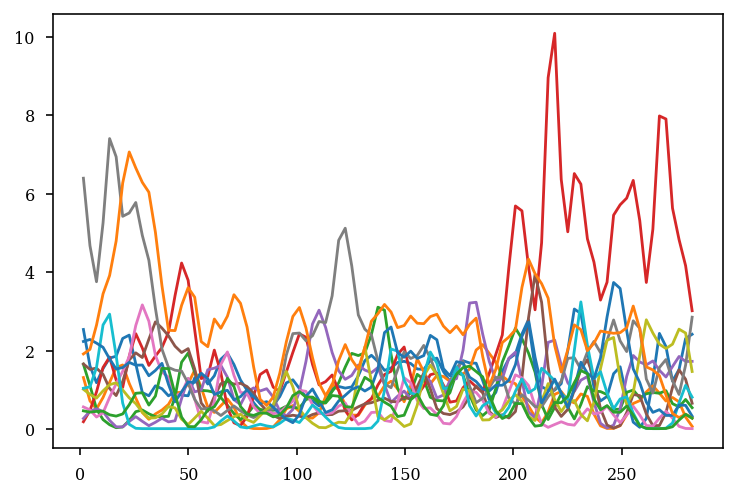

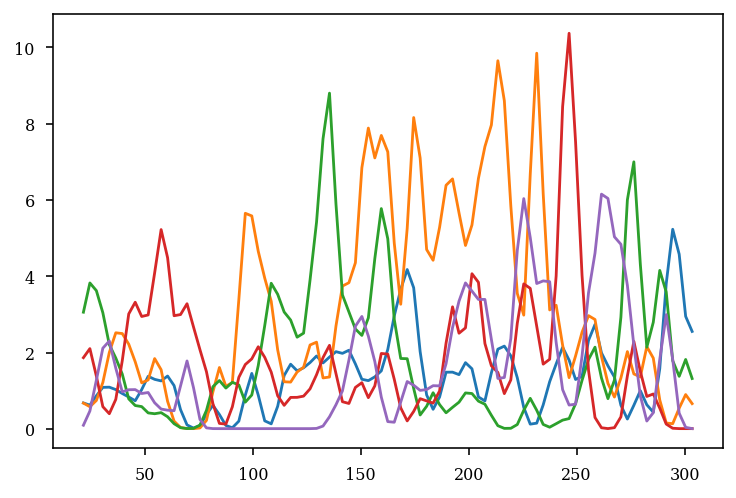

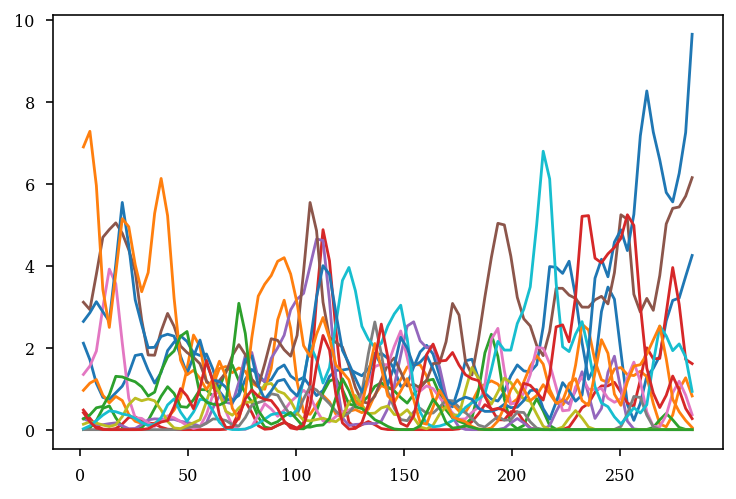

In [43]:
plt.plot(results['center_left']['tc'].bin_centers, results['center_left']['tc'].ratemap.T)
plt.show()

plt.plot(results['left_center']['tc'].bin_centers,results['left_center']['tc'].ratemap.T)
plt.show()

plt.plot(results['center_right']['tc'].bin_centers,results['center_right']['tc'].ratemap.T)
plt.show()

plt.plot(results['right_center']['tc'].bin_centers, results['right_center']['tc'].ratemap.T)
plt.show()

In [49]:
tc_.unit_ids

[24, 11, 26, 4, 8, 7, 12, 15, 5, 17, 28, 2, 9, 22]

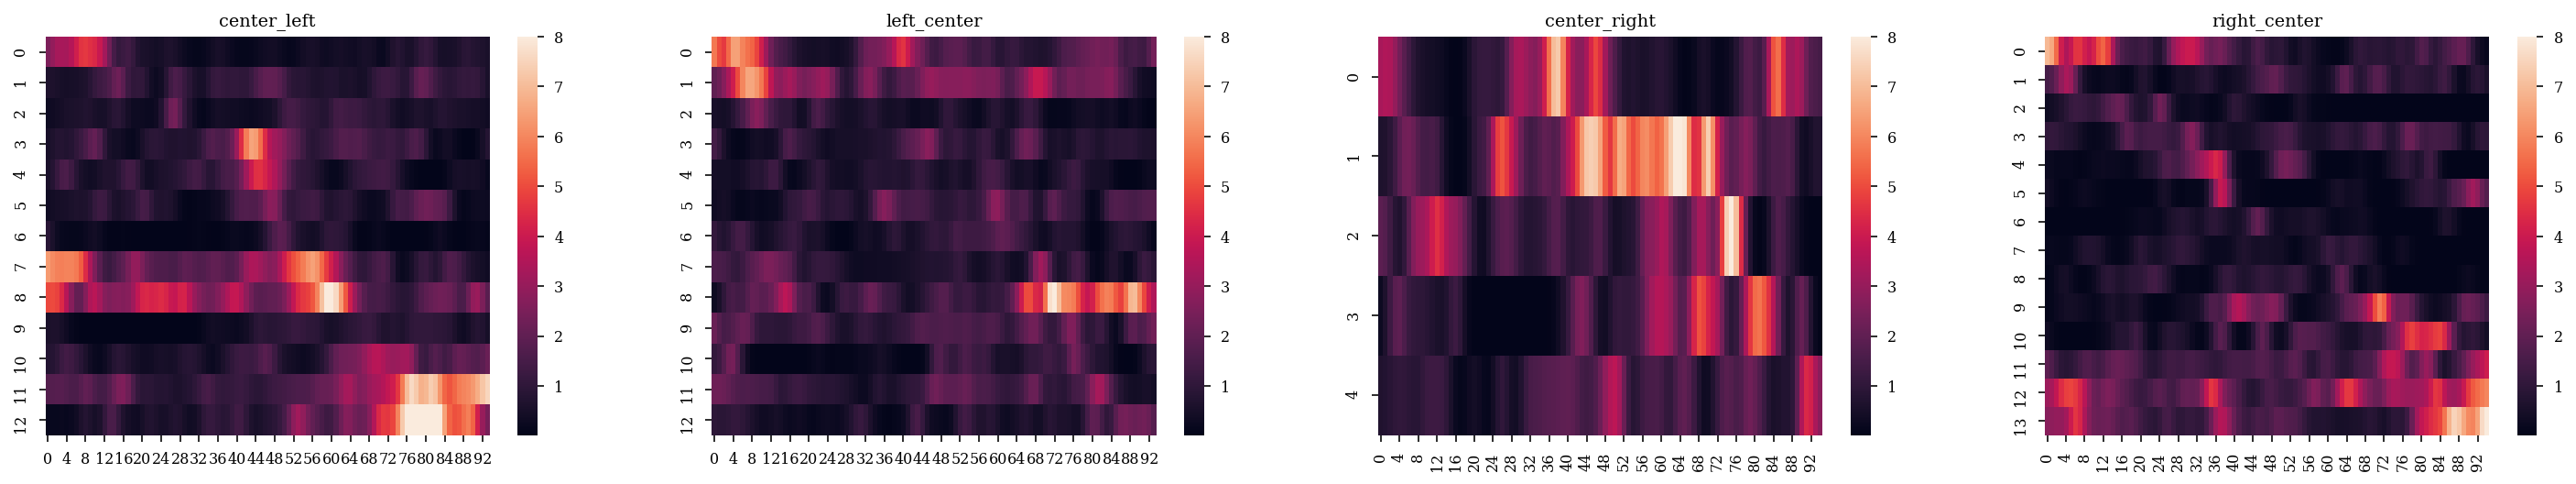

In [52]:
fig,ax = plt.subplots(1,4,figsize=(25,4))
for traj_label_i, traj_label in enumerate(results.keys()):
    tc_ = results[traj_label]['tc'].reorder_units()
    tc_ = tc_.smooth(sigma=3)
    sns.heatmap(tc_.ratemap,vmax=8,ax=ax[traj_label_i])
    ax[traj_label_i].set_title(traj_label)

In [149]:
from ripple_heterogeneity.replay import wmaze_replay
basepath = r"Z:\Data\ORproject\OR15\day1"
max_distance_from_well=20  # in cm, max distance from well to consider a well traversal
min_distance_traveled=50

position_df = loading.load_animal_behavior(basepath)

# remove nan values
bad_idx = np.isnan(position_df.linearized)
position_df = position_df[~bad_idx]

pos = nel.AnalogSignalArray(
    data=np.array(position_df.linearized),
    timestamps=position_df.time,
    fs=position_df.sr.iloc[0],
)
trajectories = wmaze_replay.get_w_maze_trajectories(
    position_df,
    max_distance_from_well=max_distance_from_well,
    min_distance_traveled=min_distance_traveled,
)
for con in trajectories.keys():
    x_slope = []
    for pos_seg in pos[trajectories[con]]:
        b1, _, _, _, _ = stats.linregress(np.arange(len(pos_seg.data[0])), pos_seg.data[0])
        x_slope.append(b1)
    if np.mean(np.array(x_slope) < 0) > .5:
        pos = wmaze_replay.flip_pos_within_epoch(pos, trajectories[con])


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversi

In [155]:
epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])
epoch_df
beh_epochs[epoch_df.environment == "wmaze"]

<EpochArray at 0x24194865e50: 2 epochs> of length 1:04:26:367 hours

In [135]:
trajectories

{"from_well == 'Center' & to_well == 'Left'": <EpochArray at 0x2418f809eb0: 30 epochs> of length 4:21:977 minutes,
 "from_well == 'Left' & to_well == 'Center'": <EpochArray at 0x2418f809e20: 21 epochs> of length 3:11:356 minutes,
 "from_well == 'Center' & to_well == 'Right'": <EpochArray at 0x2418f809d30: 12 epochs> of length 1:20:362 minutes,
 "from_well == 'Right' & to_well == 'Center'": <EpochArray at 0x2418f804250: 22 epochs> of length 4:41:634 minutes}

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


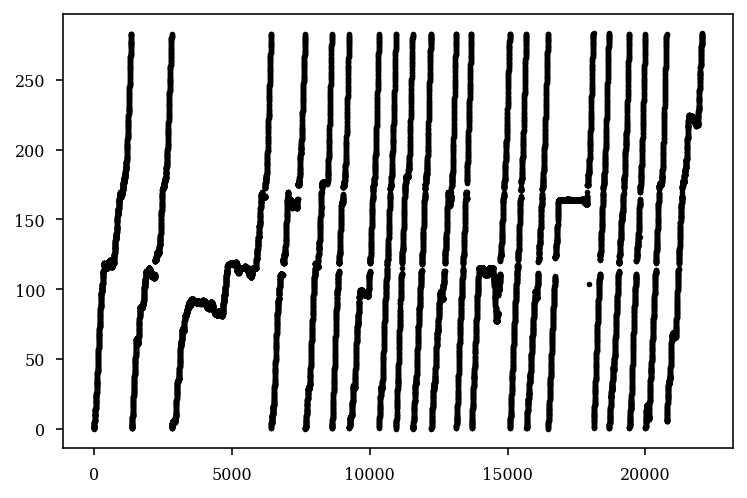

In [150]:
plt.plot(pos[trajectories["from_well == 'Left' & to_well == 'Center'"]].data[0],'.k')

In [144]:
x_slope = []
for pos_seg in pos[trajectories["from_well == 'Left' & to_well == 'Center'"]]:
    b1, _, _, _, _ = stats.linregress(np.arange(len(pos_seg.data[0])), pos_seg.data[0])
    x_slope.append(b1)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_ana

In [148]:

np.mean(np.array(x_slope) < 0) > .5

True

In [8]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv", index_col=0)

epoch_df = pd.DataFrame()
for basepath in df.basepath:
    temp_df = loading.load_epoch(basepath)
    temp_df["basepath"] = basepath
    epoch_df = pd.concat([epoch_df,temp_df],ignore_index=True)

In [15]:
epoch_df.environment.unique()

array(['sleep', 'linear', 'tmaze', 'cheeseboard', 'box', 'water',
       'unknown', 'open', 'linearOne', 'linearTwo', 'Tmaze', 'wheel',
       'bigSquare', 'Mwheel', 'plus', 'midSquare', 'bigSquarePlus',
       'wheel_home', 'circle', 'ZigZag', 'wmaze', 'test'], dtype=object)

In [19]:
import pickle

with open("Z:\Data\FujisawaS\EE\EE0622fm\linearization_nodes_edges.pkl", "rb") as f:
    results = pickle.load(f)

results

{'node_positions': array([[543.89884488, 282.53823713],
        [169.30034785, 245.91368425],
        [167.3727398 , 101.34308076],
        [538.11602074, 129.61466544],
        [175.08317199, 391.12682375],
        [538.75855676, 386.62907164]]),
 'edges': [[0, 1], [1, 2], [2, 3], [3, 0], [1, 4], [4, 5], [5, 0]]}

In [17]:
epoch_df.query("environment == 'tmaze'").basepath.unique()

array(['Z:\\Data\\AYAold\\AB3\\AB3_38_41',
       'Z:\\Data\\AYAold\\AB3\\AB3_42_46',
       'Z:\\Data\\AYAold\\AB3\\AB3_47_49',
       'Z:\\Data\\AYAold\\AB3\\AB3_50_51',
       'Z:\\Data\\AYAold\\AB3\\AB3_55_57',
       'Z:\\Data\\AYAold\\AB3\\AB3_60', 'Z:\\Data\\Kenji\\2006-4-18',
       'Z:\\Data\\AYAold\\AYA10\\day12',
       'Z:\\Data\\FujisawaS\\EE\\EE0622fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0627fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0705fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0706fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0708fm', 'Z:\\Data\\Can\\OML22\\day14',
       'Z:\\Data\\Can\\OML22\\day16', 'Z:\\Data\\Can\\OML22\\day18'],
      dtype=object)

In [87]:
basepath = r"Z:\Data\ORproject\OR15\day1"
position_df = loading.load_animal_behavior(basepath)
position_df

time   x   y        z  linearized units  projected_x  \
0          2.79925 NaN NaN  19.3239         NaN    cm          NaN   
1          2.80755 NaN NaN  19.3147         NaN    cm          NaN   
2          2.81590 NaN NaN  19.3118         NaN    cm          NaN   
3          2.82425 NaN NaN  19.2998         NaN    cm          NaN   
4          2.83255 NaN NaN  19.2957         NaN    cm          NaN   
...            ...  ..  ..      ...         ...   ...          ...   
455392  9890.38545 NaN NaN      NaN         NaN    cm          NaN   
455393  9890.39375 NaN NaN      NaN         NaN    cm          NaN   
455394  9890.40210 NaN NaN      NaN         NaN    cm          NaN   
455395  9890.41045 NaN NaN      NaN         NaN    cm          NaN   
455396  9890.41875 NaN NaN      NaN         NaN    cm          NaN   

        projected_y          sr  timestamps     speed  acceleration  states  \
0               NaN  119.760479     2.79925  5.304503      0.000000     NaN   
1               NaN  119.760479     2.80755  5.142359     -0.162144     NaN   
2               NaN  119.760479     2.81590  4.897786     -0.244573     NaN   
3               NaN  119.760479     2.82425  4.899227      0.001441     NaN   
4               NaN  119.760479     2.83255  4.660540     -0.238687     NaN   
...             ...         ...         ...       ...           ...     ...   
455392          NaN  119.760479  9890.38545       NaN           NaN     NaN   
455393          NaN  119.760479  9890.39375       NaN           NaN     NaN   
455394          NaN  119.760479  9890.40210       NaN           NaN     NaN   
455395          NaN  119.760479  9890.41045       NaN           NaN     NaN   
455396          NaN  119.760479  9890.41875       NaN           NaN     NaN   

                          epochs environment  
0       OR15day1_1_180116_095729       wmaze  
1       OR15day1_1_180116_095729       wmaze  
2       OR15day1_1_180116_095729       wmaze  
3       OR15day1_1_180116_095729       wmaze  
4       OR15day1_1_180116_095729       wmaze  
...                          ...         ...  
455392  OR15day1_2_180116_171020       wmaze  
455393  OR15day1_2_180116_171020       wmaze  
455394  OR15day1_2_180116_171020       wmaze  
455395  OR15day1_2_180116_171020       wmaze  
455396  OR15day1_2_180116_171020       wmaze  

[455397 rows x 15 columns]

In [120]:
from ripple_heterogeneity.utils import well_traversal_classification

well_locations = np.array(
    [
        [
            position_df.query("states == 0").projected_x.mean(),
            position_df.query("states == 0").projected_y.max(),
        ],
        [
            position_df.query("states == 2").projected_x.mean(),
            position_df.query("states == 2").projected_y.max(),
        ],
        [
            position_df.query("states == 1").projected_x.mean(),
            position_df.query("states == 1").projected_y.max(),
        ]
    ]
)
temp_df = position_df[~np.isnan(position_df.x)]
segments_df, labeled_segments = well_traversal_classification.segment_path(
    temp_df["timestamps"].values,
    temp_df[["projected_x", "projected_y"]].values,
    well_locations,
    max_distance_from_well=20,
)


segments_df = well_traversal_classification.score_inbound_outbound(segments_df, min_distance_traveled=50)
segments_df

start_time    end_time  duration from_well to_well  \
segment                                                       
2           8.17395    15.34020   7.16625     Right   Right   
3          77.42845    93.33595  15.90750     Right   Right   
16        115.53470   136.67520  21.14050     Right  Center   
21        170.67335   185.82255  15.14920    Center    Left   
22        193.75545   211.74610  17.99065      Left   Right   
...             ...         ...       ...       ...     ...   
304      9747.56820  9752.94290   5.37470    Center   Right   
305      9791.33250  9800.47365   9.14115     Right  Center   
306      9837.91330  9844.40460   6.49130    Center    Left   
311      9860.92870  9873.25305  12.32435      Left  Center   
312      9876.91115  9883.42750   6.51635    Center   Right   

         distance_traveled      task  is_correct   turn  
segment                                                  
2               164.260527   Inbound       False  Right  
3               355.907822   Inbound       False  Right  
16              506.015701   Inbound        True  Right  
21              347.573160  Outbound        True  Right  
22              461.307941   Inbound       False   Left  
...                    ...       ...         ...    ...  
304             331.989649  Outbound        True   Left  
305             348.570930   Inbound        True  Right  
306             333.651364  Outbound        True  Right  
311             337.705730   Inbound        True   Left  
312              78.072300  Outbound        True   Left  

[122 rows x 9 columns]

(8000.0, 10000.0)

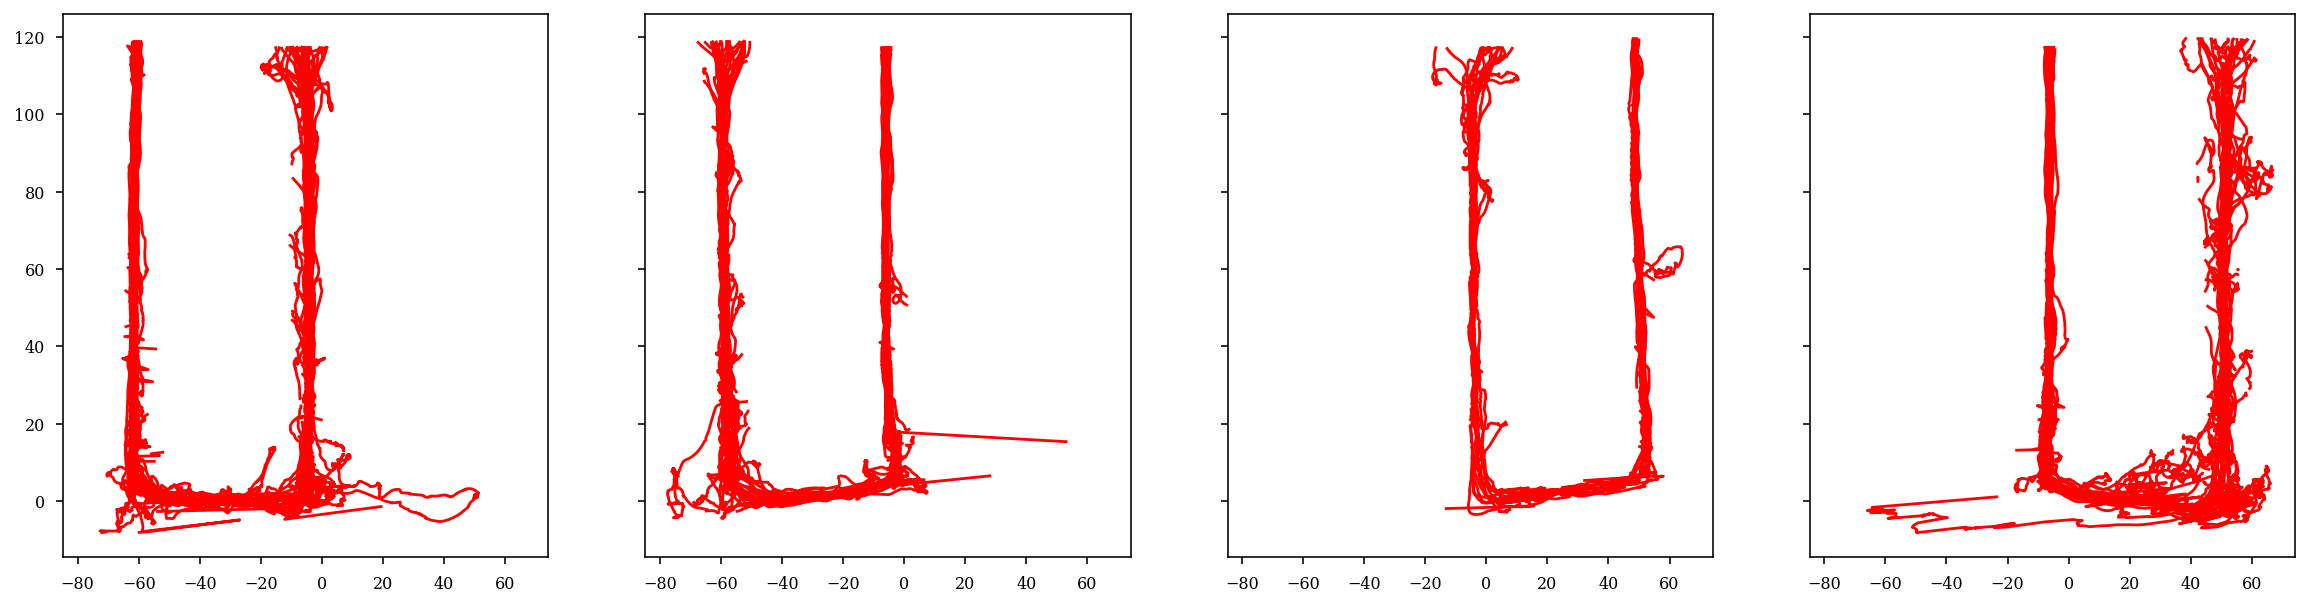

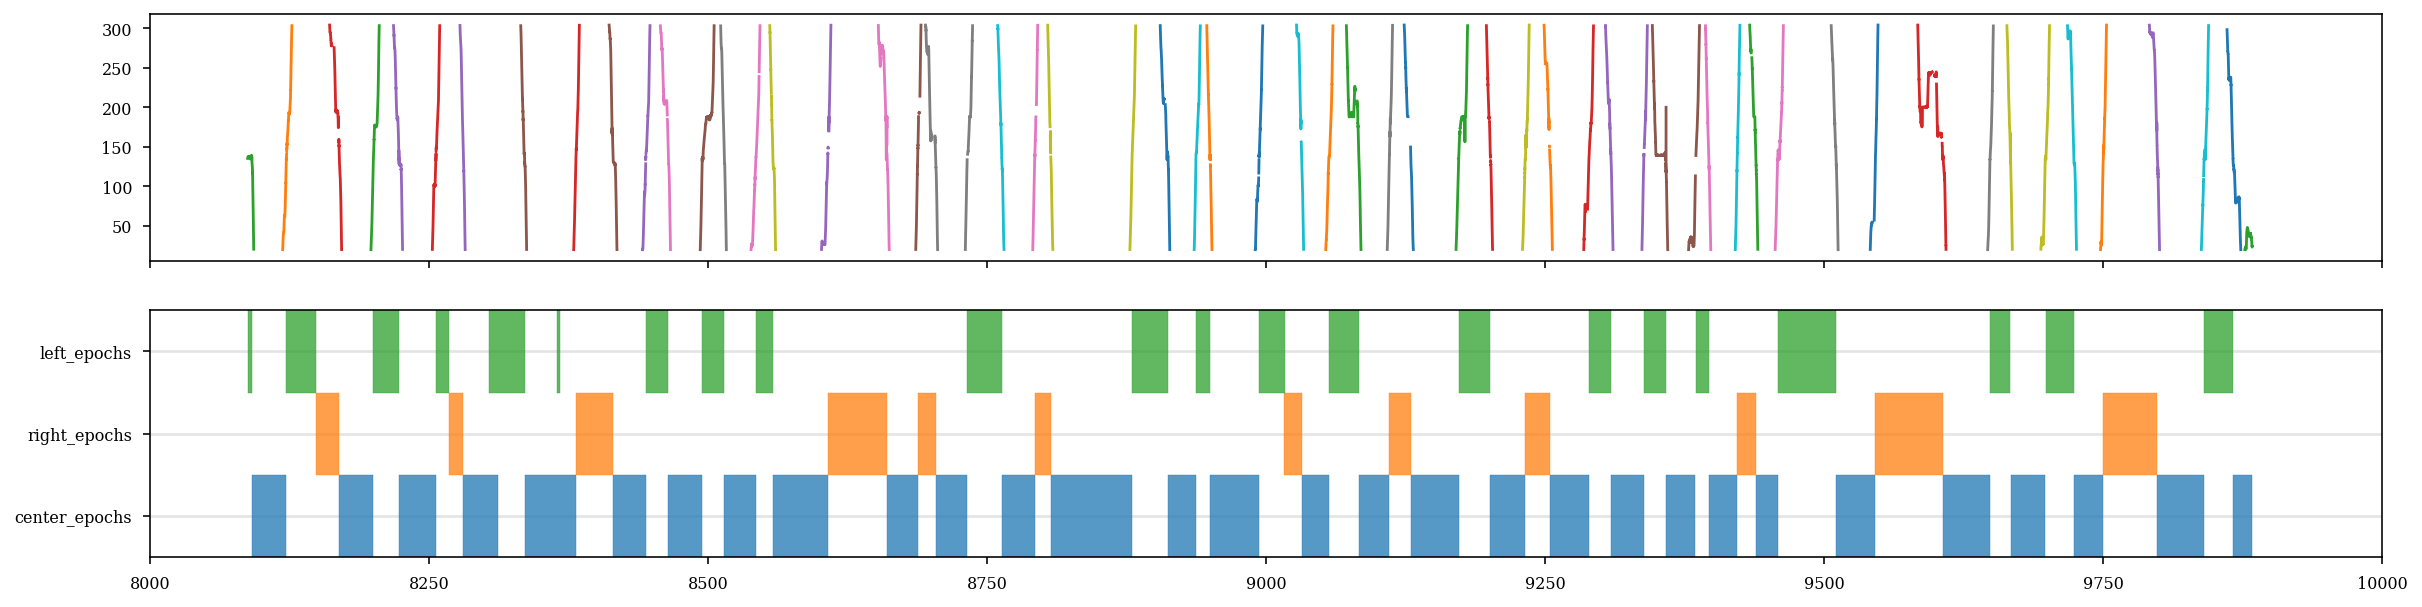

In [128]:
conditions = ["from_well == 'Center' & to_well == 'Left'",
"from_well == 'Left' & to_well == 'Center'",
"from_well == 'Center' & to_well == 'Right'",
"from_well == 'Right' & to_well == 'Center'"]

fig,ax = plt.subplots(1,4,figsize=(20, 5),sharey=True,sharex=True)
for con_i, con in enumerate(conditions):
    for ep in segments_df.query(con).itertuples():
        # position_df.timestamps.between_time(ep.start_time, ep.end_time)
        idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
        ax[con_i].plot(
            position_df[idx].x,
            position_df[idx].y,
            color="red"
        )

fig,axs = plt.subplots(2,1,figsize=(20, 5),sharey=False,sharex=True)
for con_i, con in enumerate(conditions):
    for ep in segments_df.query(con).itertuples():
        # position_df.timestamps.between_time(ep.start_time, ep.end_time)
        idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
        axs[0].plot(
            position_df[idx].timestamps,
            position_df[idx].linearized,
        )

# events.append(center_epochs)
# events.append(right_epochs)
# events.append(left_epochs)
custom_plots.plot_events(events,['center_epochs','right_epochs','left_epochs'],ax=axs[1])
axs[0].set_xlim(8000, 10000)


<AxesSubplot:xlabel='x', ylabel='y'>

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


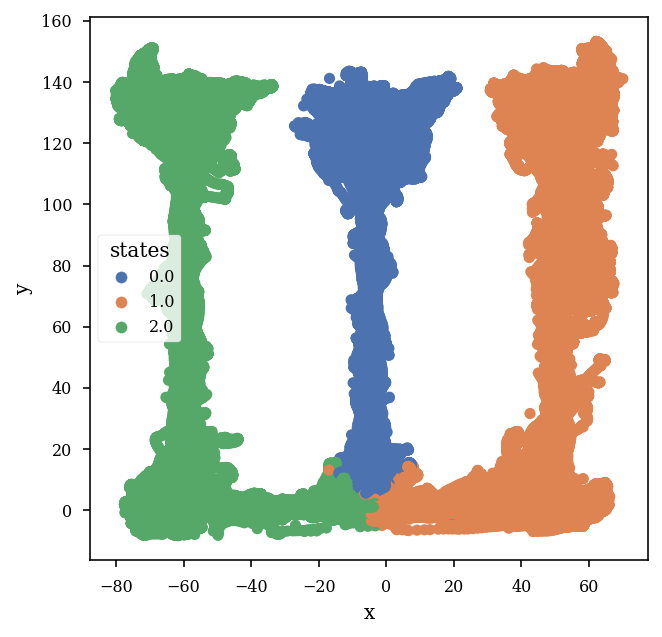

In [89]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="x",y="y",hue="states", data=position_df,palette="deep",linewidth=0)

<AxesSubplot:xlabel='timestamps', ylabel='linearized'>

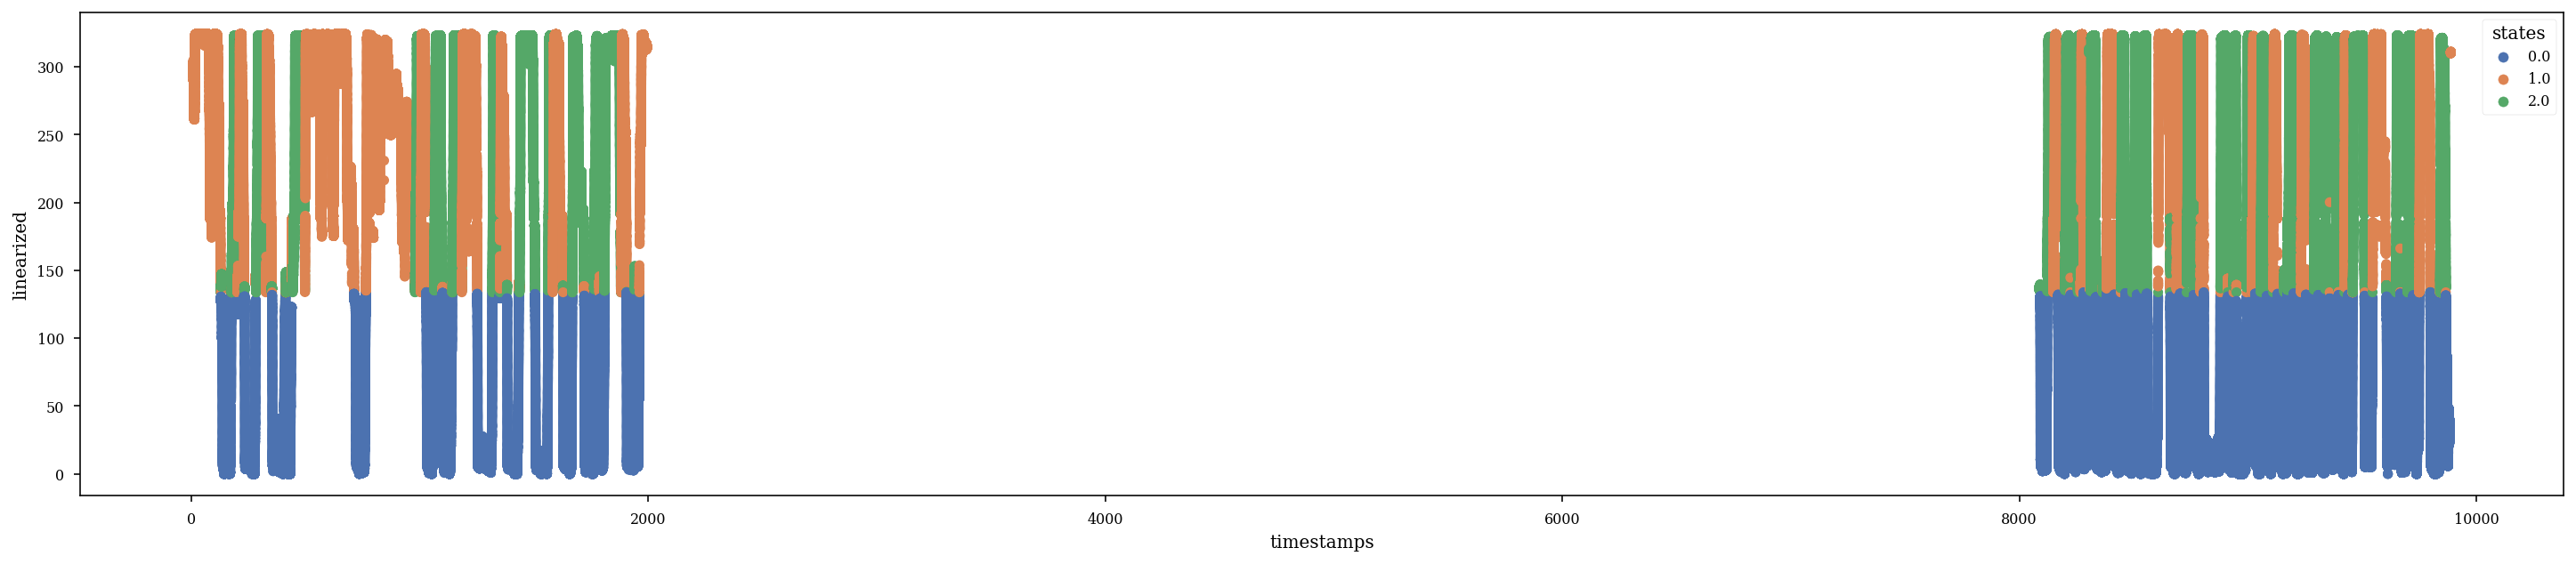

In [24]:
plt.figure(figsize=(25,5))
sns.scatterplot(x="timestamps",y="linearized",hue="states", data=position_df,palette="deep",linewidth=0)
# plt.xlim(0,500)

In [90]:
epochs_df = loading.load_epoch(basepath)
epochs = nel.EpochArray(np.array([epochs_df.startTime, epochs_df.stopTime]).T)
display(epochs_df)
epochs

name  startTime     stopTime environment
0       OR15day1_1_180116_095729      0.000   2001.59995       wmaze
1  OR15day1_sleep1_180116_110120   2001.600   8087.29195       sleep
2       OR15day1_2_180116_171020   8087.292   9952.05995       wmaze
3  OR15day1_sleep2_180116_181618   9952.060  19424.00000       sleep

<EpochArray at 0x2418bbef250: 4 epochs> of length 5:23:44 hours

In [91]:
bad_idx = np.isnan(position_df.linearized)
beh_df = position_df[~bad_idx]

pos = nel.AnalogSignalArray(
    data=np.array(position_df.linearized),
    timestamps=position_df.time,
    fs=position_df.sr.iloc[0],
)
pos = pos[epochs[2]]

ts = position_df.query("states==0").timestamps.values
center_epochs = nel.EpochArray(np.array([ts,ts]).T).merge(gap=1)

ts = position_df.query("states==1").timestamps.values
right_epochs = nel.EpochArray(np.array([ts,ts]).T).merge(gap=1)

ts = position_df.query("states==2").timestamps.values
left_epochs = nel.EpochArray(np.array([ts,ts]).T).merge(gap=1)

center_epochs = center_epochs[epochs[2]]
right_epochs = right_epochs[epochs[2]]
left_epochs = left_epochs[epochs[2]]

center_epochs._data = center_epochs.merge(gap=10).data[center_epochs.merge(gap=10).durations > 2]
right_epochs._data = right_epochs.merge(gap=10).data[right_epochs.merge(gap=10).durations > 2]
left_epochs._data = left_epochs.merge(gap=10).data[left_epochs.merge(gap=10).durations > 2]


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


In [93]:
import warnings
warnings.filterwarnings("ignore")
def find_good_laps(pos, dir_epoch, thres=0.5, binsize=6, min_laps=10):
    """
    find_good_laps: finds good laps in behavior data
        Made to find good laps in nelpy array for replay analysis
    input:
        pos: nelpy analog array with single dim
        dir_epoch: epoch to flip
        thres: occupancy threshold for good lap
        binsize: size of bins to calculate occupancy
    output:
        good_laps: epoch array of good laps
    """
    # make bin edges to calc occupancy
    x_edges = np.arange(np.nanmin(pos.data[0]), np.nanmax(pos.data[0]), binsize)
    # initialize occupancy matrix (position x time)
    occ = np.zeros([len(x_edges) - 1, dir_epoch.n_intervals])
    # iterate through laps
    for i, ep in enumerate(dir_epoch):
        # bin position per lap
        occ[:, i], _ = np.histogram(pos[ep].data[0], bins=x_edges)
    # calc percent occupancy over position bins per lap and find good laps
    good_laps = np.where(~((np.sum(occ == 0, axis=0) / occ.shape[0]) > thres))[0]
    # if no good laps, return empty epoch
    if (len(good_laps) == 0) | (len(good_laps) < min_laps):
        dir_epoch = nel.EpochArray()
    else:
        dir_epoch = dir_epoch[good_laps]
    return dir_epoch

(outbound_epochs, inbound_epochs) = functions.get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)
outbound_epochs = find_good_laps(pos, outbound_epochs)
inbound_epochs = find_good_laps(pos, inbound_epochs)
outbound_epochs, inbound_epochs

(<EpochArray at 0x1d46d75d550: 29 epochs> of length 11:47:344 minutes,
 <EpochArray at 0x1d463e56850: 29 epochs> of length 17:25:443 minutes)

In [94]:
center_right,center_epochs,right_epochs

(<EpochArray at 0x1d46386da30: 34 epochs> of length 47:10:461 minutes,
 <EpochArray at 0x1d463f878b0: 35 epochs> of length 16:15:205 minutes,
 <EpochArray at 0x1d463aa0190: 44 epochs> of length 5:15:074 minutes)

In [110]:
(center_epochs | right_epochs).merge(), (center_epochs + right_epochs)


(<EpochArray at 0x1d45e98f0d0: 77 epochs> of length 21:29:846 minutes,
 <EpochArray at 0x1d45e98fb50: 79 epochs> of length 21:29:846 minutes)

In [189]:
# right_epochs._data

# _data
right_epochs._data = right_epochs.merge(gap=10).data[right_epochs.merge(gap=10).durations > 2]

In [190]:
right_epochs

<EpochArray at 0x1d463aa0190: 12 epochs> of length 5:33:840 minutes

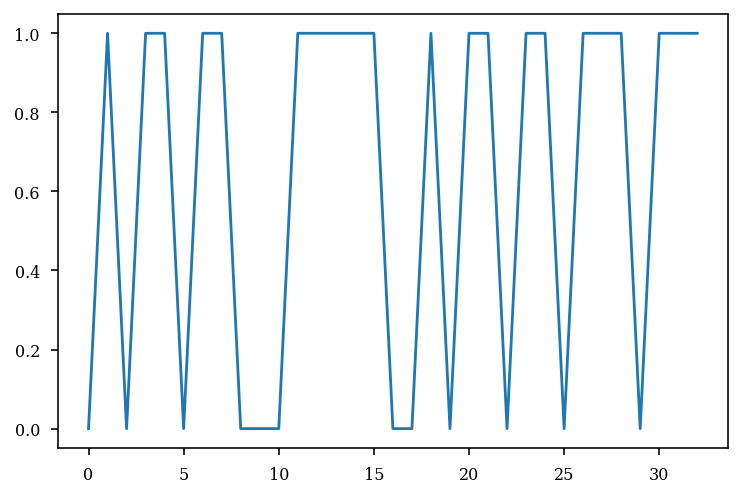

In [187]:
plt.plot(right_epochs.merge(gap=10).durations > 2)
plt.show()

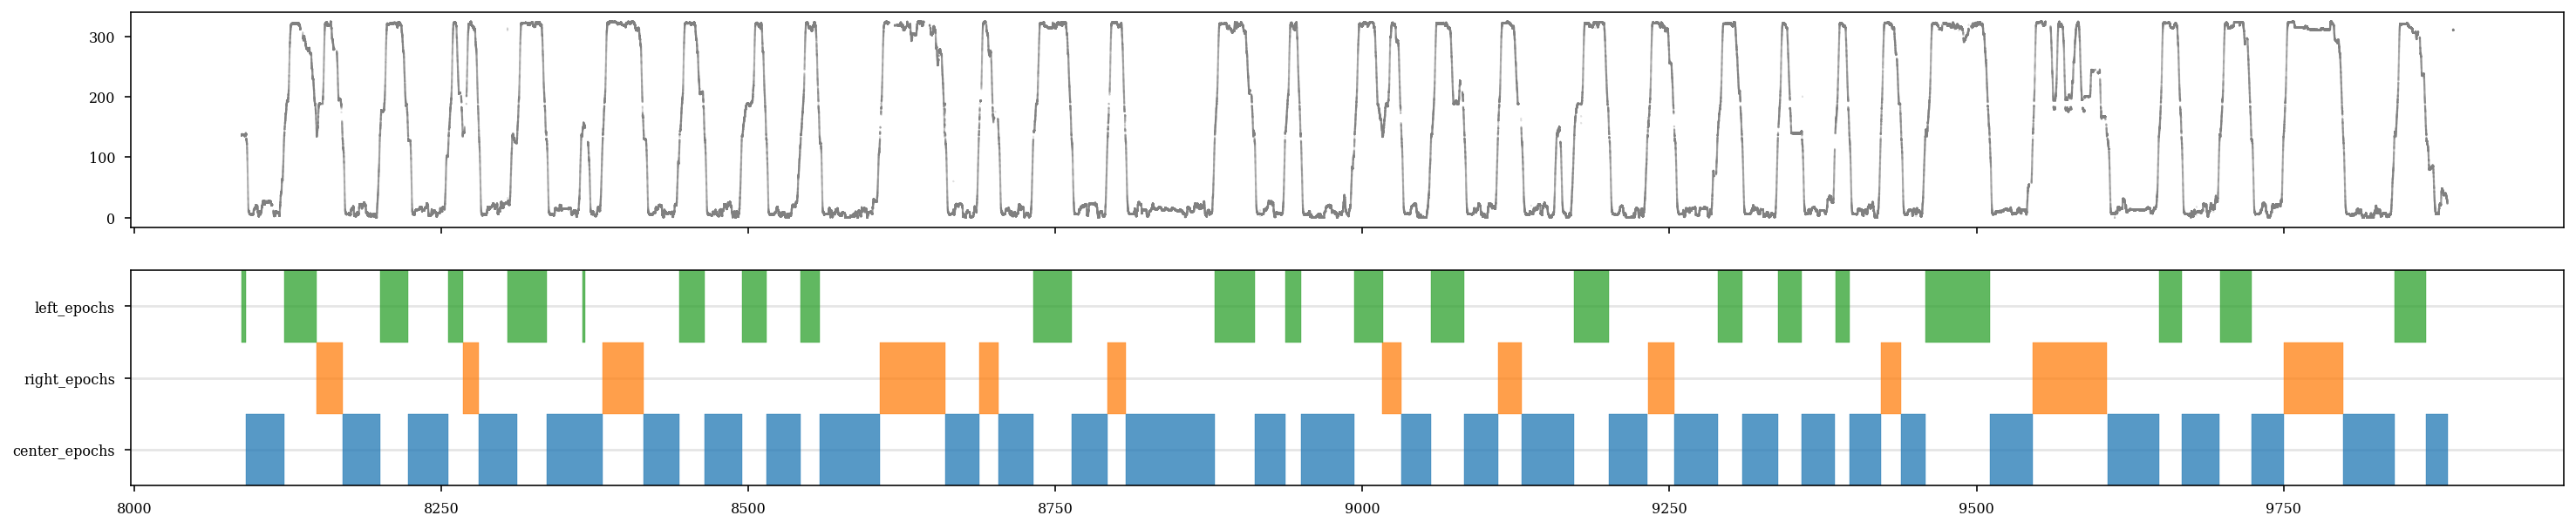

In [92]:
fig, ax = plt.subplots(2, 1, figsize=(25, 5), sharex=True, sharey=False)
ax[0].scatter(pos.abscissa_vals, pos.data, s=1,color='grey',alpha=.2,linestyle="--")

events = []

events.append(center_epochs)
events.append(right_epochs)
events.append(left_epochs)
custom_plots.plot_events(events,['center_epochs','right_epochs','left_epochs'],ax=ax[1])


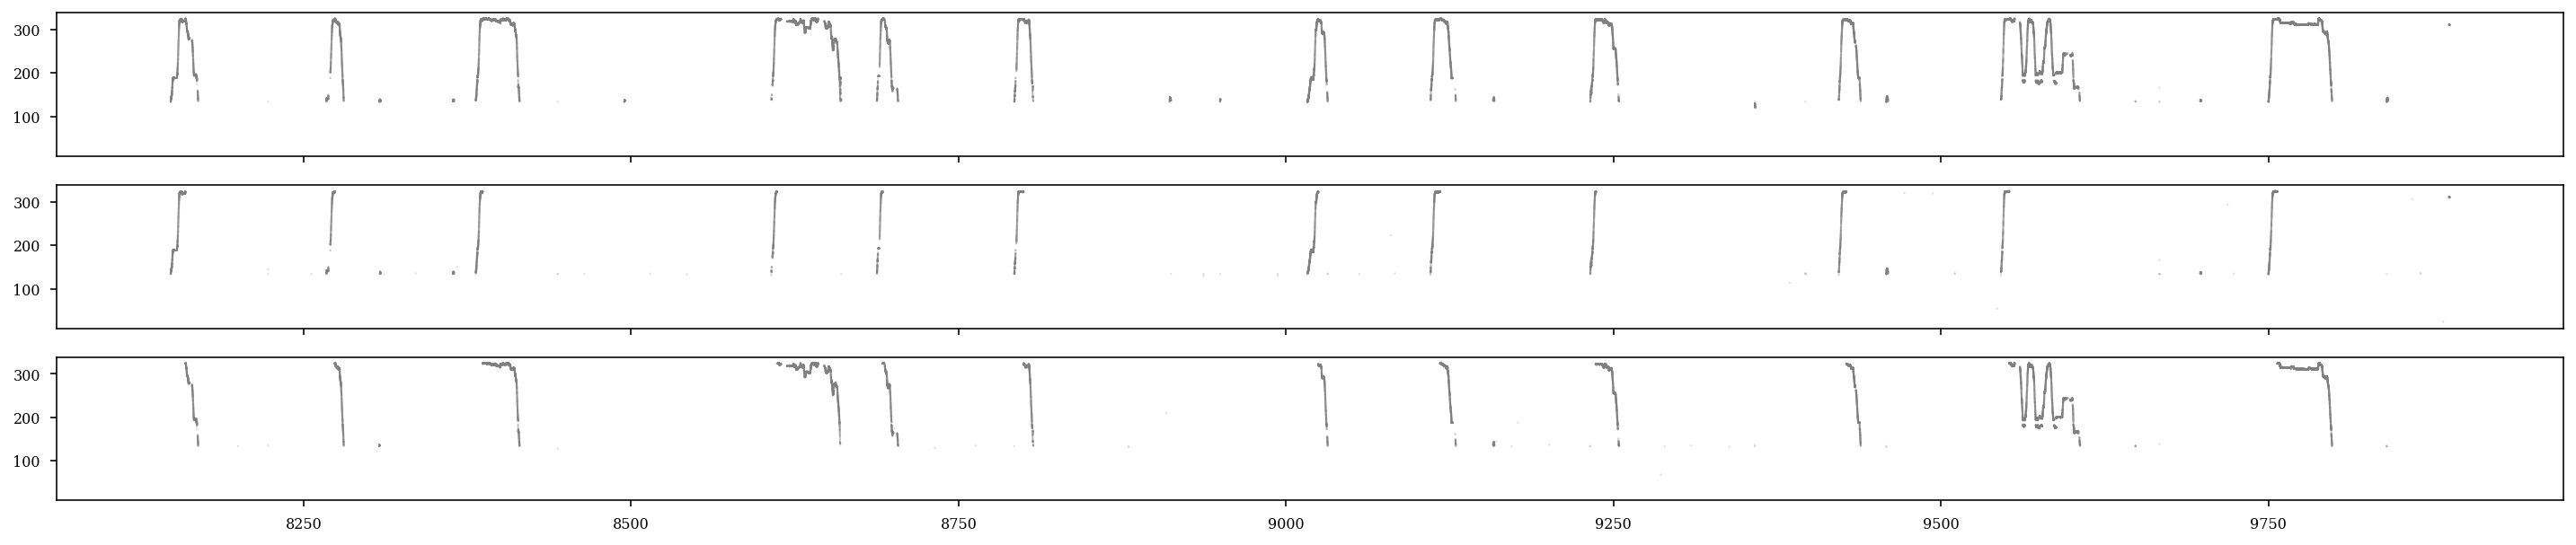

In [147]:
fig, ax = plt.subplots(3, 1, figsize=(25, 5), sharex=True, sharey=True)
ax[0].scatter(pos[right_epochs].abscissa_vals, pos[right_epochs].data, s=1,color='grey',alpha=.2,linestyle="--")

(outbound_epochs, inbound_epochs) = functions.get_linear_track_lap_epochs(
    pos[right_epochs].abscissa_vals,
    pos[right_epochs].data[0],
    newLapThreshold=10,
)
ax[1].scatter(pos[outbound_epochs][~(center_epochs | left_epochs)].abscissa_vals, pos[outbound_epochs][~(center_epochs | left_epochs)].data, s=1,color='grey',alpha=.2,linestyle="--")
ax[2].scatter(pos[inbound_epochs][~(center_epochs | left_epochs)].abscissa_vals, pos[inbound_epochs][~(center_epochs | left_epochs)].data, s=1,color='grey',alpha=.2,linestyle="--")


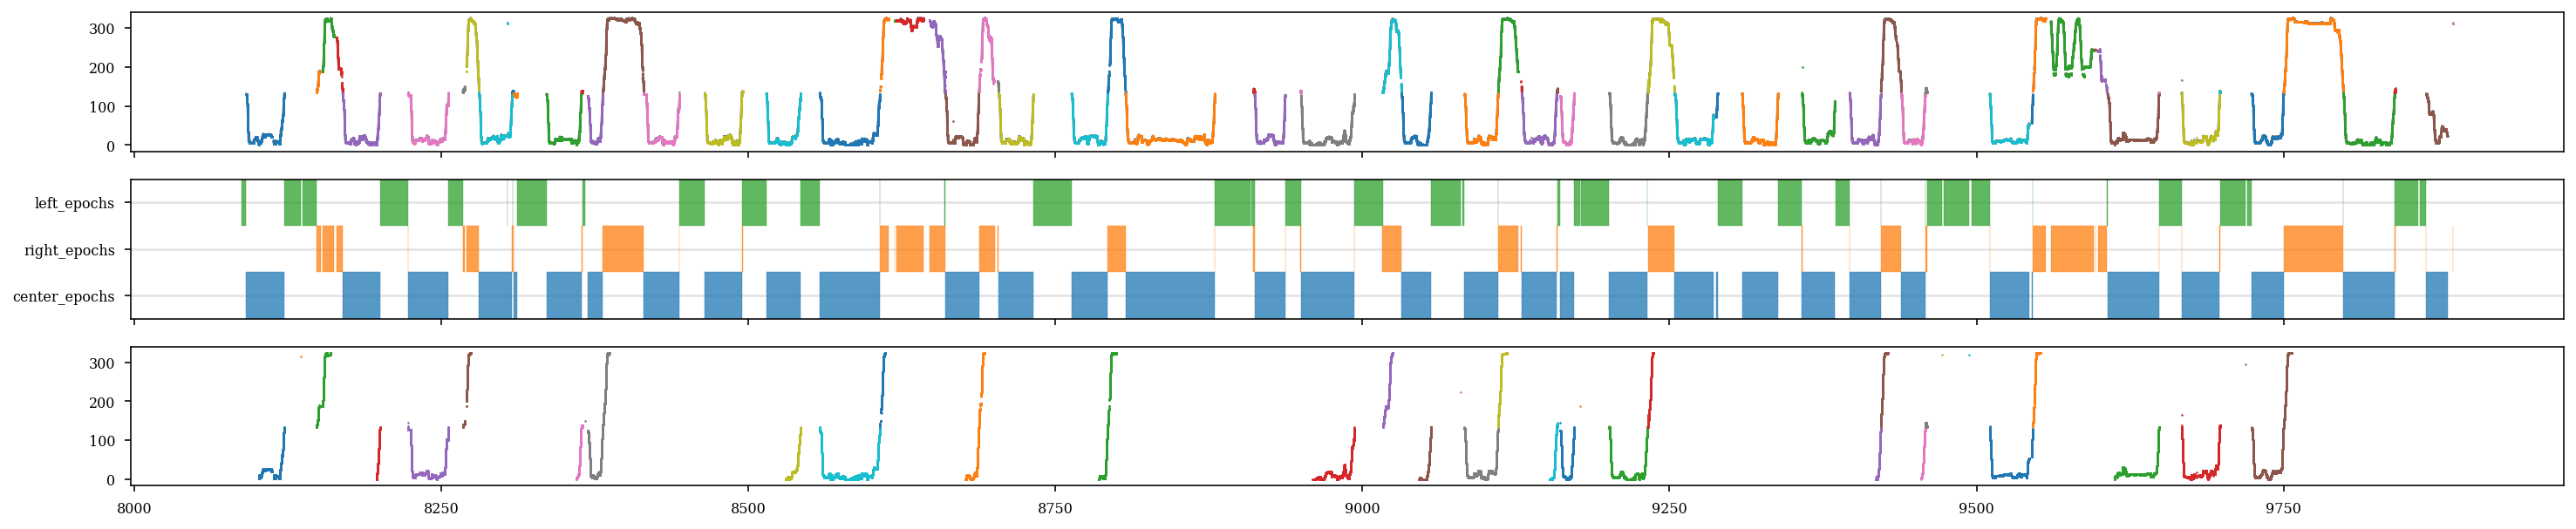

In [141]:
fig, ax = plt.subplots(3, 1, figsize=(25, 5), sharex=True, sharey=False)
center_right = (center_epochs | right_epochs)

ax[0].scatter(pos[center_right].abscissa_vals, pos[center_right].data, s=1,color='grey',alpha=.2,linestyle="--")

for ep in center_right:
    ax[0].scatter(pos[ep].abscissa_vals, pos[ep].data, s=1)

events = []
events.append(center_epochs)
events.append(right_epochs)
events.append(left_epochs)
custom_plots.plot_events(events,['center_epochs','right_epochs','left_epochs'],ax=ax[1])

(outbound_epochs_new, inbound_epochs_new) = functions.get_linear_track_lap_epochs(
    pos[center_right].abscissa_vals,
    pos[center_right].data[0],
    newLapThreshold=10,
)
outbound_epochs_new = find_good_laps(pos[center_right], outbound_epochs_new)

for ep in outbound_epochs_new[~left_epochs]:
    ax[2].scatter(pos[ep].abscissa_vals, pos[ep].data, s=1)


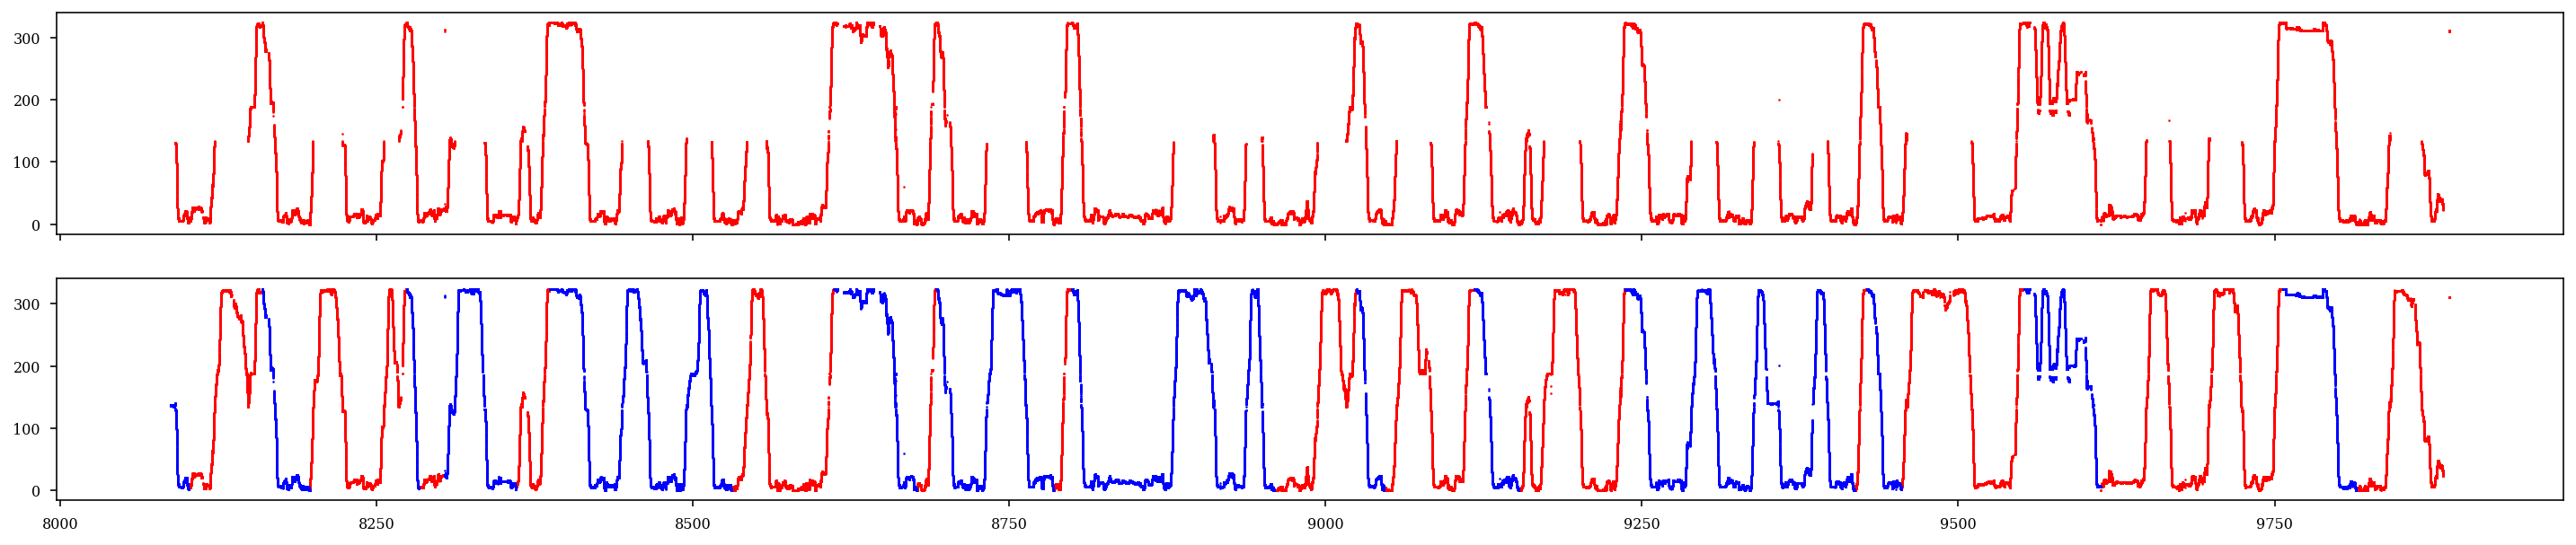

In [82]:
fig,ax = plt.subplots(2,1,figsize=(25,5),sharex=True,sharey=True)
center_right = (center_epochs | right_epochs).merge(gap=5)
# for ep in center_right:
ax[0].scatter(pos[epochs[2]][center_right].abscissa_vals ,pos[epochs[2]][center_right].data,color="red",s=1)

(outbound_epochs_new, inbound_epochs_new) = functions.get_linear_track_lap_epochs(
    pos[center_right].abscissa_vals, pos[center_right].data[0], newLapThreshold=20
)
# outbound_epochs_new = find_good_laps(pos, outbound_epochs_new)
# inbound_epochs_new = find_good_laps(pos, inbound_epochs_new)
ax[1].scatter(pos[epochs[2]][outbound_epochs_new].abscissa_vals ,pos[epochs[2]][outbound_epochs_new].data,color="red",s=1)
ax[1].scatter(pos[epochs[2]][inbound_epochs_new].abscissa_vals ,pos[epochs[2]][inbound_epochs_new].data,color="blue",s=1)


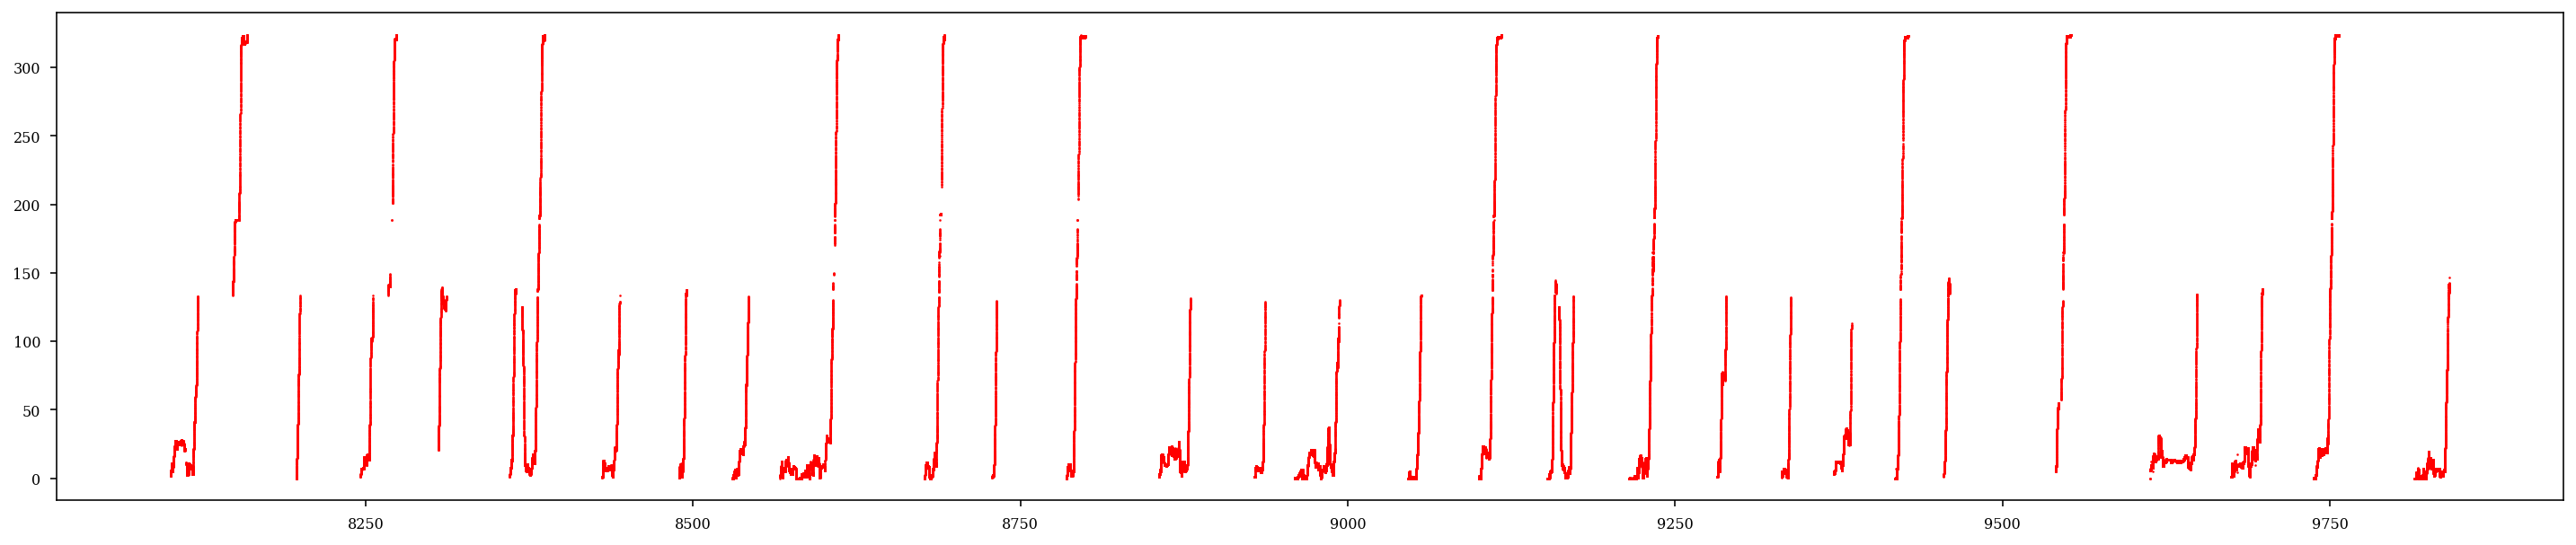

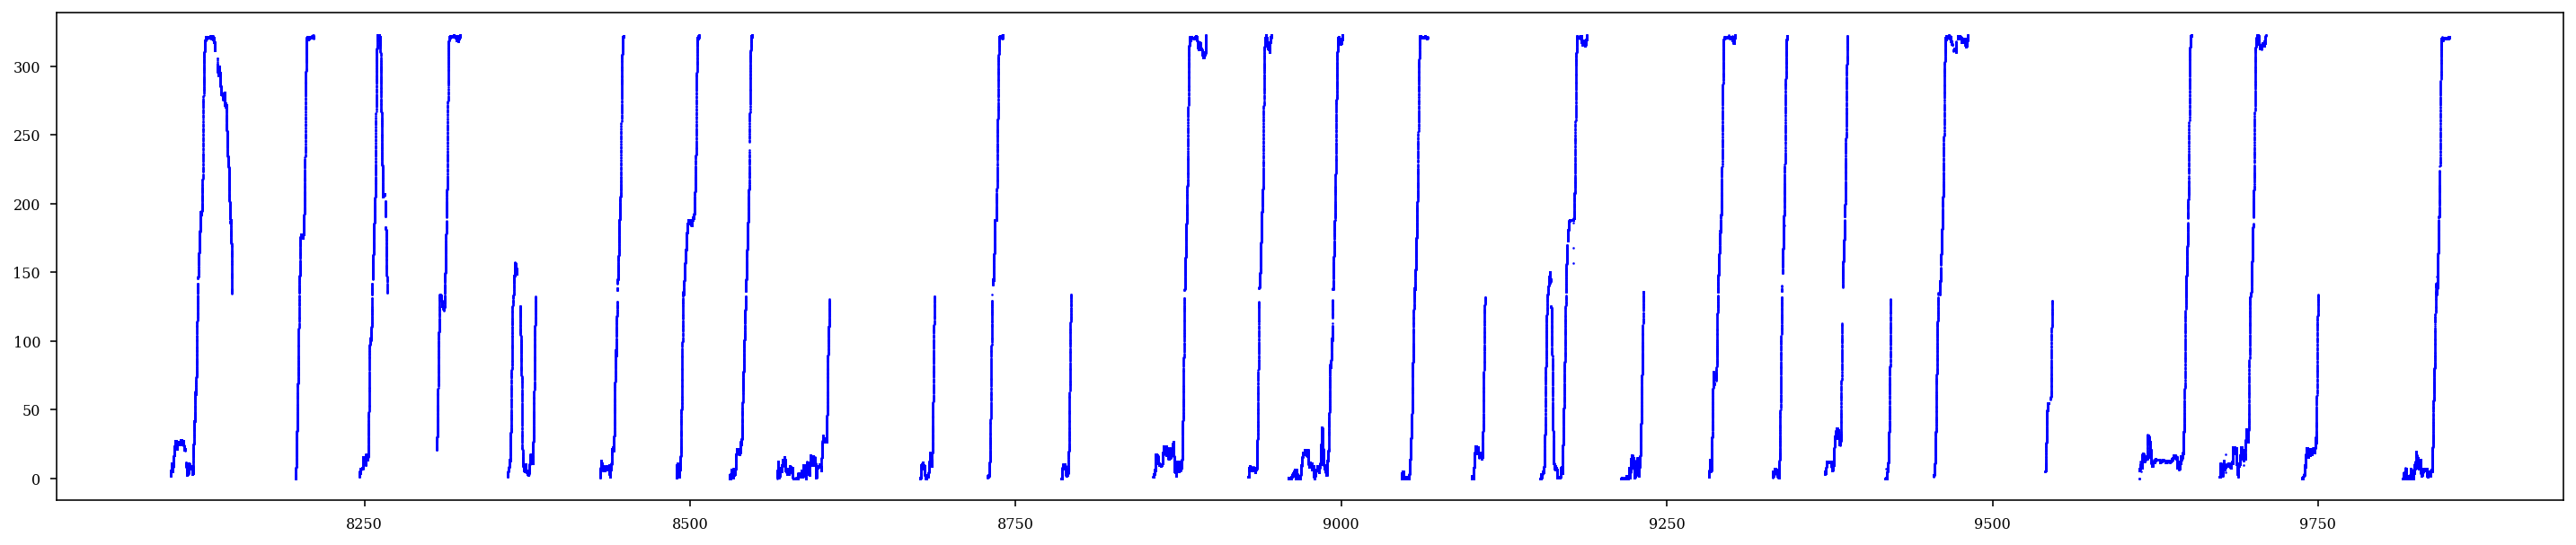

In [63]:
plt.figure(figsize=(25,5))
center_right = center_epochs | right_epochs
center_left = center_epochs | left_epochs
plt.scatter(pos[epochs[2]][outbound_epochs][center_right].abscissa_vals ,pos[epochs[2]][outbound_epochs][center_right].data,color="red",s=1)

plt.figure(figsize=(25,5))

plt.scatter(pos[epochs[2]][outbound_epochs][center_left].abscissa_vals ,pos[epochs[2]][outbound_epochs][center_left].data,color="blue",s=1)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


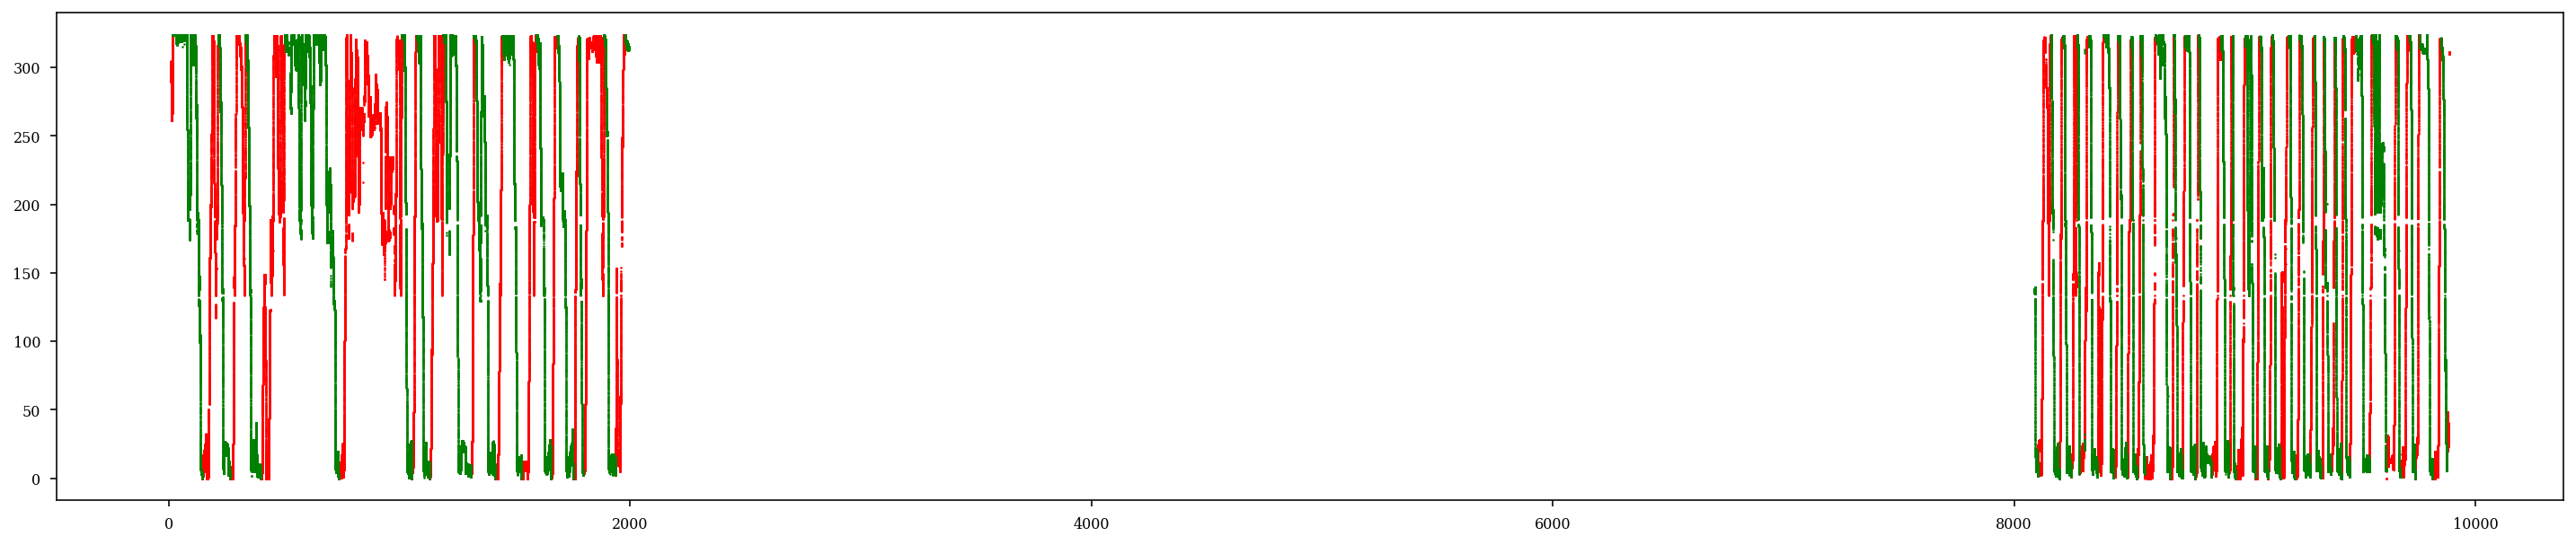

In [32]:
plt.figure(figsize=(25,5))
plt.scatter(pos[outbound_epochs].abscissa_vals ,pos[outbound_epochs].data,color="red",s=1)
plt.scatter(pos[inbound_epochs].abscissa_vals ,pos[inbound_epochs].data,color="green",s=1)

plt.show()

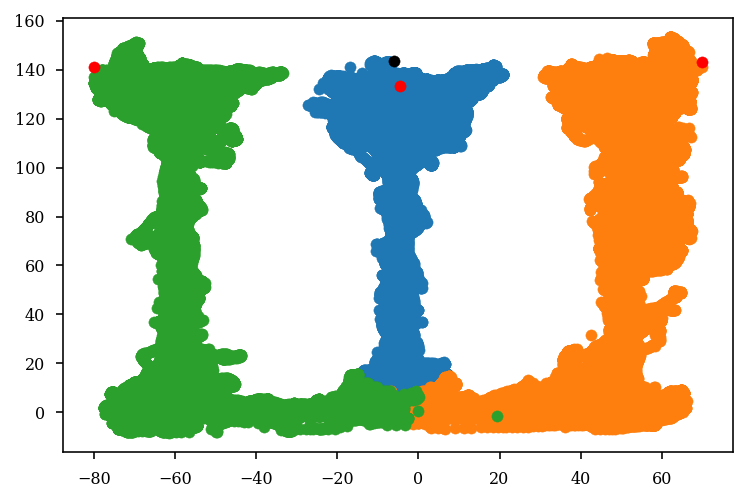

In [26]:
plt.scatter(position_df.query("states == 0").x, position_df.query("states == 0").y)
plt.scatter(position_df.query("states == 0").x.mean(), position_df.query("states == 0").y.max() - 10,color="r")
# plt.scatter(position_df.query("states == 0").x.median(), position_df.query("states == 0").y.max(),color="k")


plt.scatter(position_df.query("states == 1").x, position_df.query("states == 1").y)
plt.scatter(position_df.query("states == 1").x.max(), position_df.query("states == 1").y.max() - 10,color="r")


plt.scatter(position_df.query("states == 2").x, position_df.query("states == 2").y)
plt.scatter(position_df.query("states == 2").x.min(), position_df.query("states == 2").y.max() - 10,color="r")


In [77]:
import numpy as np
import pandas as pd
from scipy.ndimage.measurements import label

def enter_exit_target(position, target, max_distance=1):
    """Marks when a position has reached a target ("enter")
    and when it has left a target ("exit").
    The position is considered to have reached a target when it is less than
    the `max_distance` from the target.
    Enter and exit times are marked as follows:
     1: entered the target radius
     0: neither
    -1: exited the target radius
    Works for 1D position and 2D position.
    Parameters
    ----------
    position : ndarray, shape (n_time, n_space)
    target : ndarray, shape (1, n_space)
    max_distance : float, optional
        How close the position is to the target to be considered at the target.
    Returns
    -------
    enter_exit : ndarray, shape (n_time,)
    at_target : ndarray, shape (n_time,)
    """
    distance_from_target = paired_distances(position, target)
    at_target = distance_from_target < max_distance
    enter_exit = np.r_[0, np.diff(at_target.astype(float))]
    return enter_exit, at_target

def paired_distances(x, y):
    '''Euclidean distance between x and y at each time point.
    Parameters
    ----------
    x,y : ndarray, shape (n_time, n_space)
    Returns
    -------
    distance : ndarray, shape (n_time,)
    '''
    x, y = np.array(x), np.array(y)
    x = np.atleast_2d(x).T if x.ndim < 2 else x
    y = np.atleast_2d(y).T if y.ndim < 2 else y
    return np.linalg.norm(x - y, axis=1)


def enter_exit_target(position, target, max_distance=1):
    '''Marks when a position has reached a target ("enter")
    and when it has left a target ("exit").
    The position is considered to have reached a target when it is less than
    the `max_distance` from the target.
    Enter and exit times are marked as follows:
     1: entered the target radius
     0: neither
    -1: exited the target radius
    Works for 1D position and 2D position.
    Parameters
    ----------
    position : ndarray, shape (n_time, n_space)
    target : ndarray, shape (1, n_space)
    max_distance : float, optional
        How close the position is to the target to be considered at the target.
    Returns
    -------
    enter_exit : ndarray, shape (n_time,)
    at_target : ndarray, shape (n_time,)
    '''
    distance_from_target = paired_distances(position, target)
    at_target = distance_from_target < max_distance
    enter_exit = np.r_[0, np.diff(at_target.astype(float))]
    return enter_exit, at_target


def shift_well_enters(enter_exit):
    '''Shifts the enter times back one time point.'''
    shifted_enter_exit = enter_exit.copy()
    old_ind = np.where(enter_exit > 0)[0]  # positive entries are well-entries
    new_ind = old_ind - 1
    shifted_enter_exit[new_ind] = enter_exit[old_ind]
    shifted_enter_exit[old_ind] = 0
    return shifted_enter_exit


def segment_path(time, position, well_locations, max_distance_from_well=10):
    '''Label traversals between each well location.
    Parameters
    ----------
    time : ndarray, shape (n_time,)
    position : ndarray, shape (n_time, n_space)
    well_locations : array_like, shape (n_wells, n_space)
    max_distance_from_well : float, optional
        The animal is considered at a well location if its position is closer
        than this value.
    Returns
    -------
    segments_df : pandas DataFrame, shape (n_segments, 6)
    labeled_segments : pandas DataFrame, shape (n_time,)
    '''
    n_wells = len(well_locations)
    well_enter_exit, at_target = np.stack(
        [enter_exit_target(position, np.atleast_2d(well),
                           max_distance_from_well)
         for well in well_locations], axis=1)

    well_labels = np.arange(n_wells) + 1
    well_enter_exit = np.sum(well_enter_exit.T * well_labels, axis=1)
    shifted_well_enter_exit = shift_well_enters(well_enter_exit)
    is_segment = ~(np.sum(at_target, axis=0) > 0)
    labeled_segments, n_segment_labels = label(is_segment)
    segment_labels = np.arange(n_segment_labels) + 1

    start_time, end_time, duration = [], [], []
    distance_traveled, from_well, to_well = [], [], []

    for segment_label in segment_labels:
        is_seg = np.in1d(labeled_segments, segment_label)
        segment_time = time[is_seg]
        start_time.append(segment_time.min())
        end_time.append(segment_time.max())
        duration.append(segment_time.max() - segment_time.min())
        try:
            start, _, end = np.unique(shifted_well_enter_exit[is_seg])
        except ValueError:
            start, end = np.nan, np.nan

        from_well.append(np.abs(start))
        to_well.append(np.abs(end))
        p = position[is_seg]
        distance_traveled.append(np.sum(paired_distances(p[1:], p[:-1])))

    data = [('start_time', start_time), ('end_time', end_time),
            ('duration', duration), ('from_well', from_well),
            ('to_well', to_well),
            ('distance_traveled', distance_traveled)]
    index = pd.Index(segment_labels, name='segment')
    return (pd.DataFrame.from_dict(dict(data)).set_index(index),
            pd.DataFrame(dict(labeled_segments=labeled_segments), index=time))


def find_last_non_center_well(segments_df, segment_ind):
    last_wells = segments_df.iloc[:segment_ind].to_well
    try:
        return last_wells[last_wells != 'center'].iloc[-1]
    except IndexError:
        # There are no non-center wells. Just return current well.
        return ''


def get_correct_inbound_outbound(segments_df):
    n_segments = segments_df.shape[0]
    task = np.empty((n_segments,), dtype=object)
    is_correct = np.empty((n_segments,), dtype=bool)

    for segment_ind in np.arange(n_segments):
        if segments_df.iloc[segment_ind].from_well == 'center':
            task[segment_ind] = 'Outbound'
            is_correct[segment_ind] = (
                segments_df.iloc[segment_ind].to_well !=
                find_last_non_center_well(segments_df, segment_ind))
        else:
            task[segment_ind] = 'Inbound'
            is_correct[segment_ind] = (
                segments_df.iloc[segment_ind].to_well == 'center')

    segments_df['task'] = task
    segments_df['is_correct'] = is_correct

    return segments_df


def score_inbound_outbound(segments_df, min_distance_traveled=100):
    '''In the alternating arm task, determines whether the trial should be
    inbound (running to the center arm) or outbound (running to the opposite
    outer arm as before) and if the trial was performed correctly.
    Parameters
    ----------
    segments_df : pandas DataFrame
        Output of `segment_path` function.
    min_distance_traveled : float, optional
        Minimum path length (in cm) while outside of the well radius for
        a segment to be considered as a trial.
    Returns
    -------
    segments_df : pandas DataFrame
        Same as the input dataframe but with the wells labeled
        (left, right, center) and columns for `task` (inbound/outbound) and
        `is_correct` (True/False).
    '''
    segments_df = (segments_df.copy()
                   .loc[segments_df.distance_traveled > min_distance_traveled]
                   .dropna())
    WELL_NAMES = {
        1: 'center',
        2: 'left',
        3: 'right'
    }
    segments_df = segments_df.assign(
        to_well=lambda df: df.to_well.map(WELL_NAMES),
        from_well=lambda df: df.from_well.map(WELL_NAMES))
    return get_correct_inbound_outbound(segments_df)

C:\Users\Cornell\AppData\Local\Temp\ipykernel_5644\2102701360.py:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.


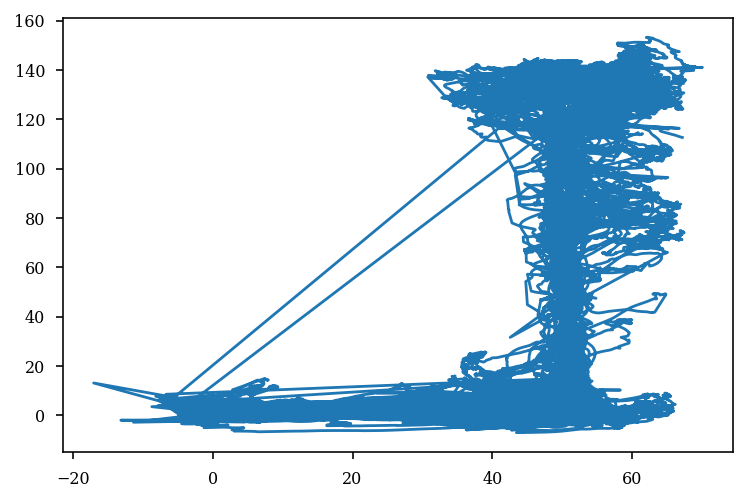

In [100]:
plt.plot(position_df.query("states == 1").x,position_df.query("states == 1").y)

In [101]:
well_locations = np.array(
    [
        [
            position_df.query("states == 0").x.mean(),
            position_df.query("states == 0").y.max(),
        ],
        [
            position_df.query("states == 2").x.mean(),
            position_df.query("states == 2").y.max(),
        ],
        [
            position_df.query("states == 1").x.mean(),
            position_df.query("states == 1").y.max(),
        ]
    ]
)
temp_df = position_df[~np.isnan(position_df.x)]
segments_df, labeled_segments = segment_path(
    temp_df["timestamps"].values,
    temp_df[["x", "y"]].values,
    well_locations,
    max_distance_from_well=20,
)


segments_df = score_inbound_outbound(segments_df, min_distance_traveled=50)
segments_df

start_time    end_time  duration from_well to_well  \
segment                                                       
12         75.97020    93.87755  17.90735     right   right   
13        100.52720   109.39340   8.86620     right   right   
15        114.18480   136.93355  22.74875     right  center   
17        148.45790   152.09940   3.64150    center  center   
18        153.16600   161.16555   7.99955    center  center   
...             ...         ...       ...       ...     ...   
663      9759.00095  9788.09100  29.09005     right   right   
666      9790.72420  9800.69030   9.96610     right  center   
672      9815.93115  9819.63930   3.70815    center  center   
681      9837.70495  9844.70460   6.99965    center    left   
682      9851.89585  9873.50300  21.60715      left  center   

         distance_traveled      task  is_correct  
segment                                           
12              538.957962   Inbound       False  
13              143.523205   Inbound       False  
15              703.043502   Inbound        True  
17               55.308834  Outbound        True  
18              149.345573  Outbound        True  
...                    ...       ...         ...  
663             119.953728   Inbound       False  
666             406.199666   Inbound        True  
672              57.266441  Outbound        True  
681             411.265912  Outbound        True  
682             552.259671   Inbound        True  

[179 rows x 8 columns]

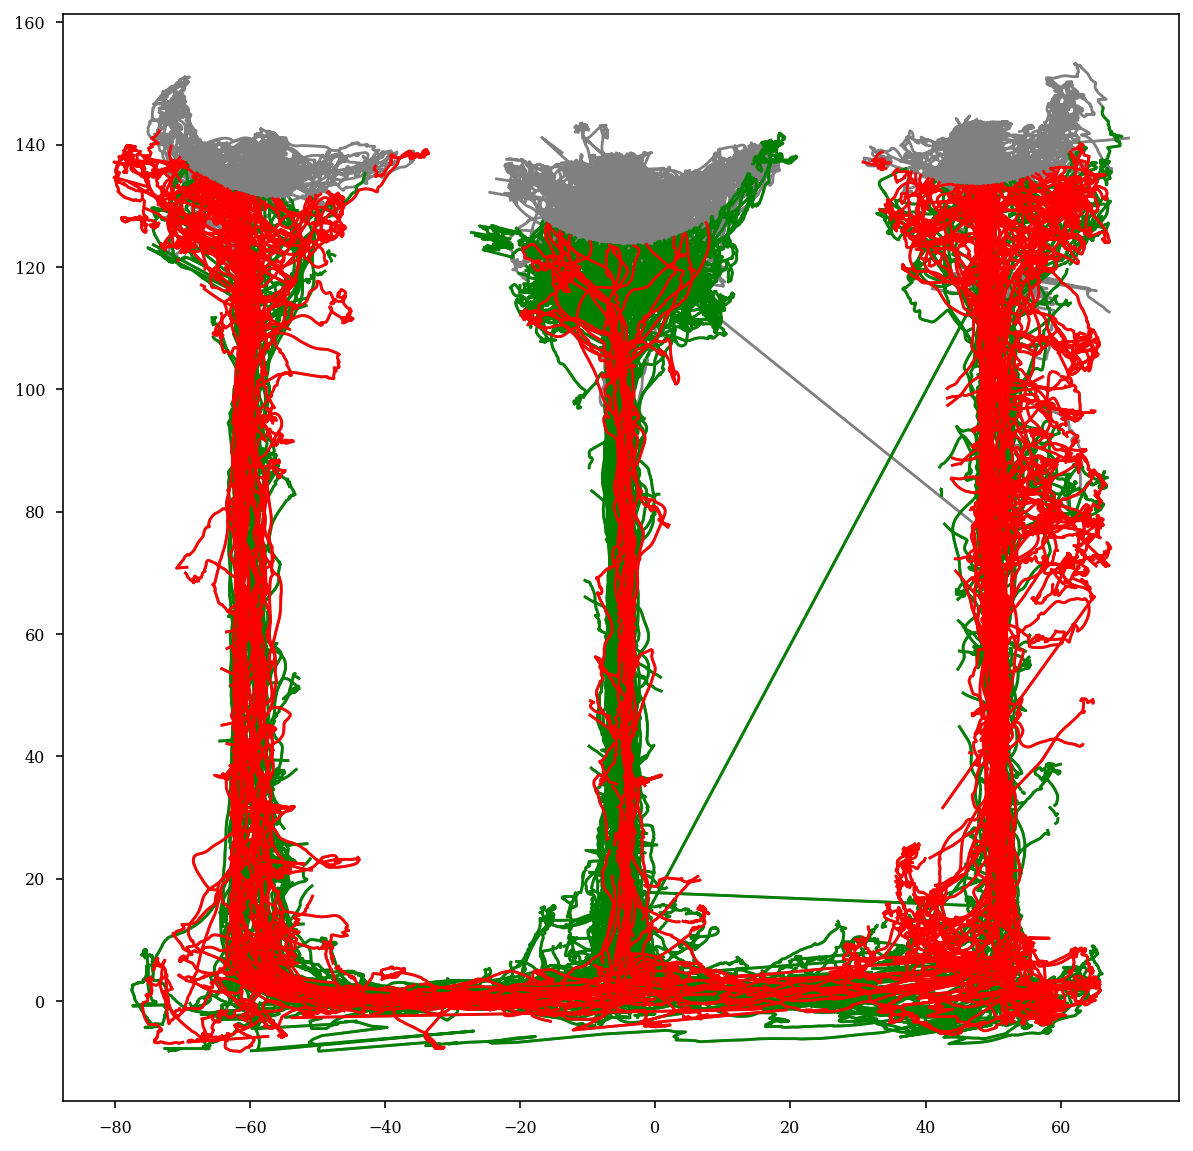

In [102]:
plt.figure(figsize=(10, 10))
plt.plot(position_df.x, position_df.y,color="grey")
for ep in segments_df.query("is_correct == True").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    plt.plot(
        position_df[idx].x,
        position_df[idx].y,
        color="green"
    )
for ep in segments_df.query("is_correct == False").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    plt.plot(
        position_df[idx].x,
        position_df[idx].y,
        color="red"
    )
# position_df.query('timestamps >=631.39810 & timestamps <=641.21425').plot(x='x', y='y')


Text(0.5, 1.0, "from_well == 'right' & to_well == 'center'")

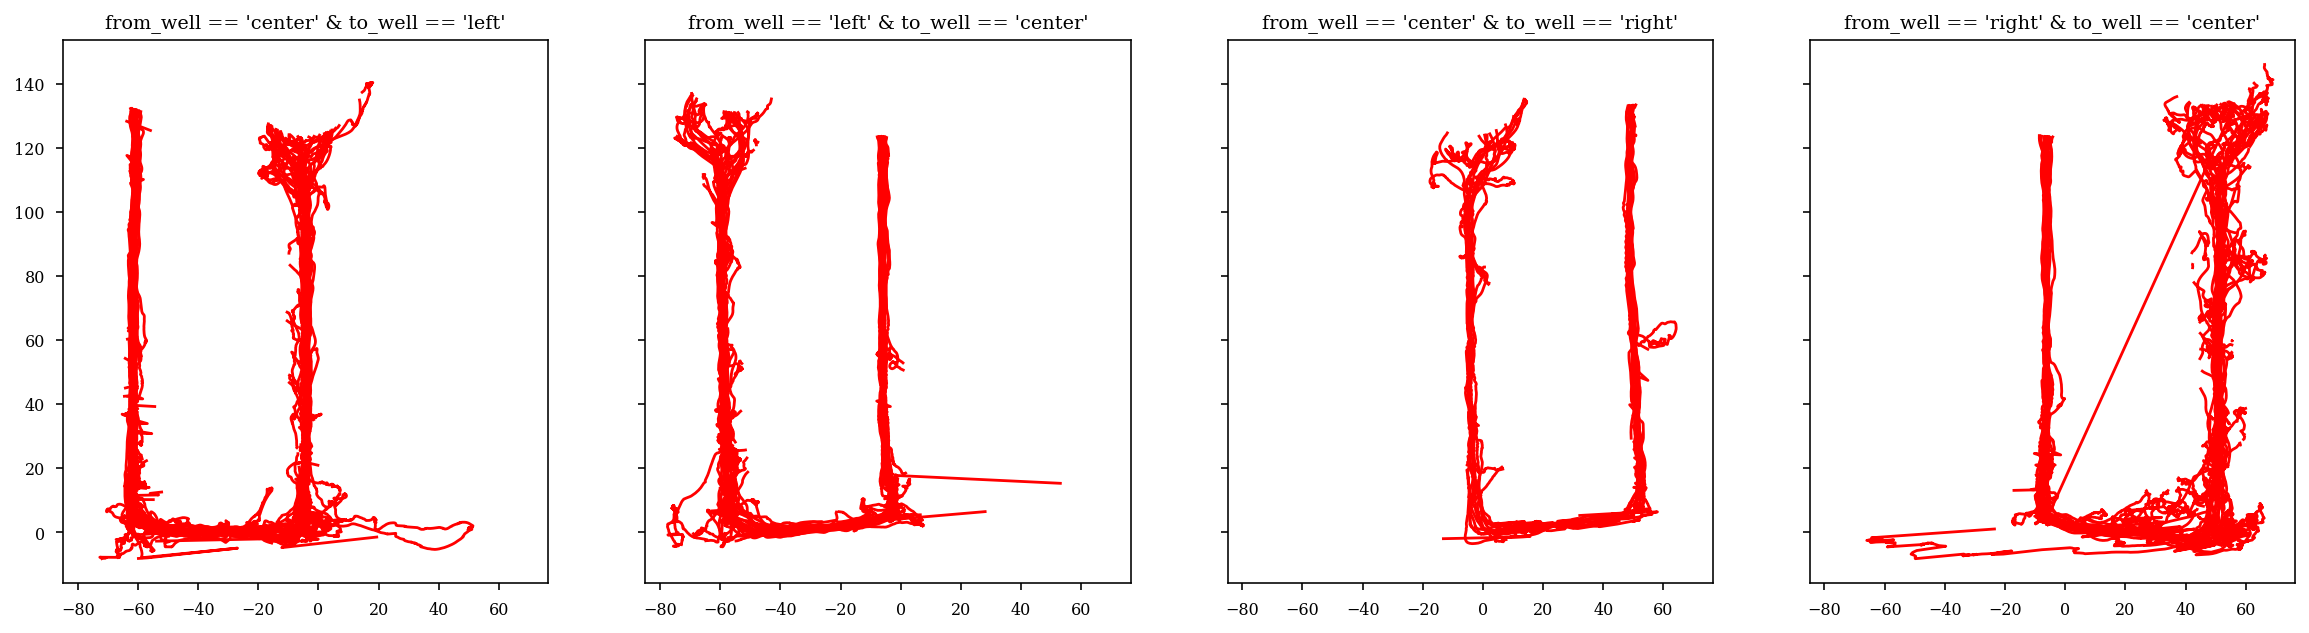

In [112]:
fig,ax = plt.subplots(1,4,figsize=(20, 5),sharey=True,sharex=True)
for ep in segments_df.query("from_well == 'center' & to_well == 'left'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[0].plot(
        position_df[idx].x,
        position_df[idx].y,
        color="red"
    )

for ep in segments_df.query("from_well == 'left' & to_well == 'center'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[1].plot(
        position_df[idx].x,
        position_df[idx].y,
        color="red"
    )

for ep in segments_df.query("from_well == 'center' & to_well == 'right'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[2].plot(
        position_df[idx].x,
        position_df[idx].y,
        color="red"
    )

for ep in segments_df.query("from_well == 'right' & to_well == 'center'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[3].plot(
        position_df[idx].x,
        position_df[idx].y,
        color="red"
    )

ax[0].set_title("from_well == 'center' & to_well == 'left'")
ax[1].set_title("from_well == 'left' & to_well == 'center'")
ax[2].set_title("from_well == 'center' & to_well == 'right'")
ax[3].set_title("from_well == 'right' & to_well == 'center'")

(8000.0, 10000.0)

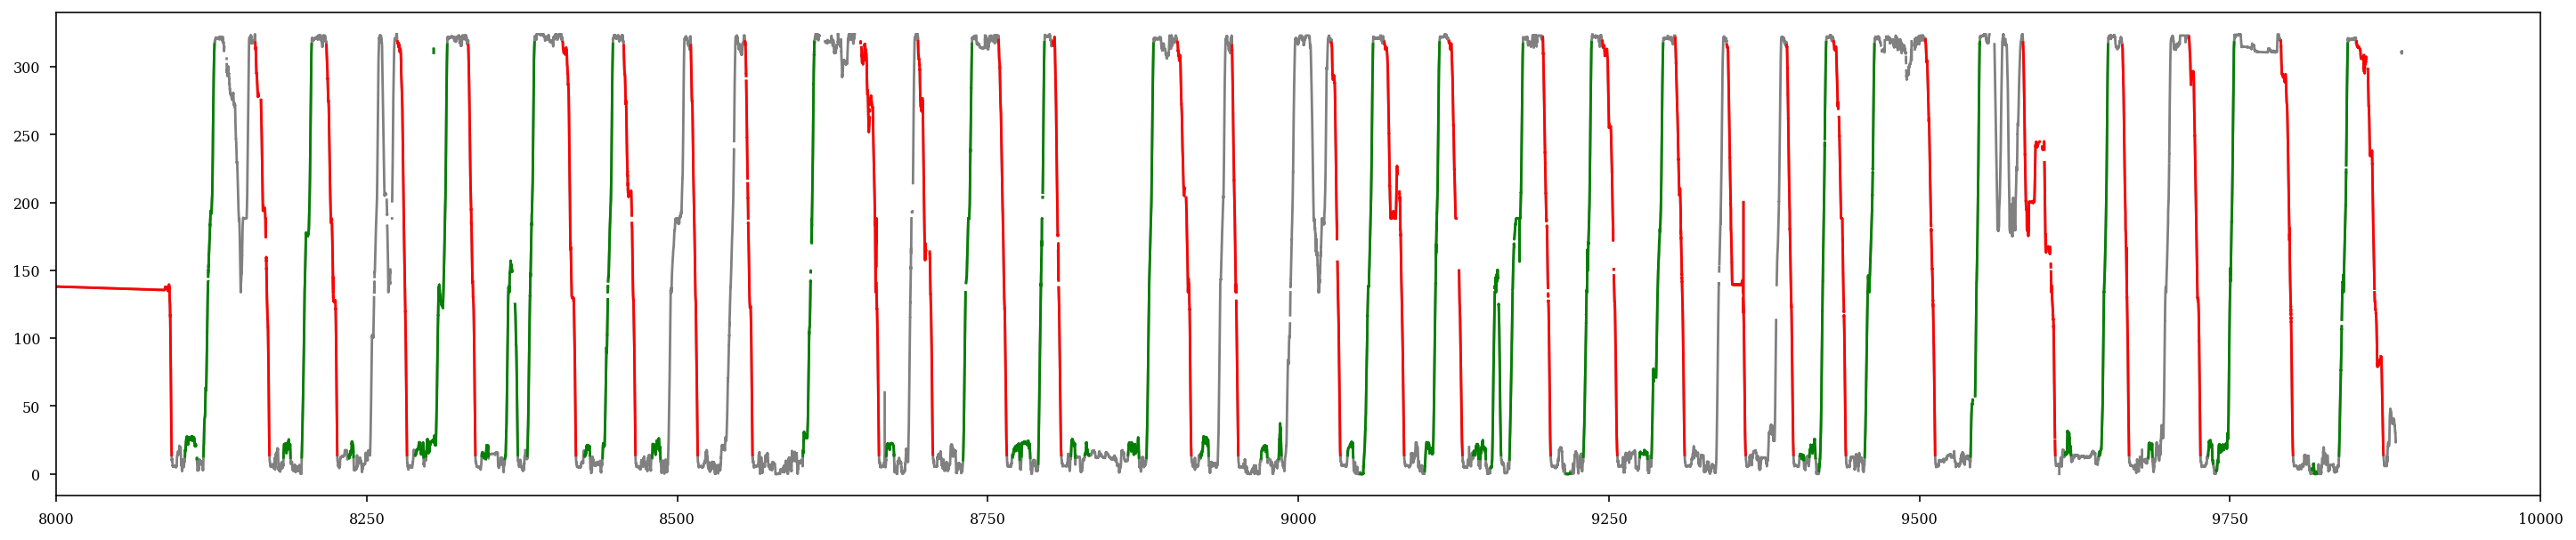

In [97]:
plt.figure(figsize=(25, 5))

plt.plot(
    position_df.timestamps,
    position_df.linearized,
    color="grey"
)
for ep in segments_df.query("is_correct == True & task == 'Inbound'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    plt.plot(
        position_df[idx].timestamps,
        position_df[idx].linearized,
        color="red"
    )

for ep in segments_df.query("is_correct == True & task == 'Outbound'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    plt.plot(
        position_df[idx].timestamps,
        position_df[idx].linearized,
        color="green"
    )

plt.xlim(8000, 10000)

(8000.0, 10000.0)

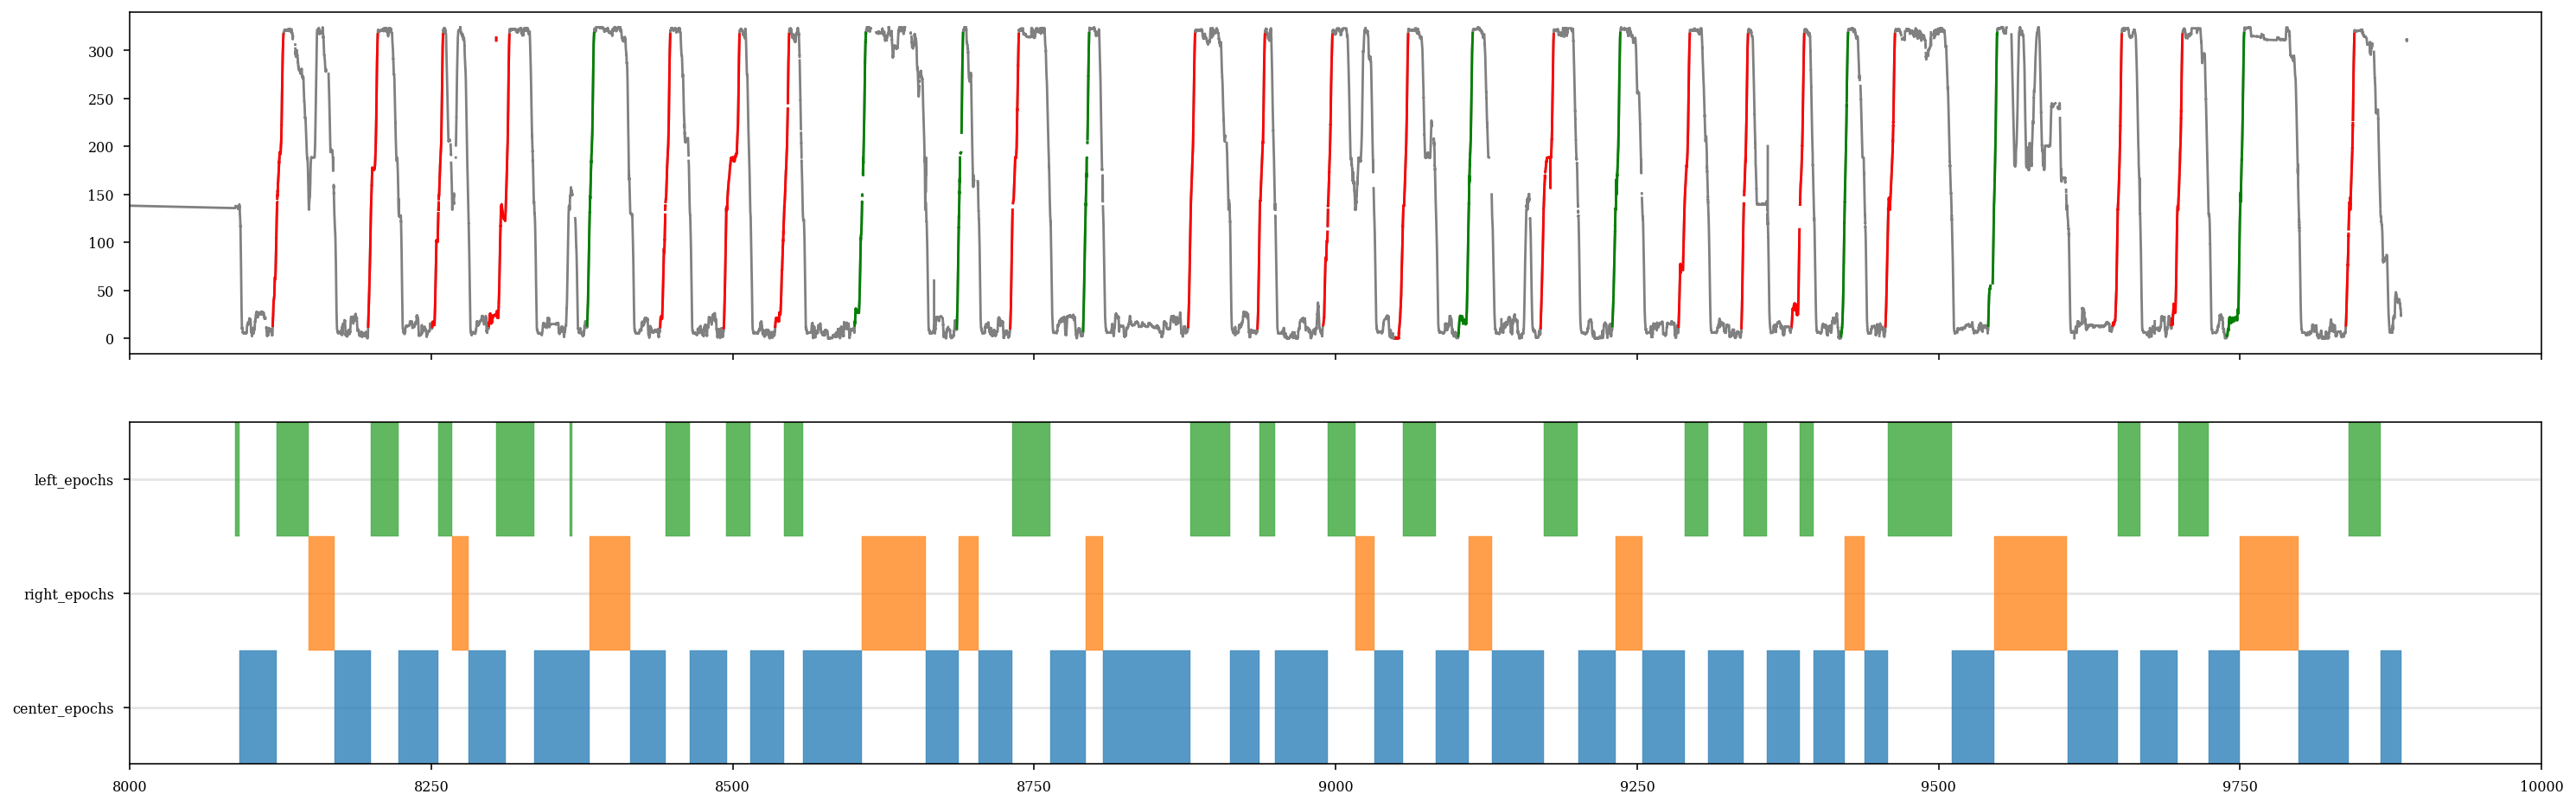

In [98]:
fig,ax = plt.subplots(2,1,figsize=(25, 8),sharex=True)

ax[0].plot(
    position_df.timestamps,
    position_df.linearized,
    color="grey"
)
for ep in segments_df.query("from_well == 'center' & to_well == 'right'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[0].plot(
        position_df[idx].timestamps,
        position_df[idx].linearized,
        color="red"
    )

for ep in segments_df.query("from_well == 'center' & to_well == 'left'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[0].plot(
        position_df[idx].timestamps,
        position_df[idx].linearized,
        color="green"
    )
events = []
events.append(center_epochs)
events.append(right_epochs)
events.append(left_epochs)
custom_plots.plot_events(events,['center_epochs','right_epochs','left_epochs'],ax=ax[1])

ax[0].set_xlim(8000, 10000)

(8000.0, 10000.0)

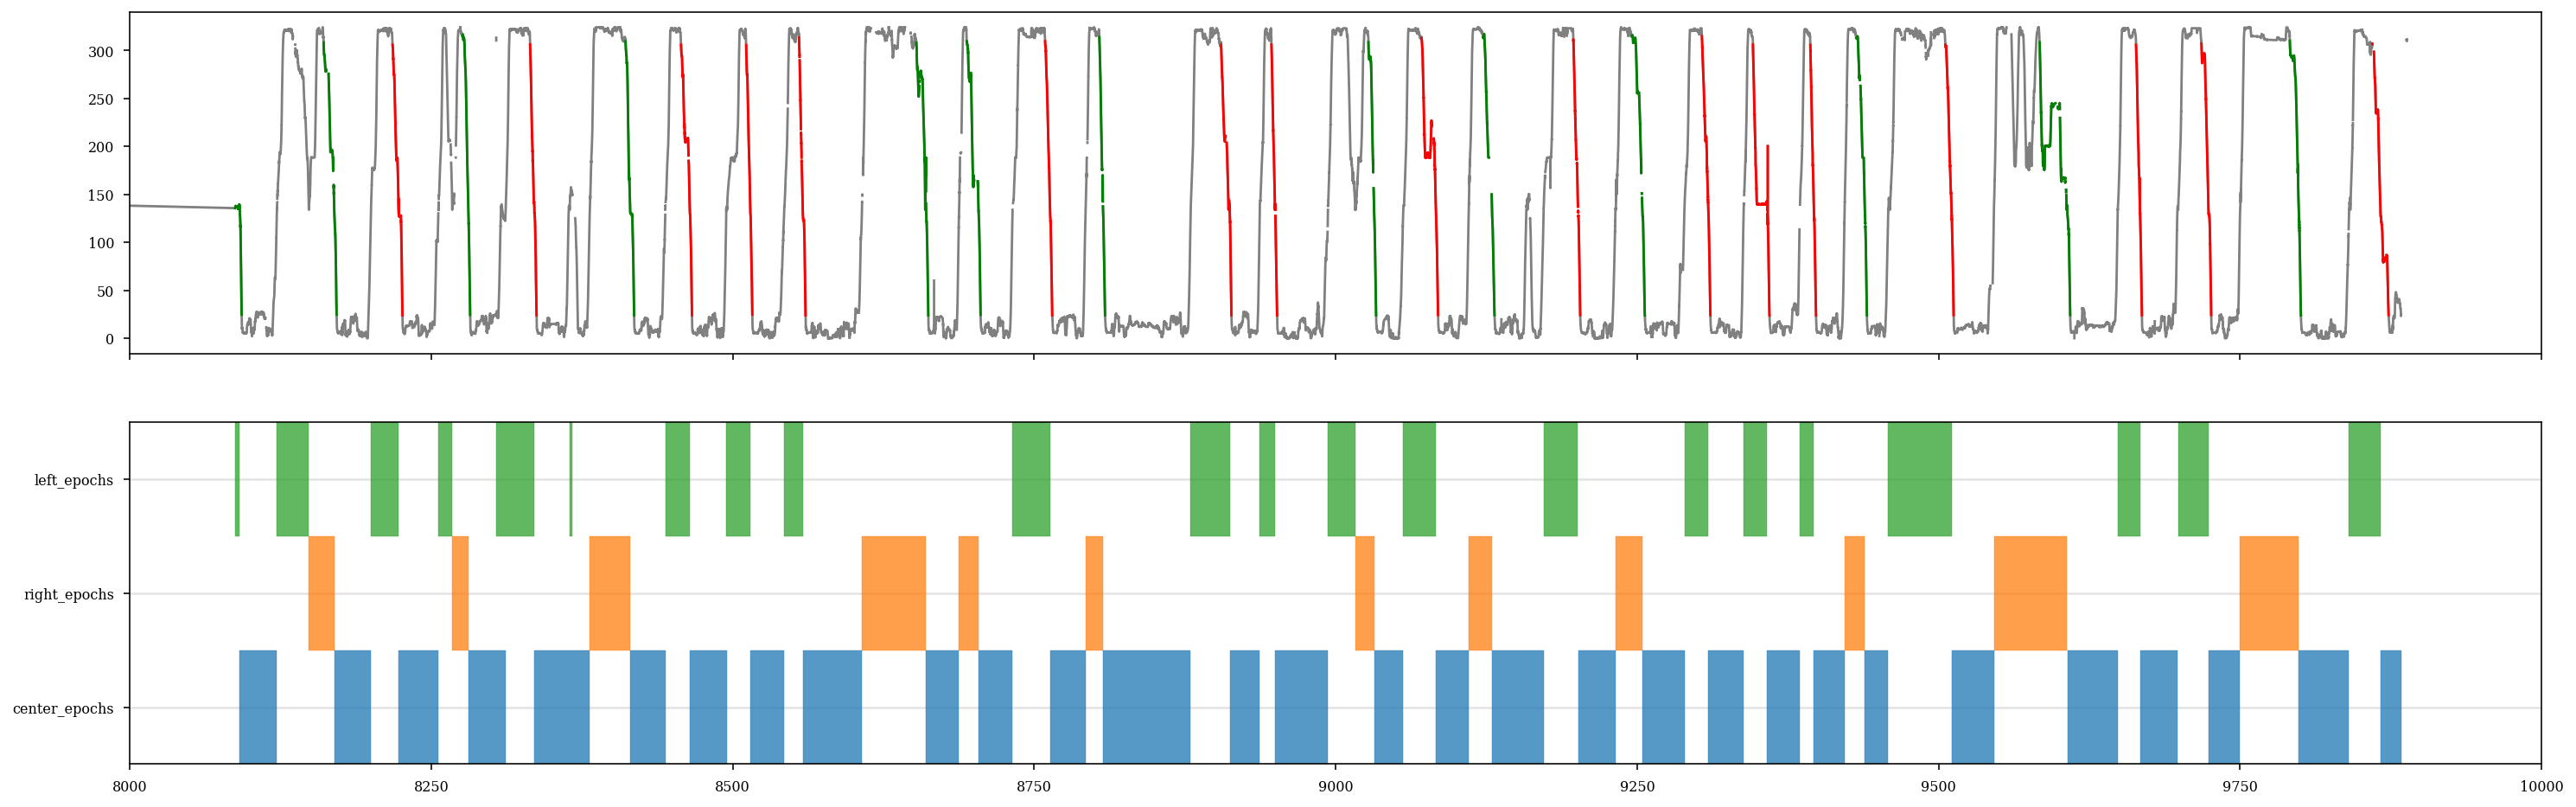

In [94]:
fig,ax = plt.subplots(2,1,figsize=(25, 8),sharex=True)

ax[0].plot(
    position_df.timestamps,
    position_df.linearized,
    color="grey"
)
for ep in segments_df.query("from_well == 'right' & to_well == 'center'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[0].plot(
        position_df[idx].timestamps,
        position_df[idx].linearized,
        color="red"
    )

for ep in segments_df.query("from_well == 'left' & to_well == 'center'").itertuples():
    # position_df.timestamps.between_time(ep.start_time, ep.end_time)
    idx = (position_df.timestamps >= ep.start_time) & (position_df.timestamps <= ep.end_time)
    ax[0].plot(
        position_df[idx].timestamps,
        position_df[idx].linearized,
        color="green"
    )
events = []
events.append(center_epochs)
events.append(right_epochs)
events.append(left_epochs)
custom_plots.plot_events(events,['center_epochs','right_epochs','left_epochs'],ax=ax[1])

ax[0].set_xlim(8000, 10000)